# Idea

Basically, I'd like to do some simple tests on "how can we establish the efficacy of our period-finding method?". I think it would be effective to do two simple things for now:

1. Try lots of different amplitudes (at a given frequency) and see how low we have to go before the period isn't readily identifiable
2. Try lots of different periods (at a given amplitude) and see what frequencies are recoverable and what aren't.

Then, eventually, we'll want to do a grid to see if these two things depend on each other. We'll also want to investigate the effects of "survey" (WSERV5 vs 7 vs 8), spatial location (esp. which footprint), and source brightness / photometric noise.

In [1]:
# for a simple object, let's load its data, inject signals, and see what happens.

In [177]:
# imports

from datetime import datetime, timedelta

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from astropy.timeseries import LombScargle

plt.style.use('seaborn-whitegrid')
import warnings
warnings.filterwarnings('ignore')

In [108]:
%run ../period_recovery.py

<ErrorbarContainer object of 3 artists>

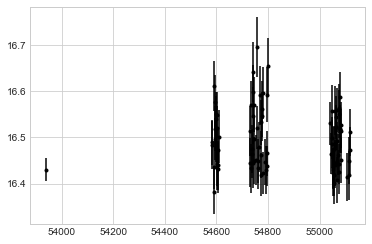

In [5]:
# load data
times = np.loadtxt("sample_k_dates.txt")
mags = np.loadtxt("sample_k_mags.txt")
errs = np.loadtxt("sample_k_errs.txt")


plt.errorbar(times, mags, yerr=errs, fmt='k.', )

In [6]:
from wuvars.analysis.periods import f_max, f_min, N_eval

In [238]:
freq = np.linspace(f_min, f_max, N_eval)

for i in range(15):

    ls = LombScargle(times, mags + np.sin(times + 10*i), dy=errs)
    power = ls.power(freq)

    min_freq = 1/100
    power[freq<min_freq] = 0

    fmax = freq[np.nanargmax(power)]
    fap = ls.false_alarm_probability(np.nanmax(power))
    # print(f"FAP of peak: {fap:.2e}. Freq: {fmax:.2f} day^-1 (Period: {24. / fmax:.2f} hours)")
    print(ls.model_parameters(fmax))
    print(np.sqrt(np.sum(ls.model_parameters(fmax)[1:3]**2)))
    print(np.sqrt(np.sum(ls.model_parameters(fmax)[0:3]**2)))

[-0.16587006 -0.98988158  0.02555828]
0.9902114796345982
1.0040077945891854
[0.18080468 0.85839079 0.50060327]
0.9936993422733189
1.0100142146351294
[-0.11215083  0.52568014  0.84125254]
0.9919906468090827
0.9983101981562733
[ 0.05186452 -0.10544992  0.98601248]
0.9916351612619633
0.9929905445822398
[ 0.05050996  0.62758101 -0.78902781]
1.0081779689533097
1.009442456803723
[-0.13935145 -0.94290534  0.28803425]
0.9859179548582102
0.9957173490296702
[0.18061772 0.9595645  0.25561032]
0.9930260143335925
1.0093182974110493
[-0.13741756  0.72871535  0.66823978]
0.9887216279564313
0.99822544668775
[0.09602701 0.157131   0.98153729]
0.9940350130174166
0.9986625020814142
[ 0.00260387  0.40369287 -0.93017507]
1.0139988103163022
1.014002153581062
[-0.10312065 -0.82976993  0.52937472]
0.9842538936260252
0.9896411451115024
[ 0.16772336  0.99359523 -0.00824626]
0.9936294525024062
1.007685771328091
[-0.15311155  0.88081642  0.44940747]
0.988840050901968
1.000623702155009
[0.13340919 0.4087938  0.907

In [223]:
print(ls.model_parameters(fmax))
np.sqrt(np.sum(ls.model_parameters(fmax)**2))

[ 0.15158472  0.97599144 -0.19429619]


1.0066221820613501

In [217]:

ls.model?

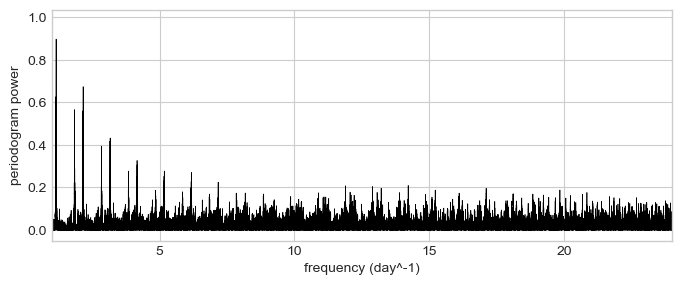

In [186]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(freq, power, '-k', rasterized=True, lw=0.5)
ax.set(xlim=(1, 24),
       xlabel='frequency (day^-1)',
       ylabel='periodogram power');

[0.01       0.01184611 0.01403303 0.01662369 0.0196926  0.02332808
 0.0276347  0.03273637 0.03877987 0.04593906 0.05441992 0.06446644
 0.07636766 0.09046598 0.107167   0.12695121 0.15038781 0.17815107
 0.21103973 0.25      ]
Injected Amplitude: 0.010. FAP of peak: 2.83e-02. Freq: 1.801 day^-1 (Period: 0.56 days)
Injected Amplitude: 0.012. FAP of peak: 3.14e-02. Freq: 1.801 day^-1 (Period: 0.56 days)
Injected Amplitude: 0.014. FAP of peak: 3.58e-02. Freq: 1.801 day^-1 (Period: 0.56 days)
Injected Amplitude: 0.017. FAP of peak: 3.75e-02. Freq: 16.901 day^-1 (Period: 0.06 days)
Injected Amplitude: 0.020. FAP of peak: 4.01e-02. Freq: 16.901 day^-1 (Period: 0.06 days)
Injected Amplitude: 0.023. FAP of peak: 4.45e-02. Freq: 16.901 day^-1 (Period: 0.06 days)
Injected Amplitude: 0.028. FAP of peak: 5.18e-02. Freq: 16.901 day^-1 (Period: 0.06 days)
Injected Amplitude: 0.033. FAP of peak: 1.40e-02. Freq: 2.164 day^-1 (Period: 0.46 days)
Injected Amplitude: 0.039. FAP of peak: 2.01e-03. Freq: 2.1

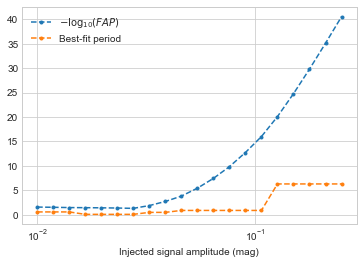

In [7]:
amplitudes = (0.01, 0.1, 1, 10)
amplitudes = np.logspace(-2, np.log10(0.25), 20)
print(amplitudes)

found_period = []
found_fap = []

for amp in amplitudes:
    
    sin_mags = amp * np.sin(times) + mags
    
    ls = LombScargle(times, sin_mags, dy=errs)
    power = ls.power(freq)

    min_freq = 1/100
    power[freq<min_freq] = 0

    fmax = freq[np.nanargmax(power)]
    fap = ls.false_alarm_probability(np.nanmax(power))
    print(f"Injected Amplitude: {amp:.3f}. FAP of peak: {fap:.2e}. Freq: {fmax:.3f} day^-1 (Period: {1. / fmax:.2f} days)")    
    
    found_period.append(1/fmax)
    found_fap.append(fap)
    
plt.plot(amplitudes, -np.log10(found_fap), '.--', label=r'$-\log_{10}(FAP)$')
plt.plot(amplitudes, found_period, '.--', label='Best-fit period')
plt.xlabel("Injected signal amplitude (mag)")
plt.semilogx()
plt.legend()
    


In [8]:
np.median(errs)

0.04999758116900921

In [10]:
from wuvars.data import spreadsheet, photometry
from wuvars.analysis.variability_selection import sq0, sq1, sq2

dat = photometry.group_wserv_v2(photometry.load_wserv_v2(8))
spread = spreadsheet.load_wserv_v2(8)

# wserv_ids = [5, 7, 8, 11]
# n_min_list = [35, 80, 55, 65]
# n_max_list = [90, 160, 80, 100]

n_min = 55
n_max = 80

# min_Stetson_list = [3, 1.6, 1.6, 4]

# SFR_names = ["Orion Nebula Cluster", "NGC 1333", "IC 348", "Mon R2"]
# SFR_dict = {x: y for x, y in zip(wserv_ids, SFR_names)}

q0 = sq0(spread, n_min, n_max)
q1 = sq1(spread, n_min, n_max)
q2 = sq2(spread, n_min, n_max)

Loading WSERV8 photometry data... DONE (elapsed time: 0.20s)


In [11]:
q2_bright = (spread[q2]['mean']['KAPERMAG3'] < 15)
q2_bright_spread = spread[q2][q2_bright]

q2_bright_nonvariable  = (spread[q2]['mean']['KAPERMAG3'] < 15) & (spread[q2]['variability']['Stetson_JHK'] < 0.8) & (spread[q2]['variability']['Stetson_JHK'] > 0.0)
q2_bright_nonvariable_spread = spread[q2][q2_bright_nonvariable]


In [37]:
all_sids = np.unique(q2_bright_spread.index)

all_nonvariable_sids = np.unique(q2_bright_nonvariable_spread.index)

sids = np.random.choice(all_nonvariable_sids, 40)
print(sids)

[44989782486531 44989782503085 44989782490673 44989782443084
 44989782457517 44989782452065 44989782457652 44989782440698
 44989782455572 44989782476994 44989782431382 44989782469734
 44989782426079 44989782508772 44989782486657 44989782508535
 44989782491696 44989782469126 44989782485931 44989782467014
 44989782481381 44989782502476 44989782502799 44989782452423
 44989782506555 44989782432326 44989782494748 44989782451691
 44989782482282 44989782437113 44989782461981 44989782480805
 44989782508701 44989782495569 44989782443205 44989782442771
 44989782430639 44989782464666 44989782494709 44989782487902]


In [15]:
from datetime import datetime

periods6 = [1/23, 1/17, 1/11, 0.1, 1/7, 0.25, 0.307, 0.35, 0.407, 0.45, 0.507, 0.607, 0.707, 0.807, 0.907, 1.0, 1.107, 1.207, 1.3507, 1.5, 1.707, 2, 2.1, 2.207, 2.5, 3.07, 5.07]
amplitudes6 = [0.001, 0.003, 0.005, 0.0075, 0.01, 0.015, 0.02, 0.025, 0.03]

In [315]:
X, Y = np.meshgrid(periods6, amplitudes6)

[]

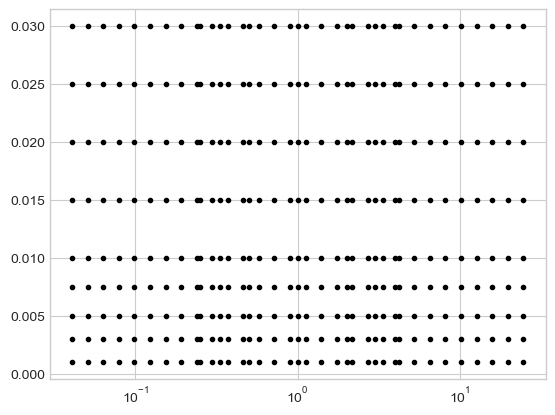

In [331]:
periods7 = np.logspace(np.log10(1/24.5), np.log10(24.5), 30)

extra_periods = (1/4, 1/3, 1/2, 1, 2, 3, 4)

periods7_append_sorted = np.sort(np.append(periods7, np.array(extra_periods)))

X7, Y7 = np.meshgrid(periods7_append_sorted, amplitudes6)

plt.plot(X7, Y7, 'k.')
plt.semilogx()

In [39]:
periods_denser_raw = np.logspace(np.log10(1/24.5), np.log10(24.5), 60)
extra_periods = (1/4, 1/3, 1/2, 1, 2, 3, 4)
periods_denser = np.sort(np.append(periods_denser_raw, np.array(extra_periods)))

amplitudes_denser = [0.001, 0.003, 0.005, 0.0075, 0.0085, 0.01, 0.0125, 0.015, 0.0175, 0.02, 0.025, 0.03]

In [40]:
print(periods_denser)

[ 0.04081633  0.04549088  0.05070078  0.05650736  0.06297895  0.07019171
  0.07823051  0.08718997  0.09717553  0.1083047   0.12070845  0.13453276
  0.14994032  0.16711245  0.18625124  0.20758193  0.23135555  0.25
  0.25785188  0.28738274  0.32029566  0.33333333  0.35697798  0.3978614
  0.44342705  0.49421117  0.5         0.55081142  0.61389389  0.68420097
  0.76256007  0.84989336  0.94722862  1.          1.05571134  1.1766182
  1.3113721   1.46155888  1.62894601  1.8155034   2.          2.02342654
  2.25516238  2.5134381   2.80129322  3.          3.12211536  3.47968011
  3.87819549  4.          4.32235141  4.81737493  5.36909173  5.98399469
  6.6693203   7.43313381  8.28442417  9.23320978 10.29065642 11.46920867
 12.7827363  14.24669759 15.87832114 17.69680874 19.72356124 21.98243049
 24.5       ]


In [110]:
startTime = datetime.now()
print(f"Starting at: {startTime}")
evals_per_sec = 02.14/4
expected_evals = len(sids) * len(periods_denser) * len(amplitudes_denser)
expected_runtime_secs = expected_evals*evals_per_sec
expected_runtime = timedelta(seconds=expected_runtime_secs)
expected_complete_time = startTime + expected_runtime

print(f"About to run {expected_evals} evals")
print(f"Estimated time: {expected_runtime}")
print(f"Estimated completion at: {expected_complete_time.strftime(format='%d/%m/%Y %H:%M:%S')}")

output_denser = recovery_score(dat, sids, periods_denser, amplitudes_denser)

print(f"elapsed time: ", datetime.now() - startTime)


Starting at: 2021-08-22 21:56:27.643841
About to run 32160 evals
Estimated time: 4:46:45.600000
Estimated completion at: 23/08/2021 02:43:13
A=0.00 mag. Incorrect period: 0.06 v. 0.04
A=0.00 mag. Incorrect period: 0.05 v. 0.04
A=0.00 mag. Incorrect period: 0.05 v. 0.04
A=0.00 mag. Incorrect period: 0.11 v. 0.04
A=0.00 mag. Incorrect period: 1.01 v. 0.04
A=0.00 mag. Incorrect period: 0.08 v. 0.04
A=0.00 mag. Incorrect period: 0.50 v. 0.04
A=0.00 mag. Incorrect period: 0.06 v. 0.04
A=0.00 mag. Incorrect period: 0.99 v. 0.04
A=0.00 mag. Incorrect period: 0.05 v. 0.04
A=0.00 mag. Incorrect period: 0.11 v. 0.04
A=0.00 mag. Incorrect period: 0.04 v. 0.04
A=0.00 mag. Incorrect period: 0.50 v. 0.04
A=0.00 mag. Incorrect period: 0.11 v. 0.04
A=0.00 mag. Aliased period: 0.0437 v. 0.0408
A=0.00 mag. Incorrect period: 0.07 v. 0.04
A=0.00 mag. Incorrect period: 1.01 v. 0.04
A=0.00 mag. Incorrect period: 0.05 v. 0.04
A=0.00 mag. Aliased period: 0.1247 v. 0.0408
A=0.00 mag. Incorrect period: 0.20 v. 

A=0.01 mag. Aliased period: 0.0426 v. 0.0408
A=0.01 mag. Aliased period: 0.0426 v. 0.0408
A=0.01 mag. Aliased period: 0.0426 v. 0.0408
A=0.01 mag. Incorrect period: 0.05 v. 0.04
A=0.01 mag. Aliased period: 0.0426 v. 0.0408
A=0.01 mag. Incorrect period: 0.99 v. 0.04
A=0.01 mag. Aliased period: 0.0426 v. 0.0408
A=0.01 mag. Incorrect period: 0.17 v. 0.04
A=0.01 mag. Incorrect period: 1.00 v. 0.04
A=0.01 mag. Aliased period: 0.0426 v. 0.0408
A=0.01 mag. Aliased period: 0.0426 v. 0.0408
A=0.01 mag. Aliased period: 0.0426 v. 0.0408
A=0.01 mag. Incorrect period: 0.42 v. 0.04
A=0.01 mag. Incorrect period: 0.05 v. 0.04
A=0.01 mag. Aliased period: 0.0426 v. 0.0408
A=0.01 mag. Aliased period: 0.0426 v. 0.0408
A=0.01 mag. Aliased period: 0.0426 v. 0.0408
A=0.01 mag. Aliased period: 0.0426 v. 0.0408
A=0.01 mag. Aliased period: 0.0426 v. 0.0408
A=0.01 mag. Aliased period: 0.0426 v. 0.0408
A=0.01 mag. Aliased period: 0.0426 v. 0.0408
A=0.01 mag. Aliased period: 0.0426 v. 0.0408
A=0.01 mag. Aliased pe

A=0.02 mag. Aliased period: 0.0426 v. 0.0408
A=0.02 mag. Aliased period: 0.0426 v. 0.0408
A=0.02 mag. Aliased period: 0.0426 v. 0.0408
A=0.02 mag. Aliased period: 0.0426 v. 0.0408
A=0.02 mag. Aliased period: 0.0426 v. 0.0408
A=0.02 mag. Aliased period: 0.0426 v. 0.0408
A=0.02 mag. Aliased period: 0.0426 v. 0.0408
A=0.02 mag. Aliased period: 0.0426 v. 0.0408
A=0.02 mag. Aliased period: 0.0426 v. 0.0408
A=0.02 mag. Aliased period: 0.0426 v. 0.0408
A=0.02 mag. Aliased period: 0.0426 v. 0.0408
A=0.02 mag. Aliased period: 0.0426 v. 0.0408
A=0.02 mag. Aliased period: 0.0426 v. 0.0408
A=0.02 mag. Aliased period: 0.0426 v. 0.0408
A=0.02 mag. Aliased period: 0.0426 v. 0.0408
A=0.02 mag. Aliased period: 0.0426 v. 0.0408
A=0.02 mag. Aliased period: 0.0426 v. 0.0408
A=0.02 mag. Aliased period: 0.0426 v. 0.0408
A=0.02 mag. Aliased period: 0.0426 v. 0.0408
A=0.02 mag. Aliased period: 0.0426 v. 0.0408
A=0.02 mag. Aliased period: 0.0426 v. 0.0408
A=0.02 mag. Aliased period: 0.0426 v. 0.0408
A=0.02 mag

A=0.00 mag. Incorrect period: 1.01 v. 0.05
A=0.00 mag. Incorrect period: 0.06 v. 0.05
A=0.00 mag. Incorrect period: 0.05 v. 0.05
A=0.00 mag. Aliased period: 0.0928 v. 0.0455
A=0.00 mag. Incorrect period: 0.05 v. 0.05
A=0.00 mag. Aliased period: 0.0435 v. 0.0455
A=0.00 mag. Aliased period: 0.0469 v. 0.0455
A=0.01 mag. Incorrect period: 0.06 v. 0.05
A=0.01 mag. Aliased period: 0.0435 v. 0.0455
A=0.01 mag. Aliased period: 0.0484 v. 0.0455
A=0.01 mag. Incorrect period: 0.11 v. 0.05
A=0.01 mag. Incorrect period: 0.50 v. 0.05
A=0.01 mag. Incorrect period: 0.08 v. 0.05
A=0.01 mag. Aliased period: 0.0500 v. 0.0455
A=0.01 mag. Aliased period: 0.0477 v. 0.0455
A=0.01 mag. Incorrect period: 0.99 v. 0.05
A=0.01 mag. Aliased period: 0.0501 v. 0.0455
A=0.01 mag. Incorrect period: 0.13 v. 0.05
A=0.01 mag. Aliased period: 0.0500 v. 0.0455
A=0.01 mag. Incorrect period: 0.50 v. 0.05
A=0.01 mag. Incorrect period: 0.11 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Incorrect period: 0.17 v. 

A=0.01 mag. Aliased period: 0.0477 v. 0.0455
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Aliased period: 0.0477 v. 0.0455
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Aliased period: 0.0477 v. 0.0455
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Aliased period: 0.0477 v. 0.0455
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Aliased period: 0.0477 v. 0.0455
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Aliased period: 0.0435 v. 0.0455
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Aliased period: 0.0435 v. 0.0455
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0

A=0.03 mag. Correct period: 0.05 v. 0.05
A=0.03 mag. Correct period: 0.05 v. 0.05
A=0.03 mag. Correct period: 0.05 v. 0.05
A=0.03 mag. Correct period: 0.05 v. 0.05
A=0.03 mag. Correct period: 0.05 v. 0.05
A=0.03 mag. Correct period: 0.05 v. 0.05
A=0.03 mag. Correct period: 0.05 v. 0.05
A=0.03 mag. Correct period: 0.05 v. 0.05
A=0.03 mag. Aliased period: 0.0477 v. 0.0455
A=0.03 mag. Correct period: 0.05 v. 0.05
A=0.03 mag. Correct period: 0.05 v. 0.05
A=0.03 mag. Correct period: 0.05 v. 0.05
A=0.03 mag. Correct period: 0.05 v. 0.05
A=0.03 mag. Correct period: 0.05 v. 0.05
A=0.03 mag. Correct period: 0.05 v. 0.05
A=0.03 mag. Correct period: 0.05 v. 0.05
A=0.03 mag. Correct period: 0.05 v. 0.05
A=0.03 mag. Correct period: 0.05 v. 0.05
A=0.00 mag. Incorrect period: 0.06 v. 0.05
A=0.00 mag. Correct period: 0.05 v. 0.05
A=0.00 mag. Aliased period: 0.0484 v. 0.0507
A=0.00 mag. Incorrect period: 0.06 v. 0.05
A=0.00 mag. Incorrect period: 1.01 v. 0.05
A=0.00 mag. Incorrect period: 0.08 v. 0.05


A=0.01 mag. Aliased period: 0.1540 v. 0.0507
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Aliased period: 0.0482 v. 0.0507
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Aliased period: 0.0482 v. 0.0507
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Aliased period: 0.0483 v. 0.0507
A=0.01 mag. Aliased period: 0.0482 v. 0.0507
A=0.01 mag. Incorrect period: 0.05 v. 0.05
A=0.01 mag. Incorrect period: 0.17 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Incorrect period: 0.04 v. 0.05
A=0.01 mag. Aliased period: 0.1542 v. 0.0507
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Incorrect period: 0.06 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Aliased period: 0.0482 v. 0.0507
A=0.01 mag. Incorrect period: 0.16 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct period: 0.05 v. 0.05
A=0.01 mag. Correct

A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Aliased period: 0.0564 v. 0.0507
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. Correct period: 0.05 v. 0.05
A=0.02 mag. 

A=0.01 mag. Aliased period: 0.0637 v. 0.0565
A=0.01 mag. Aliased period: 0.0637 v. 0.0565
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Incorrect period: 0.99 v. 0.06
A=0.01 mag. Aliased period: 0.0501 v. 0.0565
A=0.01 mag. Incorrect period: 0.04 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Aliased period: 0.0530 v. 0.0565
A=0.01 mag. Incorrect period: 0.07 v. 0.06
A=0.01 mag. Aliased period: 0.0535 v. 0.0565
A=0.01 mag. Aliased period: 0.0599 v. 0.0565
A=0.01 mag. Incorrect period: 0.12 v. 0.06
A=0.01 mag. Incorrect period: 0.20 v. 0.06
A=0.01 mag. Incorrect period: 0.12 v. 0.06
A=0.01 mag. Aliased period: 0.0508 v. 0.0565
A=0.01 mag. Incorrect period: 0.05 v. 0.06
A=0.01 mag. Aliased period: 0.0606 v. 0.0565
A=0.01 mag. Incorrect period: 33.78 v. 0.06
A=0.01 mag. Incorrect period: 7.46 v. 0.06
A=0.01 mag. Aliased period: 0.0627 v. 0.0565
A=0.01 mag. Incorrect period: 0.09 v. 0.06


A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Aliased period: 0.0599 v. 0.0565
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Aliased period: 0.0535 v. 0.0565
A=0.01 m

A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.00 mag. Aliased period: 0.0596 v. 0.0630
A=0.00 mag. Incorrect period: 0.05 v. 0.06
A=0.00 mag. Incorrect period: 0.05 v. 0.06
A=0.00 mag. Incorrect period: 0.06 v. 0.06
A=0.00 mag. Incorrect period: 1.01 v. 0.06
A=0.00 mag. Incorrect period: 0.08 v. 0.06
A=0.00 mag. Incorrect period: 0.50 v. 0.06
A=0.00 mag. Aliased period: 0.0554 v. 0.0630
A=0.00 mag. Incorrect period: 0.99 v. 0.06
A=0.00 mag. Incorrect period: 0.05 v. 0.06
A=0.00 mag. Incorrect period: 0.11 v. 0.06
A=0.00 mag. Incorrect period: 0.04 v. 0.06
A=0.00 mag. Incorrect period: 0.05 v. 0.06
A=0.00 mag. Incorrect period: 0.11 v. 0.06
A=0.00 mag. Incorrect period: 0.05 v. 0.06
A=0.00 mag. Aliased period: 0.0707 v. 0.0630
A=0.00 mag. Incorrect period: 1.01 v. 0.06
A=0.00 mag. Incorrect period: 3.51 v. 0.06
A=0.00 mag. Aliased period: 0.1247 v. 0.0630
A=0.00 mag.

A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Aliased period: 0.0672 v. 0.0630
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Incorrect period: 0.17 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Incorrect period: 0.17 v. 0.06
A=0.01 mag. Incorrect period: 0.98 v. 0.06
A=0.01 mag. Aliased period: 0.0672 v. 0.0630
A=0.01 mag. Incorrect period: 0.07 v. 0.06
A=0.01 mag. Aliased period: 0.0672 v. 0.0630
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Incorrect period: 0.05 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Aliased period: 0.0592 v. 0.0630
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Aliased period: 0.0592 v. 0.0630
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Correct period: 0.06 v. 0.06
A=0.01 mag. Incorrect period: 0.05 v. 0.06
A=0.01 mag. Aliased perio

A=0.02 mag. Correct period: 0.06 v. 0.06
A=0.02 mag. Correct period: 0.06 v. 0.06
A=0.02 mag. Correct period: 0.06 v. 0.06
A=0.02 mag. Correct period: 0.06 v. 0.06
A=0.02 mag. Correct period: 0.06 v. 0.06
A=0.02 mag. Correct period: 0.06 v. 0.06
A=0.02 mag. Correct period: 0.06 v. 0.06
A=0.02 mag. Aliased period: 0.0672 v. 0.0630
A=0.02 mag. Correct period: 0.06 v. 0.06
A=0.02 mag. Correct period: 0.06 v. 0.06
A=0.02 mag. Correct period: 0.06 v. 0.06
A=0.02 mag. Correct period: 0.06 v. 0.06
A=0.02 mag. Correct period: 0.06 v. 0.06
A=0.02 mag. Correct period: 0.06 v. 0.06
A=0.02 mag. Correct period: 0.06 v. 0.06
A=0.02 mag. Correct period: 0.06 v. 0.06
A=0.02 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. Correct period: 0.06 v. 0.06
A=0.03 mag. 

A=0.01 mag. Incorrect period: 0.12 v. 0.07
A=0.01 mag. Incorrect period: 0.20 v. 0.07
A=0.01 mag. Aliased period: 0.0656 v. 0.0702
A=0.01 mag. Incorrect period: 0.05 v. 0.07
A=0.01 mag. Incorrect period: 0.05 v. 0.07
A=0.01 mag. Incorrect period: 0.05 v. 0.07
A=0.01 mag. Incorrect period: 0.05 v. 0.07
A=0.01 mag. Aliased period: 0.0625 v. 0.0702
A=0.01 mag. Incorrect period: 0.13 v. 0.07
A=0.01 mag. Correct period: 0.07 v. 0.07
A=0.01 mag. Aliased period: 0.0656 v. 0.0702
A=0.01 mag. Incorrect period: 0.33 v. 0.07
A=0.01 mag. Correct period: 0.07 v. 0.07
A=0.01 mag. Aliased period: 0.0656 v. 0.0702
A=0.01 mag. Incorrect period: 0.20 v. 0.07
A=0.01 mag. Incorrect period: 0.40 v. 0.07
A=0.01 mag. Incorrect period: 0.05 v. 0.07
A=0.01 mag. Incorrect period: 0.05 v. 0.07
A=0.01 mag. Aliased period: 0.0656 v. 0.0702
A=0.01 mag. Incorrect period: 0.05 v. 0.07
A=0.01 mag. Incorrect period: 0.05 v. 0.07
A=0.01 mag. Incorrect period: 0.16 v. 0.07
A=0.01 mag. Incorrect period: 0.06 v. 0.07
A=0.0

A=0.01 mag. Aliased period: 0.0656 v. 0.0702
A=0.01 mag. Correct period: 0.07 v. 0.07
A=0.01 mag. Aliased period: 0.0656 v. 0.0702
A=0.01 mag. Aliased period: 0.0755 v. 0.0702
A=0.01 mag. Correct period: 0.07 v. 0.07
A=0.01 mag. Aliased period: 0.0755 v. 0.0702
A=0.01 mag. Correct period: 0.07 v. 0.07
A=0.01 mag. Aliased period: 0.0656 v. 0.0702
A=0.01 mag. Aliased period: 0.0755 v. 0.0702
A=0.01 mag. Correct period: 0.07 v. 0.07
A=0.01 mag. Correct period: 0.07 v. 0.07
A=0.01 mag. Correct period: 0.07 v. 0.07
A=0.01 mag. Aliased period: 0.0656 v. 0.0702
A=0.01 mag. Correct period: 0.07 v. 0.07
A=0.01 mag. Correct period: 0.07 v. 0.07
A=0.01 mag. Correct period: 0.07 v. 0.07
A=0.01 mag. Aliased period: 0.0656 v. 0.0702
A=0.01 mag. Correct period: 0.07 v. 0.07
A=0.01 mag. Correct period: 0.07 v. 0.07
A=0.01 mag. Correct period: 0.07 v. 0.07
A=0.01 mag. Correct period: 0.07 v. 0.07
A=0.01 mag. Correct period: 0.07 v. 0.07
A=0.01 mag. Correct period: 0.07 v. 0.07
A=0.01 mag. Correct perio

A=0.00 mag. Correct period: 0.08 v. 0.08
A=0.00 mag. Incorrect period: 0.50 v. 0.08
A=0.00 mag. Incorrect period: 0.06 v. 0.08
A=0.00 mag. Incorrect period: 0.99 v. 0.08
A=0.00 mag. Incorrect period: 0.05 v. 0.08
A=0.00 mag. Incorrect period: 0.11 v. 0.08
A=0.00 mag. Incorrect period: 0.04 v. 0.08
A=0.00 mag. Incorrect period: 0.05 v. 0.08
A=0.00 mag. Incorrect period: 0.11 v. 0.08
A=0.00 mag. Incorrect period: 0.04 v. 0.08
A=0.00 mag. Incorrect period: 0.07 v. 0.08
A=0.00 mag. Incorrect period: 1.01 v. 0.08
A=0.00 mag. Incorrect period: 0.06 v. 0.08
A=0.00 mag. Incorrect period: 0.12 v. 0.08
A=0.00 mag. Incorrect period: 0.20 v. 0.08
A=0.00 mag. Incorrect period: 0.83 v. 0.08
A=0.00 mag. Incorrect period: 0.25 v. 0.08
A=0.00 mag. Incorrect period: 0.05 v. 0.08
A=0.00 mag. Incorrect period: 0.19 v. 0.08
A=0.00 mag. Incorrect period: 34.01 v. 0.08
A=0.00 mag. Incorrect period: 7.46 v. 0.08
A=0.00 mag. Incorrect period: 0.44 v. 0.08
A=0.00 mag. Incorrect period: 0.04 v. 0.08
A=0.00 mag. 

A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Aliased period: 0.0849 v. 0.0782
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Incorrect period: 0.04 v. 0.08
A=0.01 mag. Aliased period: 0.0849 v. 0.0782
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Aliased period: 0.0849 v. 0.0782
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Incorrect period: 0.05 v. 0.08
A=0.01 mag. Incorrect period: 4.97 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Aliased period: 0.0849 v. 0.0782
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Aliased period: 0.0849 v. 0.0782
A=0.01 mag. Correct period: 0.08 v. 0.08
A=0.01 mag. Incorrect period: 0.12 v. 0.08
A=0.01 mag. Correct period: 0

A=0.02 mag. Correct period: 0.08 v. 0.08
A=0.02 mag. Correct period: 0.08 v. 0.08
A=0.02 mag. Correct period: 0.08 v. 0.08
A=0.02 mag. Correct period: 0.08 v. 0.08
A=0.02 mag. Correct period: 0.08 v. 0.08
A=0.02 mag. Correct period: 0.08 v. 0.08
A=0.02 mag. Correct period: 0.08 v. 0.08
A=0.03 mag. Correct period: 0.08 v. 0.08
A=0.03 mag. Correct period: 0.08 v. 0.08
A=0.03 mag. Correct period: 0.08 v. 0.08
A=0.03 mag. Correct period: 0.08 v. 0.08
A=0.03 mag. Correct period: 0.08 v. 0.08
A=0.03 mag. Correct period: 0.08 v. 0.08
A=0.03 mag. Correct period: 0.08 v. 0.08
A=0.03 mag. Correct period: 0.08 v. 0.08
A=0.03 mag. Correct period: 0.08 v. 0.08
A=0.03 mag. Correct period: 0.08 v. 0.08
A=0.03 mag. Correct period: 0.08 v. 0.08
A=0.03 mag. Correct period: 0.08 v. 0.08
A=0.03 mag. Correct period: 0.08 v. 0.08
A=0.03 mag. Correct period: 0.08 v. 0.08
A=0.03 mag. Correct period: 0.08 v. 0.08
A=0.03 mag. Correct period: 0.08 v. 0.08
A=0.03 mag. Correct period: 0.08 v. 0.08
A=0.03 mag. Corr

A=0.01 mag. Incorrect period: 0.04 v. 0.09
A=0.01 mag. Incorrect period: 0.33 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Incorrect period: 0.08 v. 0.09
A=0.01 mag. Aliased period: 0.0955 v. 0.0872
A=0.01 mag. Incorrect period: 0.20 v. 0.09
A=0.01 mag. Incorrect period: 50.50 v. 0.09
A=0.01 mag. Incorrect period: 0.06 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Aliased period: 0.0955 v. 0.0872
A=0.01 mag. Incorrect period: 0.05 v. 0.09
A=0.01 mag. Incorrect period: 0.17 v. 0.09
A=0.01 mag. Incorrect period: 0.06 v. 0.09
A=0.01 mag. Aliased period: 0.0802 v. 0.0872
A=0.01 mag. Aliased period: 0.0955 v. 0.0872
A=0.01 mag. Aliased period: 0.0953 v. 0.0872
A=0.01 mag. Aliased period: 0.0955 v. 0.0872
A=0.01 mag. Aliased period: 0.0955 v. 0.0872
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Aliased period: 0.0804 v. 0.0872
A=0.01 mag. Aliased period: 0.0940 v. 0.0872
A=0.01 mag. Incorrect period: 0.05 v. 0.09


A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Aliased period: 0.0802 v. 0.0872
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Aliased period: 0.0955 v. 0.0872
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Aliased period: 0.0955 v. 0.0872
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Aliased period: 0.0802 v. 0.0872
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Aliased period: 0.0955 v. 0.0872
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.01 mag. Correct period: 0.09 v. 0.09
A=0.02 mag. Correct period: 0.09 v. 0.09
A=0.02 mag. Correct period: 0.09 v. 0.09
A=0.02 mag. Correct period: 0.09 v. 0

A=0.00 mag. Aliased period: 0.1065 v. 0.0972
A=0.00 mag. Incorrect period: 0.12 v. 0.10
A=0.00 mag. Incorrect period: 0.20 v. 0.10
A=0.00 mag. Incorrect period: 0.83 v. 0.10
A=0.00 mag. Incorrect period: 0.25 v. 0.10
A=0.00 mag. Incorrect period: 0.05 v. 0.10
A=0.00 mag. Incorrect period: 0.17 v. 0.10
A=0.00 mag. Incorrect period: 34.13 v. 0.10
A=0.00 mag. Incorrect period: 7.46 v. 0.10
A=0.00 mag. Incorrect period: 0.44 v. 0.10
A=0.00 mag. Incorrect period: 0.04 v. 0.10
A=0.00 mag. Incorrect period: 0.06 v. 0.10
A=0.00 mag. Incorrect period: 1.00 v. 0.10
A=0.00 mag. Incorrect period: 0.07 v. 0.10
A=0.00 mag. Incorrect period: 0.08 v. 0.10
A=0.00 mag. Incorrect period: 0.20 v. 0.10
A=0.00 mag. Incorrect period: 0.40 v. 0.10
A=0.00 mag. Incorrect period: 0.06 v. 0.10
A=0.00 mag. Incorrect period: 0.05 v. 0.10
A=0.00 mag. Incorrect period: 0.51 v. 0.10
A=0.00 mag. Aliased period: 0.0478 v. 0.0972
A=0.00 mag. Incorrect period: 0.06 v. 0.10
A=0.00 mag. Incorrect period: 0.06 v. 0.10
A=0.00

A=0.01 mag. Correct period: 0.10 v. 0.10
A=0.01 mag. Correct period: 0.10 v. 0.10
A=0.01 mag. Aliased period: 0.0885 v. 0.0972
A=0.01 mag. Correct period: 0.10 v. 0.10
A=0.01 mag. Correct period: 0.10 v. 0.10
A=0.01 mag. Aliased period: 0.0886 v. 0.0972
A=0.01 mag. Correct period: 0.10 v. 0.10
A=0.01 mag. Correct period: 0.10 v. 0.10
A=0.01 mag. Aliased period: 0.0885 v. 0.0972
A=0.01 mag. Correct period: 0.10 v. 0.10
A=0.01 mag. Incorrect period: 0.12 v. 0.10
A=0.01 mag. Correct period: 0.10 v. 0.10
A=0.01 mag. Correct period: 0.10 v. 0.10
A=0.01 mag. Aliased period: 0.0885 v. 0.0972
A=0.01 mag. Correct period: 0.10 v. 0.10
A=0.01 mag. Aliased period: 0.0886 v. 0.0972
A=0.01 mag. Correct period: 0.10 v. 0.10
A=0.01 mag. Correct period: 0.10 v. 0.10
A=0.01 mag. Aliased period: 0.0886 v. 0.0972
A=0.01 mag. Correct period: 0.10 v. 0.10
A=0.01 mag. Correct period: 0.10 v. 0.10
A=0.01 mag. Correct period: 0.10 v. 0.10
A=0.01 mag. Incorrect period: 0.14 v. 0.10
A=0.01 mag. Correct period: 0

A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Aliased period: 0.0886 v. 0.0972
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Aliased period: 0.0885 v. 0.0972
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 mag. Correct period: 0.10 v. 0.10
A=0.03 m

A=0.01 mag. Aliased period: 0.1383 v. 0.1083
A=0.01 mag. Incorrect period: 0.06 v. 0.11
A=0.01 mag. Aliased period: 0.1215 v. 0.1083
A=0.01 mag. Incorrect period: 0.05 v. 0.11
A=0.01 mag. Aliased period: 0.1215 v. 0.1083
A=0.01 mag. Correct period: 0.11 v. 0.11
A=0.01 mag. Aliased period: 0.1215 v. 0.1083
A=0.01 mag. Correct period: 0.11 v. 0.11
A=0.01 mag. Correct period: 0.11 v. 0.11
A=0.01 mag. Aliased period: 0.0980 v. 0.1083
A=0.01 mag. Incorrect period: 0.05 v. 0.11
A=0.01 mag. Aliased period: 0.1215 v. 0.1083
A=0.01 mag. Correct period: 0.11 v. 0.11
A=0.01 mag. Aliased period: 0.1383 v. 0.1083
A=0.01 mag. Aliased period: 0.1235 v. 0.1083
A=0.01 mag. Correct period: 0.11 v. 0.11
A=0.01 mag. Aliased period: 0.0977 v. 0.1083
A=0.01 mag. Aliased period: 0.1215 v. 0.1083
A=0.01 mag. Correct period: 0.11 v. 0.11
A=0.01 mag. Incorrect period: 0.12 v. 0.11
A=0.01 mag. Correct period: 0.11 v. 0.11
A=0.01 mag. Aliased period: 0.0977 v. 0.1083
A=0.01 mag. Aliased period: 0.0977 v. 0.1083
A

A=0.01 mag. Aliased period: 0.1215 v. 0.1083
A=0.01 mag. Aliased period: 0.1215 v. 0.1083
A=0.01 mag. Correct period: 0.11 v. 0.11
A=0.01 mag. Correct period: 0.11 v. 0.11
A=0.01 mag. Correct period: 0.11 v. 0.11
A=0.01 mag. Aliased period: 0.1215 v. 0.1083
A=0.01 mag. Correct period: 0.11 v. 0.11
A=0.01 mag. Aliased period: 0.1215 v. 0.1083
A=0.02 mag. Aliased period: 0.0977 v. 0.1083
A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Aliased period: 0.0977 v. 0.1083
A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Correct period: 0.11 v. 0.11
A=0.02 mag. Aliased period: 0.097

A=0.00 mag. Incorrect period: 1.00 v. 0.12
A=0.00 mag. Incorrect period: 0.07 v. 0.12
A=0.00 mag. Aliased period: 0.1368 v. 0.1207
A=0.00 mag. Incorrect period: 0.20 v. 0.12
A=0.00 mag. Incorrect period: 0.40 v. 0.12
A=0.00 mag. Incorrect period: 0.06 v. 0.12
A=0.00 mag. Incorrect period: 0.05 v. 0.12
A=0.00 mag. Incorrect period: 0.52 v. 0.12
A=0.00 mag. Incorrect period: 0.05 v. 0.12
A=0.00 mag. Aliased period: 0.0593 v. 0.1207
A=0.00 mag. Incorrect period: 0.06 v. 0.12
A=0.00 mag. Incorrect period: 0.04 v. 0.12
A=0.00 mag. Incorrect period: 0.05 v. 0.12
A=0.00 mag. Incorrect period: 0.05 v. 0.12
A=0.00 mag. Aliased period: 0.1056 v. 0.1207
A=0.00 mag. Incorrect period: 0.50 v. 0.12
A=0.00 mag. Incorrect period: 0.08 v. 0.12
A=0.00 mag. Incorrect period: 0.33 v. 0.12
A=0.00 mag. Incorrect period: 0.06 v. 0.12
A=0.00 mag. Incorrect period: 0.99 v. 0.12
A=0.00 mag. Incorrect period: 0.05 v. 0.12
A=0.00 mag. Aliased period: 0.1071 v. 0.1207
A=0.00 mag. Incorrect period: 0.05 v. 0.12
A=0

A=0.01 mag. Aliased period: 0.1077 v. 0.1207
A=0.01 mag. Aliased period: 0.0972 v. 0.1207
A=0.01 mag. Aliased period: 0.1077 v. 0.1207
A=0.01 mag. Aliased period: 0.1077 v. 0.1207
A=0.01 mag. Aliased period: 0.1077 v. 0.1207
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Aliased period: 0.1077 v. 0.1207
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Incorrect period: 0.08 v. 0.12
A=0.01 mag. Aliased period: 0.1373 v. 0.1207
A=0.01 mag. Aliased period: 0.1077 v. 0.1207
A=0.01 mag. Aliased period: 0.1077 v. 0.1207
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Aliased period: 0.1077 v. 0.1207
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Aliased period: 0.1077 v. 0.1207
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag. Correct period: 0.12 v. 0.12
A=0.01 mag.

A=0.03 mag. Correct period: 0.12 v. 0.12
A=0.03 mag. Correct period: 0.12 v. 0.12
A=0.03 mag. Correct period: 0.12 v. 0.12
A=0.03 mag. Correct period: 0.12 v. 0.12
A=0.03 mag. Correct period: 0.12 v. 0.12
A=0.03 mag. Aliased period: 0.1077 v. 0.1207
A=0.03 mag. Correct period: 0.12 v. 0.12
A=0.03 mag. Correct period: 0.12 v. 0.12
A=0.03 mag. Correct period: 0.12 v. 0.12
A=0.03 mag. Correct period: 0.12 v. 0.12
A=0.03 mag. Correct period: 0.12 v. 0.12
A=0.03 mag. Correct period: 0.12 v. 0.12
A=0.03 mag. Correct period: 0.12 v. 0.12
A=0.03 mag. Correct period: 0.12 v. 0.12
A=0.03 mag. Correct period: 0.12 v. 0.12
A=0.03 mag. Correct period: 0.12 v. 0.12
A=0.03 mag. Correct period: 0.12 v. 0.12
A=0.03 mag. Correct period: 0.12 v. 0.12
A=0.03 mag. Correct period: 0.12 v. 0.12
A=0.03 mag. Correct period: 0.12 v. 0.12
A=0.03 mag. Correct period: 0.12 v. 0.12
A=0.03 mag. Correct period: 0.12 v. 0.12
A=0.03 mag. Correct period: 0.12 v. 0.12
A=0.03 mag. Correct period: 0.12 v. 0.12
A=0.03 mag. 

A=0.01 mag. Aliased period: 0.1555 v. 0.1345
A=0.01 mag. Correct period: 0.13 v. 0.13
A=0.01 mag. Incorrect period: 0.11 v. 0.13
A=0.01 mag. Correct period: 0.13 v. 0.13
A=0.01 mag. Incorrect period: 0.08 v. 0.13
A=0.01 mag. Correct period: 0.13 v. 0.13
A=0.01 mag. Correct period: 0.13 v. 0.13
A=0.01 mag. Incorrect period: 0.07 v. 0.13
A=0.01 mag. Aliased period: 0.1186 v. 0.1345
A=0.01 mag. Aliased period: 0.1185 v. 0.1345
A=0.01 mag. Correct period: 0.13 v. 0.13
A=0.01 mag. Incorrect period: 0.05 v. 0.13
A=0.01 mag. Incorrect period: 0.04 v. 0.13
A=0.01 mag. Incorrect period: 1.03 v. 0.13
A=0.01 mag. Incorrect period: 0.14 v. 0.13
A=0.01 mag. Correct period: 0.13 v. 0.13
A=0.01 mag. Incorrect period: 0.08 v. 0.13
A=0.01 mag. Aliased period: 0.0446 v. 0.1345
A=0.01 mag. Correct period: 0.13 v. 0.13
A=0.01 mag. Incorrect period: 0.07 v. 0.13
A=0.01 mag. Aliased period: 0.1555 v. 0.1345
A=0.01 mag. Incorrect period: 0.20 v. 0.13
A=0.01 mag. Aliased period: 0.1555 v. 0.1345
A=0.01 mag. A

A=0.02 mag. Correct period: 0.13 v. 0.13
A=0.02 mag. Correct period: 0.13 v. 0.13
A=0.02 mag. Correct period: 0.13 v. 0.13
A=0.02 mag. Correct period: 0.13 v. 0.13
A=0.02 mag. Correct period: 0.13 v. 0.13
A=0.02 mag. Correct period: 0.13 v. 0.13
A=0.02 mag. Correct period: 0.13 v. 0.13
A=0.02 mag. Correct period: 0.13 v. 0.13
A=0.02 mag. Correct period: 0.13 v. 0.13
A=0.02 mag. Correct period: 0.13 v. 0.13
A=0.02 mag. Correct period: 0.13 v. 0.13
A=0.02 mag. Correct period: 0.13 v. 0.13
A=0.02 mag. Correct period: 0.13 v. 0.13
A=0.02 mag. Aliased period: 0.1185 v. 0.1345
A=0.02 mag. Aliased period: 0.1186 v. 0.1345
A=0.02 mag. Correct period: 0.13 v. 0.13
A=0.02 mag. Correct period: 0.13 v. 0.13
A=0.02 mag. Aliased period: 0.1555 v. 0.1345
A=0.02 mag. Correct period: 0.13 v. 0.13
A=0.02 mag. Correct period: 0.13 v. 0.13
A=0.02 mag. Correct period: 0.13 v. 0.13
A=0.02 mag. Correct period: 0.13 v. 0.13
A=0.02 mag. Correct period: 0.13 v. 0.13
A=0.02 mag. Correct period: 0.13 v. 0.13
A=0.

A=0.00 mag. Incorrect period: 0.04 v. 0.15
A=0.00 mag. Incorrect period: 0.08 v. 0.15
A=0.00 mag. Incorrect period: 1.01 v. 0.15
A=0.00 mag. Incorrect period: 0.17 v. 0.15
A=0.00 mag. Incorrect period: 0.50 v. 0.15
A=0.00 mag. Incorrect period: 0.04 v. 0.15
A=0.00 mag. Incorrect period: 0.99 v. 0.15
A=0.00 mag. Aliased period: 0.0501 v. 0.1499
A=0.00 mag. Incorrect period: 0.11 v. 0.15
A=0.00 mag. Incorrect period: 0.04 v. 0.15
A=0.00 mag. Incorrect period: 0.05 v. 0.15
A=0.00 mag. Incorrect period: 0.11 v. 0.15
A=0.00 mag. Incorrect period: 0.07 v. 0.15
A=0.00 mag. Incorrect period: 0.07 v. 0.15
A=0.00 mag. Incorrect period: 0.05 v. 0.15
A=0.00 mag. Incorrect period: 0.11 v. 0.15
A=0.00 mag. Incorrect period: 0.12 v. 0.15
A=0.00 mag. Incorrect period: 0.20 v. 0.15
A=0.00 mag. Incorrect period: 0.83 v. 0.15
A=0.00 mag. Incorrect period: 0.25 v. 0.15
A=0.00 mag. Incorrect period: 0.05 v. 0.15
A=0.00 mag. Incorrect period: 0.17 v. 0.15
A=0.00 mag. Aliased period: 0.0502 v. 0.1499
A=0.00 

A=0.01 mag. Incorrect period: 0.04 v. 0.15
A=0.01 mag. Correct period: 0.15 v. 0.15
A=0.01 mag. Correct period: 0.15 v. 0.15
A=0.01 mag. Correct period: 0.15 v. 0.15
A=0.01 mag. Correct period: 0.15 v. 0.15
A=0.01 mag. Incorrect period: 0.04 v. 0.15
A=0.01 mag. Correct period: 0.15 v. 0.15
A=0.01 mag. Correct period: 0.15 v. 0.15
A=0.01 mag. Correct period: 0.15 v. 0.15
A=0.01 mag. Correct period: 0.15 v. 0.15
A=0.01 mag. Correct period: 0.15 v. 0.15
A=0.01 mag. Correct period: 0.15 v. 0.15
A=0.01 mag. Correct period: 0.15 v. 0.15
A=0.01 mag. Correct period: 0.15 v. 0.15
A=0.01 mag. Correct period: 0.15 v. 0.15
A=0.01 mag. Aliased period: 0.1765 v. 0.1499
A=0.01 mag. Correct period: 0.15 v. 0.15
A=0.01 mag. Correct period: 0.15 v. 0.15
A=0.01 mag. Aliased period: 0.1764 v. 0.1499
A=0.01 mag. Correct period: 0.15 v. 0.15
A=0.01 mag. Correct period: 0.15 v. 0.15
A=0.01 mag. Correct period: 0.15 v. 0.15
A=0.01 mag. Correct period: 0.15 v. 0.15
A=0.01 mag. Aliased period: 0.1304 v. 0.1499


A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Correct period: 0.15 v. 0.15
A=0.03 mag. Corr

A=0.01 mag. Incorrect period: 0.10 v. 0.17
A=0.01 mag. Incorrect period: 1.27 v. 0.17
A=0.01 mag. Aliased period: 0.1431 v. 0.1671
A=0.01 mag. Incorrect period: 1.00 v. 0.17
A=0.01 mag. Aliased period: 0.1431 v. 0.1671
A=0.01 mag. Aliased period: 0.1431 v. 0.1671
A=0.01 mag. Aliased period: 0.1431 v. 0.1671
A=0.01 mag. Incorrect period: 0.07 v. 0.17
A=0.01 mag. Correct period: 0.17 v. 0.17
A=0.01 mag. Correct period: 0.17 v. 0.17
A=0.01 mag. Aliased period: 0.5009 v. 0.1671
A=0.01 mag. Incorrect period: 0.06 v. 0.17
A=0.01 mag. Incorrect period: 0.05 v. 0.17
A=0.01 mag. Correct period: 0.17 v. 0.17
A=0.01 mag. Aliased period: 0.2008 v. 0.1671
A=0.01 mag. Aliased period: 0.2007 v. 0.1671
A=0.01 mag. Correct period: 0.17 v. 0.17
A=0.01 mag. Aliased period: 0.0549 v. 0.1671
A=0.01 mag. Aliased period: 0.1431 v. 0.1671
A=0.01 mag. Incorrect period: 0.04 v. 0.17
A=0.01 mag. Aliased period: 0.2007 v. 0.1671
A=0.01 mag. Correct period: 0.17 v. 0.17
A=0.01 mag. Correct period: 0.17 v. 0.17
A=0

A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Aliased period: 0.1431 v. 0.1671
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. Correct period: 0.17 v. 0.17
A=0.02 mag. 

A=0.00 mag. Incorrect period: 0.05 v. 0.19
A=0.00 mag. Incorrect period: 0.07 v. 0.19
A=0.00 mag. Correct period: 0.19 v. 0.19
A=0.00 mag. Incorrect period: 3.51 v. 0.19
A=0.00 mag. Incorrect period: 0.12 v. 0.19
A=0.00 mag. Incorrect period: 0.05 v. 0.19
A=0.00 mag. Incorrect period: 0.12 v. 0.19
A=0.00 mag. Incorrect period: 0.99 v. 0.19
A=0.00 mag. Incorrect period: 0.05 v. 0.19
A=0.00 mag. Incorrect period: 0.17 v. 0.19
A=0.00 mag. Incorrect period: 34.36 v. 0.19
A=0.00 mag. Incorrect period: 7.46 v. 0.19
A=0.00 mag. Incorrect period: 0.44 v. 0.19
A=0.00 mag. Incorrect period: 0.05 v. 0.19
A=0.00 mag. Incorrect period: 0.05 v. 0.19
A=0.00 mag. Incorrect period: 1.00 v. 0.19
A=0.00 mag. Incorrect period: 0.08 v. 0.19
A=0.00 mag. Incorrect period: 0.04 v. 0.19
A=0.00 mag. Incorrect period: 0.20 v. 0.19
A=0.00 mag. Incorrect period: 0.40 v. 0.19
A=0.00 mag. Incorrect period: 0.05 v. 0.19
A=0.00 mag. Incorrect period: 0.05 v. 0.19
A=0.00 mag. Incorrect period: 0.04 v. 0.19
A=0.00 mag. 

A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Aliased period: 0.1569 v. 0.1863
A=0.01 mag. Incorrect period: 0.05 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Aliased period: 0.1569 v. 0.1863
A=0.01 mag. Correct period: 0.19 v. 0.19
A=0.01 mag. Incorrect period: 0.08 v. 0.19
A=0.

A=0.03 mag. Correct period: 0.19 v. 0.19
A=0.03 mag. Correct period: 0.19 v. 0.19
A=0.03 mag. Correct period: 0.19 v. 0.19
A=0.03 mag. Correct period: 0.19 v. 0.19
A=0.03 mag. Correct period: 0.19 v. 0.19
A=0.03 mag. Correct period: 0.19 v. 0.19
A=0.03 mag. Correct period: 0.19 v. 0.19
A=0.03 mag. Correct period: 0.19 v. 0.19
A=0.03 mag. Correct period: 0.19 v. 0.19
A=0.03 mag. Correct period: 0.19 v. 0.19
A=0.03 mag. Correct period: 0.19 v. 0.19
A=0.03 mag. Correct period: 0.19 v. 0.19
A=0.03 mag. Correct period: 0.19 v. 0.19
A=0.03 mag. Correct period: 0.19 v. 0.19
A=0.03 mag. Correct period: 0.19 v. 0.19
A=0.03 mag. Correct period: 0.19 v. 0.19
A=0.03 mag. Correct period: 0.19 v. 0.19
A=0.03 mag. Correct period: 0.19 v. 0.19
A=0.03 mag. Correct period: 0.19 v. 0.19
A=0.03 mag. Correct period: 0.19 v. 0.19
A=0.03 mag. Correct period: 0.19 v. 0.19
A=0.03 mag. Correct period: 0.19 v. 0.19
A=0.03 mag. Correct period: 0.19 v. 0.19
A=0.03 mag. Correct period: 0.19 v. 0.19
A=0.03 mag. Corr

A=0.01 mag. Incorrect period: 0.52 v. 0.21
A=0.01 mag. Incorrect period: 0.06 v. 0.21
A=0.01 mag. Incorrect period: 0.04 v. 0.21
A=0.01 mag. Aliased period: 0.1718 v. 0.2076
A=0.01 mag. Correct period: 0.21 v. 0.21
A=0.01 mag. Correct period: 0.21 v. 0.21
A=0.01 mag. Correct period: 0.21 v. 0.21
A=0.01 mag. Aliased period: 0.2622 v. 0.2076
A=0.01 mag. Correct period: 0.21 v. 0.21
A=0.01 mag. Correct period: 0.21 v. 0.21
A=0.01 mag. Aliased period: 0.2621 v. 0.2076
A=0.01 mag. Incorrect period: 0.05 v. 0.21
A=0.01 mag. Aliased period: 0.2621 v. 0.2076
A=0.01 mag. Aliased period: 0.2622 v. 0.2076
A=0.01 mag. Aliased period: 0.1718 v. 0.2076
A=0.01 mag. Aliased period: 0.0686 v. 0.2076
A=0.01 mag. Aliased period: 0.2621 v. 0.2076
A=0.01 mag. Aliased period: 0.2621 v. 0.2076
A=0.01 mag. Aliased period: 0.3557 v. 0.2076
A=0.01 mag. Correct period: 0.21 v. 0.21
A=0.01 mag. Correct period: 0.21 v. 0.21
A=0.01 mag. Incorrect period: 0.05 v. 0.21
A=0.01 mag. Aliased period: 0.1718 v. 0.2076
A=0

A=0.02 mag. Correct period: 0.21 v. 0.21
A=0.02 mag. Correct period: 0.21 v. 0.21
A=0.02 mag. Aliased period: 0.2621 v. 0.2076
A=0.02 mag. Correct period: 0.21 v. 0.21
A=0.02 mag. Correct period: 0.21 v. 0.21
A=0.02 mag. Correct period: 0.21 v. 0.21
A=0.02 mag. Correct period: 0.21 v. 0.21
A=0.02 mag. Aliased period: 0.1718 v. 0.2076
A=0.02 mag. Correct period: 0.21 v. 0.21
A=0.02 mag. Correct period: 0.21 v. 0.21
A=0.02 mag. Aliased period: 0.2621 v. 0.2076
A=0.02 mag. Correct period: 0.21 v. 0.21
A=0.02 mag. Correct period: 0.21 v. 0.21
A=0.02 mag. Correct period: 0.21 v. 0.21
A=0.02 mag. Correct period: 0.21 v. 0.21
A=0.02 mag. Correct period: 0.21 v. 0.21
A=0.02 mag. Correct period: 0.21 v. 0.21
A=0.02 mag. Correct period: 0.21 v. 0.21
A=0.02 mag. Correct period: 0.21 v. 0.21
A=0.02 mag. Correct period: 0.21 v. 0.21
A=0.02 mag. Correct period: 0.21 v. 0.21
A=0.02 mag. Correct period: 0.21 v. 0.21
A=0.02 mag. Aliased period: 0.1718 v. 0.2076
A=0.02 mag. Aliased period: 0.2621 v. 0.2

A=0.00 mag. Incorrect period: 0.06 v. 0.23
A=0.00 mag. Incorrect period: 0.09 v. 0.23
A=0.00 mag. Incorrect period: 0.06 v. 0.23
A=0.00 mag. Incorrect period: 1.00 v. 0.23
A=0.00 mag. Incorrect period: 0.07 v. 0.23
A=0.00 mag. Incorrect period: 0.09 v. 0.23
A=0.00 mag. Incorrect period: 0.20 v. 0.23
A=0.00 mag. Incorrect period: 0.40 v. 0.23
A=0.00 mag. Incorrect period: 0.06 v. 0.23
A=0.00 mag. Incorrect period: 0.05 v. 0.23
A=0.00 mag. Incorrect period: 0.04 v. 0.23
A=0.00 mag. Incorrect period: 0.06 v. 0.23
A=0.00 mag. Incorrect period: 0.08 v. 0.23
A=0.00 mag. Incorrect period: 0.06 v. 0.23
A=0.01 mag. Incorrect period: 0.04 v. 0.23
A=0.01 mag. Aliased period: 0.1878 v. 0.2314
A=0.01 mag. Incorrect period: 0.64 v. 0.23
A=0.01 mag. Incorrect period: 0.04 v. 0.23
A=0.01 mag. Aliased period: 0.1878 v. 0.2314
A=0.01 mag. Incorrect period: 0.05 v. 0.23
A=0.01 mag. Aliased period: 0.4312 v. 0.2314
A=0.01 mag. Incorrect period: 0.06 v. 0.23
A=0.01 mag. Incorrect period: 0.13 v. 0.23
A=0.0

A=0.01 mag. Correct period: 0.23 v. 0.23
A=0.01 mag. Correct period: 0.23 v. 0.23
A=0.01 mag. Aliased period: 0.1878 v. 0.2314
A=0.01 mag. Correct period: 0.23 v. 0.23
A=0.01 mag. Incorrect period: 0.08 v. 0.23
A=0.01 mag. Correct period: 0.23 v. 0.23
A=0.01 mag. Correct period: 0.23 v. 0.23
A=0.01 mag. Aliased period: 0.1878 v. 0.2314
A=0.01 mag. Aliased period: 0.3012 v. 0.2314
A=0.01 mag. Correct period: 0.23 v. 0.23
A=0.01 mag. Correct period: 0.23 v. 0.23
A=0.01 mag. Correct period: 0.23 v. 0.23
A=0.01 mag. Incorrect period: 0.07 v. 0.23
A=0.01 mag. Correct period: 0.23 v. 0.23
A=0.01 mag. Incorrect period: 0.05 v. 0.23
A=0.01 mag. Correct period: 0.23 v. 0.23
A=0.01 mag. Correct period: 0.23 v. 0.23
A=0.01 mag. Aliased period: 0.3011 v. 0.2314
A=0.01 mag. Correct period: 0.23 v. 0.23
A=0.01 mag. Correct period: 0.23 v. 0.23
A=0.01 mag. Correct period: 0.23 v. 0.23
A=0.01 mag. Aliased period: 0.3009 v. 0.2314
A=0.01 mag. Correct period: 0.23 v. 0.23
A=0.01 mag. Correct period: 0.2

A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.03 mag. Correct period: 0.23 v. 0.23
A=0.00 mag. Incorrect period: 0.06 v. 0.25
A=0.00 mag. In

A=0.01 mag. Aliased period: 0.3337 v. 0.2500
A=0.01 mag. Incorrect period: 0.05 v. 0.25
A=0.01 mag. Incorrect period: 0.08 v. 0.25
A=0.01 mag. Aliased period: 0.3334 v. 0.2500
A=0.01 mag. Correct period: 0.25 v. 0.25
A=0.01 mag. Incorrect period: 0.05 v. 0.25
A=0.01 mag. Correct period: 0.25 v. 0.25
A=0.01 mag. Aliased period: 0.5007 v. 0.2500
A=0.01 mag. Aliased period: 0.5010 v. 0.2500
A=0.01 mag. Correct period: 0.25 v. 0.25
A=0.01 mag. Aliased period: 0.1247 v. 0.2500
A=0.01 mag. Aliased period: 0.5009 v. 0.2500
A=0.01 mag. Incorrect period: 0.83 v. 0.25
A=0.01 mag. Incorrect period: 4.64 v. 0.25
A=0.01 mag. Incorrect period: 0.04 v. 0.25
A=0.01 mag. Incorrect period: 0.05 v. 0.25
A=0.01 mag. Correct period: 0.25 v. 0.25
A=0.01 mag. Aliased period: 0.5017 v. 0.2500
A=0.01 mag. Aliased period: 0.3336 v. 0.2500
A=0.01 mag. Correct period: 0.25 v. 0.25
A=0.01 mag. Correct period: 0.25 v. 0.25
A=0.01 mag. Aliased period: 0.3333 v. 0.2500
A=0.01 mag. Incorrect period: 0.99 v. 0.25
A=0.0

A=0.02 mag. Aliased period: 0.3337 v. 0.2500
A=0.02 mag. Aliased period: 0.1999 v. 0.2500
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Aliased period: 0.3336 v. 0.2500
A=0.02 mag. Aliased period: 0.3337 v. 0.2500
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Aliased period: 0.5010 v. 0.2500
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Aliased period: 0.1999 v. 0.2500
A=0.02 mag. Correct period: 0.25 v. 0.25
A=0.02 mag. Correct period: 0.25 

A=0.00 mag. Incorrect period: 0.05 v. 0.26
A=0.00 mag. Aliased period: 0.5162 v. 0.2579
A=0.00 mag. Incorrect period: 0.05 v. 0.26
A=0.00 mag. Incorrect period: 0.04 v. 0.26
A=0.00 mag. Incorrect period: 0.06 v. 0.26
A=0.01 mag. Incorrect period: 0.05 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Incorrect period: 0.05 v. 0.26
A=0.01 mag. Aliased period: 0.0872 v. 0.2579
A=0.01 mag. Incorrect period: 0.50 v. 0.26
A=0.01 mag. Incorrect period: 0.07 v. 0.26
A=0.01 mag. Incorrect period: 0.05 v. 0.26
A=0.01 mag. Incorrect period: 0.04 v. 0.26
A=0.01 mag. Incorrect period: 0.99 v. 0.26
A=0.01 mag. Incorrect period: 0.05 v. 0.26
A=0.01 mag. Aliased period: 0.1280 v. 0.2579
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Incorrect period: 0.05 v. 0.26
A=0.01 mag. Incorrect period: 0.25 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Aliased period: 0.3478 v. 0.2579
A=0.01 mag. Incorrect period: 0.09 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag.

A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Aliased period: 0.3478 v. 0.2579
A=0.01 mag. Aliased period: 0.1700 v. 0.2579
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Correct period: 0.26 v. 0.26
A=0.01 mag. Incorrect period: 0.05 v. 0.26
A=0.01 mag. Aliased period: 0.3477 v. 0.2579
A=0.01 mag. Correct period: 0.26 v. 0.26
A=

A=0.03 mag. Correct period: 0.26 v. 0.26
A=0.03 mag. Correct period: 0.26 v. 0.26
A=0.03 mag. Correct period: 0.26 v. 0.26
A=0.03 mag. Correct period: 0.26 v. 0.26
A=0.03 mag. Correct period: 0.26 v. 0.26
A=0.03 mag. Correct period: 0.26 v. 0.26
A=0.03 mag. Correct period: 0.26 v. 0.26
A=0.03 mag. Correct period: 0.26 v. 0.26
A=0.03 mag. Correct period: 0.26 v. 0.26
A=0.03 mag. Correct period: 0.26 v. 0.26
A=0.03 mag. Correct period: 0.26 v. 0.26
A=0.03 mag. Correct period: 0.26 v. 0.26
A=0.03 mag. Correct period: 0.26 v. 0.26
A=0.00 mag. Incorrect period: 0.06 v. 0.29
A=0.00 mag. Incorrect period: 0.05 v. 0.29
A=0.00 mag. Incorrect period: 0.05 v. 0.29
A=0.00 mag. Incorrect period: 0.06 v. 0.29
A=0.00 mag. Incorrect period: 1.01 v. 0.29
A=0.00 mag. Incorrect period: 0.08 v. 0.29
A=0.00 mag. Incorrect period: 0.50 v. 0.29
A=0.00 mag. Incorrect period: 0.06 v. 0.29
A=0.00 mag. Incorrect period: 0.99 v. 0.29
A=0.00 mag. Incorrect period: 0.05 v. 0.29
A=0.00 mag. Incorrect period: 0.11 v.

A=0.01 mag. Incorrect period: 0.11 v. 0.29
A=0.01 mag. Incorrect period: 0.06 v. 0.29
A=0.01 mag. Incorrect period: 0.05 v. 0.29
A=0.01 mag. Aliased period: 0.4036 v. 0.2874
A=0.01 mag. Correct period: 0.29 v. 0.29
A=0.01 mag. Aliased period: 0.2231 v. 0.2874
A=0.01 mag. Correct period: 0.29 v. 0.29
A=0.01 mag. Correct period: 0.29 v. 0.29
A=0.01 mag. Aliased period: 0.2231 v. 0.2874
A=0.01 mag. Correct period: 0.29 v. 0.29
A=0.01 mag. Incorrect period: 0.07 v. 0.29
A=0.01 mag. Correct period: 0.29 v. 0.29
A=0.01 mag. Correct period: 0.29 v. 0.29
A=0.01 mag. Correct period: 0.29 v. 0.29
A=0.01 mag. Aliased period: 0.4037 v. 0.2874
A=0.01 mag. Incorrect period: 0.39 v. 0.29
A=0.01 mag. Correct period: 0.29 v. 0.29
A=0.01 mag. Correct period: 0.29 v. 0.29
A=0.01 mag. Correct period: 0.29 v. 0.29
A=0.01 mag. Correct period: 0.29 v. 0.29
A=0.01 mag. Incorrect period: 0.04 v. 0.29
A=0.01 mag. Correct period: 0.29 v. 0.29
A=0.01 mag. Aliased period: 0.4039 v. 0.2874
A=0.01 mag. Correct perio

A=0.02 mag. Correct period: 0.29 v. 0.29
A=0.02 mag. Correct period: 0.29 v. 0.29
A=0.02 mag. Correct period: 0.29 v. 0.29
A=0.02 mag. Correct period: 0.29 v. 0.29
A=0.02 mag. Correct period: 0.29 v. 0.29
A=0.02 mag. Aliased period: 0.2231 v. 0.2874
A=0.02 mag. Aliased period: 0.4036 v. 0.2874
A=0.02 mag. Correct period: 0.29 v. 0.29
A=0.02 mag. Aliased period: 0.2231 v. 0.2874
A=0.02 mag. Correct period: 0.29 v. 0.29
A=0.02 mag. Correct period: 0.29 v. 0.29
A=0.02 mag. Correct period: 0.29 v. 0.29
A=0.02 mag. Correct period: 0.29 v. 0.29
A=0.02 mag. Correct period: 0.29 v. 0.29
A=0.02 mag. Correct period: 0.29 v. 0.29
A=0.02 mag. Correct period: 0.29 v. 0.29
A=0.02 mag. Correct period: 0.29 v. 0.29
A=0.02 mag. Correct period: 0.29 v. 0.29
A=0.02 mag. Correct period: 0.29 v. 0.29
A=0.02 mag. Correct period: 0.29 v. 0.29
A=0.02 mag. Correct period: 0.29 v. 0.29
A=0.02 mag. Correct period: 0.29 v. 0.29
A=0.02 mag. Correct period: 0.29 v. 0.29
A=0.03 mag. Correct period: 0.29 v. 0.29
A=0.

A=0.01 mag. Incorrect period: 0.07 v. 0.32
A=0.01 mag. Incorrect period: 0.05 v. 0.32
A=0.01 mag. Incorrect period: 0.05 v. 0.32
A=0.01 mag. Incorrect period: 0.50 v. 0.32
A=0.01 mag. Incorrect period: 1.01 v. 0.32
A=0.01 mag. Aliased period: 0.1065 v. 0.3203
A=0.01 mag. Incorrect period: 0.07 v. 0.32
A=0.01 mag. Incorrect period: 0.18 v. 0.32
A=0.01 mag. Incorrect period: 0.05 v. 0.32
A=0.01 mag. Incorrect period: 0.04 v. 0.32
A=0.01 mag. Incorrect period: 0.05 v. 0.32
A=0.01 mag. Incorrect period: 0.09 v. 0.32
A=0.01 mag. Incorrect period: 0.49 v. 0.32
A=0.01 mag. Incorrect period: 0.11 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Incorrect period: 0.05 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Incorrect period: 0.20 v. 0.32
A=0.01 mag. Incorrect period: 0.07 v. 0.32
A=0.01 mag. Incorrect period: 0.06 v. 0.32
A=0.01 mag. Incorrect period: 0.17 v. 0.32
A=0.01 mag. Incorrect period: 0.05 v. 0.32
A=0.01 mag. Incorrect period: 0.05 v. 0.32
A=0.01 mag. I

A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Aliased period: 0.2424 v. 0.3203
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Aliased period: 0.2424 v. 0.3203
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 m

A=0.00 mag. Aliased period: 0.5012 v. 0.3333
A=0.00 mag. Incorrect period: 0.08 v. 0.33
A=0.00 mag. Aliased period: 0.5010 v. 0.3333
A=0.00 mag. Incorrect period: 0.06 v. 0.33
A=0.00 mag. Aliased period: 0.9936 v. 0.3333
A=0.00 mag. Incorrect period: 0.05 v. 0.33
A=0.00 mag. Incorrect period: 0.11 v. 0.33
A=0.00 mag. Incorrect period: 0.04 v. 0.33
A=0.00 mag. Aliased period: 0.5021 v. 0.3333
A=0.00 mag. Aliased period: 0.1099 v. 0.3333
A=0.00 mag. Incorrect period: 0.05 v. 0.33
A=0.00 mag. Incorrect period: 0.07 v. 0.33
A=0.00 mag. Incorrect period: 0.09 v. 0.33
A=0.00 mag. Incorrect period: 0.11 v. 0.33
A=0.00 mag. Incorrect period: 0.12 v. 0.33
A=0.00 mag. Aliased period: 0.1987 v. 0.3333
A=0.00 mag. Incorrect period: 0.83 v. 0.33
A=0.00 mag. Aliased period: 0.2502 v. 0.3333
A=0.00 mag. Incorrect period: 0.05 v. 0.33
A=0.00 mag. Incorrect period: 0.19 v. 0.33
A=0.00 mag. Incorrect period: 34.13 v. 0.33
A=0.00 mag. Incorrect period: 7.46 v. 0.33
A=0.00 mag. Incorrect period: 0.44 v. 0

A=0.01 mag. Aliased period: 0.5006 v. 0.3333
A=0.01 mag. Aliased period: 0.1987 v. 0.3333
A=0.01 mag. Incorrect period: 0.05 v. 0.33
A=0.01 mag. Aliased period: 0.2497 v. 0.3333
A=0.01 mag. Correct period: 0.33 v. 0.33
A=0.01 mag. Aliased period: 0.4996 v. 0.3333
A=0.01 mag. Aliased period: 0.5009 v. 0.3333
A=0.01 mag. Incorrect period: 0.05 v. 0.33
A=0.01 mag. Correct period: 0.33 v. 0.33
A=0.01 mag. Correct period: 0.33 v. 0.33
A=0.01 mag. Correct period: 0.33 v. 0.33
A=0.01 mag. Aliased period: 0.5007 v. 0.3333
A=0.01 mag. Correct period: 0.33 v. 0.33
A=0.01 mag. Correct period: 0.33 v. 0.33
A=0.01 mag. Aliased period: 0.4998 v. 0.3333
A=0.01 mag. Aliased period: 1.0021 v. 0.3333
A=0.01 mag. Aliased period: 0.5006 v. 0.3333
A=0.01 mag. Aliased period: 0.5000 v. 0.3333
A=0.01 mag. Correct period: 0.33 v. 0.33
A=0.01 mag. Correct period: 0.33 v. 0.33
A=0.01 mag. Aliased period: 0.2498 v. 0.3333
A=0.01 mag. Correct period: 0.33 v. 0.33
A=0.01 mag. Incorrect period: 0.12 v. 0.33
A=0.01 

A=0.02 mag. Correct period: 0.33 v. 0.33
A=0.02 mag. Correct period: 0.33 v. 0.33
A=0.02 mag. Correct period: 0.33 v. 0.33
A=0.02 mag. Aliased period: 1.0023 v. 0.3333
A=0.02 mag. Correct period: 0.33 v. 0.33
A=0.02 mag. Correct period: 0.33 v. 0.33
A=0.02 mag. Aliased period: 0.5006 v. 0.3333
A=0.02 mag. Correct period: 0.33 v. 0.33
A=0.02 mag. Correct period: 0.33 v. 0.33
A=0.02 mag. Correct period: 0.33 v. 0.33
A=0.02 mag. Correct period: 0.33 v. 0.33
A=0.02 mag. Correct period: 0.33 v. 0.33
A=0.02 mag. Correct period: 0.33 v. 0.33
A=0.03 mag. Correct period: 0.33 v. 0.33
A=0.03 mag. Correct period: 0.33 v. 0.33
A=0.03 mag. Correct period: 0.33 v. 0.33
A=0.03 mag. Correct period: 0.33 v. 0.33
A=0.03 mag. Correct period: 0.33 v. 0.33
A=0.03 mag. Correct period: 0.33 v. 0.33
A=0.03 mag. Correct period: 0.33 v. 0.33
A=0.03 mag. Correct period: 0.33 v. 0.33
A=0.03 mag. Correct period: 0.33 v. 0.33
A=0.03 mag. Correct period: 0.33 v. 0.33
A=0.03 mag. Correct period: 0.33 v. 0.33
A=0.03 m

A=0.01 mag. Incorrect period: 0.05 v. 0.36
A=0.01 mag. Incorrect period: 0.17 v. 0.36
A=0.01 mag. Incorrect period: 34.36 v. 0.36
A=0.01 mag. Incorrect period: 0.14 v. 0.36
A=0.01 mag. Incorrect period: 0.15 v. 0.36
A=0.01 mag. Incorrect period: 0.05 v. 0.36
A=0.01 mag. Incorrect period: 0.05 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Incorrect period: 0.66 v. 0.36
A=0.01 mag. Aliased period: 0.5556 v. 0.3570
A=0.01 mag. Aliased period: 0.2042 v. 0.3570
A=0.01 mag. Incorrect period: 1.01 v. 0.36
A=0.01 mag. Incorrect period: 0.06 v. 0.36
A=0.01 mag. Incorrect period: 0.05 v. 0.36
A=0.01 mag. Aliased period: 0.5557 v. 0.3570
A=0.01 mag. Incorrect period: 0.06 v. 0.36
A=0.01 mag. Incorrect period: 0.04 v. 0.36
A=0.01 mag. Aliased period: 0.2630 v. 0.3570
A=0.01 mag. Incorrect period: 0.06 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Incorrect period: 0.11 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag

A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Aliased period: 0.5558 v. 0.3570
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Aliased period: 0.2630 v. 0.3570
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Aliased period: 0.5559 v. 0.3570
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.01 mag. Correct period: 0.36 v. 0.36
A=0.02 mag. Correct period: 0.36 v. 0.36
A=0.

A=0.00 mag. Incorrect period: 1.01 v. 0.40
A=0.00 mag. Incorrect period: 0.11 v. 0.40
A=0.00 mag. Incorrect period: 0.12 v. 0.40
A=0.00 mag. Aliased period: 0.1987 v. 0.3979
A=0.00 mag. Incorrect period: 0.83 v. 0.40
A=0.00 mag. Incorrect period: 0.25 v. 0.40
A=0.00 mag. Incorrect period: 0.05 v. 0.40
A=0.00 mag. Incorrect period: 0.14 v. 0.40
A=0.00 mag. Incorrect period: 34.13 v. 0.40
A=0.00 mag. Incorrect period: 7.46 v. 0.40
A=0.00 mag. Incorrect period: 0.44 v. 0.40
A=0.00 mag. Incorrect period: 0.05 v. 0.40
A=0.00 mag. Incorrect period: 0.06 v. 0.40
A=0.00 mag. Incorrect period: 1.00 v. 0.40
A=0.00 mag. Incorrect period: 0.07 v. 0.40
A=0.00 mag. Incorrect period: 0.08 v. 0.40
A=0.00 mag. Incorrect period: 0.20 v. 0.40
A=0.00 mag. Correct period: 0.40 v. 0.40
A=0.00 mag. Incorrect period: 0.06 v. 0.40
A=0.00 mag. Incorrect period: 0.05 v. 0.40
A=0.00 mag. Incorrect period: 0.51 v. 0.40
A=0.00 mag. Incorrect period: 0.05 v. 0.40
A=0.00 mag. Incorrect period: 0.06 v. 0.40
A=0.00 mag

A=0.01 mag. Correct period: 0.40 v. 0.40
A=0.01 mag. Aliased period: 0.2844 v. 0.3979
A=0.01 mag. Incorrect period: 0.08 v. 0.40
A=0.01 mag. Aliased period: 0.2844 v. 0.3979
A=0.01 mag. Correct period: 0.40 v. 0.40
A=0.01 mag. Aliased period: 0.6617 v. 0.3979
A=0.01 mag. Incorrect period: 0.11 v. 0.40
A=0.01 mag. Correct period: 0.40 v. 0.40
A=0.01 mag. Correct period: 0.40 v. 0.40
A=0.01 mag. Correct period: 0.40 v. 0.40
A=0.01 mag. Correct period: 0.40 v. 0.40
A=0.01 mag. Aliased period: 0.6620 v. 0.3979
A=0.01 mag. Correct period: 0.40 v. 0.40
A=0.01 mag. Aliased period: 0.2844 v. 0.3979
A=0.01 mag. Correct period: 0.40 v. 0.40
A=0.01 mag. Aliased period: 0.6618 v. 0.3979
A=0.01 mag. Correct period: 0.40 v. 0.40
A=0.01 mag. Aliased period: 0.2214 v. 0.3979
A=0.01 mag. Correct period: 0.40 v. 0.40
A=0.01 mag. Aliased period: 0.6615 v. 0.3979
A=0.01 mag. Aliased period: 0.6621 v. 0.3979
A=0.01 mag. Correct period: 0.40 v. 0.40
A=0.01 mag. Correct period: 0.40 v. 0.40
A=0.01 mag. Incor

A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Correct period: 0.40 v. 0.40
A=0.03 mag. Corr

A=0.01 mag. Incorrect period: 0.04 v. 0.44
A=0.01 mag. Incorrect period: 0.06 v. 0.44
A=0.01 mag. Correct period: 0.44 v. 0.44
A=0.01 mag. Incorrect period: 0.11 v. 0.44
A=0.01 mag. Correct period: 0.44 v. 0.44
A=0.01 mag. Aliased period: 0.3069 v. 0.4434
A=0.01 mag. Incorrect period: 0.14 v. 0.44
A=0.01 mag. Correct period: 0.44 v. 0.44
A=0.01 mag. Correct period: 0.44 v. 0.44
A=0.01 mag. Correct period: 0.44 v. 0.44
A=0.01 mag. Incorrect period: 0.05 v. 0.44
A=0.01 mag. Incorrect period: 0.36 v. 0.44
A=0.01 mag. Aliased period: 0.7985 v. 0.4434
A=0.01 mag. Correct period: 0.44 v. 0.44
A=0.01 mag. Incorrect period: 0.11 v. 0.44
A=0.01 mag. Correct period: 0.44 v. 0.44
A=0.01 mag. Correct period: 0.44 v. 0.44
A=0.01 mag. Aliased period: 0.3069 v. 0.4434
A=0.01 mag. Correct period: 0.44 v. 0.44
A=0.01 mag. Incorrect period: 0.12 v. 0.44
A=0.01 mag. Correct period: 0.44 v. 0.44
A=0.01 mag. Aliased period: 0.3070 v. 0.4434
A=0.01 mag. Incorrect period: 0.08 v. 0.44
A=0.01 mag. Incorrect p

A=0.01 mag. Correct period: 0.44 v. 0.44
A=0.01 mag. Correct period: 0.44 v. 0.44
A=0.01 mag. Correct period: 0.44 v. 0.44
A=0.01 mag. Correct period: 0.44 v. 0.44
A=0.01 mag. Correct period: 0.44 v. 0.44
A=0.01 mag. Correct period: 0.44 v. 0.44
A=0.02 mag. Correct period: 0.44 v. 0.44
A=0.02 mag. Correct period: 0.44 v. 0.44
A=0.02 mag. Correct period: 0.44 v. 0.44
A=0.02 mag. Correct period: 0.44 v. 0.44
A=0.02 mag. Correct period: 0.44 v. 0.44
A=0.02 mag. Correct period: 0.44 v. 0.44
A=0.02 mag. Correct period: 0.44 v. 0.44
A=0.02 mag. Correct period: 0.44 v. 0.44
A=0.02 mag. Correct period: 0.44 v. 0.44
A=0.02 mag. Correct period: 0.44 v. 0.44
A=0.02 mag. Aliased period: 0.7985 v. 0.4434
A=0.02 mag. Correct period: 0.44 v. 0.44
A=0.02 mag. Correct period: 0.44 v. 0.44
A=0.02 mag. Correct period: 0.44 v. 0.44
A=0.02 mag. Correct period: 0.44 v. 0.44
A=0.02 mag. Correct period: 0.44 v. 0.44
A=0.02 mag. Correct period: 0.44 v. 0.44
A=0.02 mag. Correct period: 0.44 v. 0.44
A=0.02 mag. 

A=0.00 mag. Incorrect period: 0.20 v. 0.49
A=0.00 mag. Incorrect period: 0.40 v. 0.49
A=0.00 mag. Incorrect period: 0.06 v. 0.49
A=0.00 mag. Incorrect period: 0.05 v. 0.49
A=0.00 mag. Incorrect period: 0.52 v. 0.49
A=0.00 mag. Incorrect period: 0.06 v. 0.49
A=0.00 mag. Incorrect period: 0.06 v. 0.49
A=0.00 mag. Incorrect period: 0.06 v. 0.49
A=0.00 mag. Incorrect period: 0.06 v. 0.49
A=0.00 mag. Incorrect period: 0.11 v. 0.49
A=0.00 mag. Incorrect period: 0.40 v. 0.49
A=0.00 mag. Incorrect period: 0.09 v. 0.49
A=0.00 mag. Correct period: 0.50 v. 0.49
A=0.00 mag. Incorrect period: 0.08 v. 0.49
A=0.00 mag. Aliased period: 0.3340 v. 0.4942
A=0.00 mag. Incorrect period: 0.04 v. 0.49
A=0.00 mag. Aliased period: 0.9935 v. 0.4942
A=0.00 mag. Incorrect period: 0.05 v. 0.49
A=0.00 mag. Incorrect period: 0.07 v. 0.49
A=0.00 mag. Incorrect period: 0.04 v. 0.49
A=0.00 mag. Incorrect period: 0.05 v. 0.49
A=0.00 mag. Incorrect period: 0.11 v. 0.49
A=0.00 mag. Incorrect period: 0.05 v. 0.49
A=0.00 ma

A=0.01 mag. Aliased period: 0.3306 v. 0.4942
A=0.01 mag. Correct period: 0.49 v. 0.49
A=0.01 mag. Aliased period: 0.9769 v. 0.4942
A=0.01 mag. Aliased period: 0.3305 v. 0.4942
A=0.01 mag. Correct period: 0.49 v. 0.49
A=0.01 mag. Correct period: 0.49 v. 0.49
A=0.01 mag. Aliased period: 0.9906 v. 0.4942
A=0.01 mag. Correct period: 0.49 v. 0.49
A=0.01 mag. Aliased period: 0.9803 v. 0.4942
A=0.01 mag. Correct period: 0.49 v. 0.49
A=0.01 mag. Aliased period: 0.2482 v. 0.4942
A=0.01 mag. Correct period: 0.49 v. 0.49
A=0.01 mag. Correct period: 0.49 v. 0.49
A=0.01 mag. Incorrect period: 0.04 v. 0.49
A=0.01 mag. Incorrect period: 0.06 v. 0.49
A=0.01 mag. Correct period: 0.49 v. 0.49
A=0.01 mag. Correct period: 0.49 v. 0.49
A=0.01 mag. Correct period: 0.49 v. 0.49
A=0.01 mag. Aliased period: 0.9797 v. 0.4942
A=0.01 mag. Correct period: 0.49 v. 0.49
A=0.01 mag. Correct period: 0.49 v. 0.49
A=0.01 mag. Correct period: 0.49 v. 0.49
A=0.01 mag. Correct period: 0.49 v. 0.49
A=0.01 mag. Correct perio

A=0.03 mag. Correct period: 0.49 v. 0.49
A=0.03 mag. Correct period: 0.49 v. 0.49
A=0.03 mag. Correct period: 0.49 v. 0.49
A=0.03 mag. Correct period: 0.49 v. 0.49
A=0.03 mag. Correct period: 0.49 v. 0.49
A=0.03 mag. Correct period: 0.49 v. 0.49
A=0.03 mag. Correct period: 0.49 v. 0.49
A=0.03 mag. Correct period: 0.49 v. 0.49
A=0.03 mag. Correct period: 0.49 v. 0.49
A=0.03 mag. Correct period: 0.49 v. 0.49
A=0.03 mag. Correct period: 0.49 v. 0.49
A=0.03 mag. Correct period: 0.49 v. 0.49
A=0.03 mag. Correct period: 0.49 v. 0.49
A=0.03 mag. Aliased period: 0.3305 v. 0.4942
A=0.03 mag. Correct period: 0.49 v. 0.49
A=0.03 mag. Correct period: 0.49 v. 0.49
A=0.03 mag. Correct period: 0.49 v. 0.49
A=0.03 mag. Correct period: 0.49 v. 0.49
A=0.03 mag. Correct period: 0.49 v. 0.49
A=0.03 mag. Correct period: 0.49 v. 0.49
A=0.03 mag. Correct period: 0.49 v. 0.49
A=0.03 mag. Correct period: 0.49 v. 0.49
A=0.03 mag. Correct period: 0.49 v. 0.49
A=0.03 mag. Correct period: 0.49 v. 0.49
A=0.03 mag. 

A=0.01 mag. Aliased period: 0.2498 v. 0.5000
A=0.01 mag. Correct period: 0.50 v. 0.50
A=0.01 mag. Aliased period: 0.2498 v. 0.5000
A=0.01 mag. Aliased period: 1.0035 v. 0.5000
A=0.01 mag. Aliased period: 1.0028 v. 0.5000
A=0.01 mag. Incorrect period: 0.18 v. 0.50
A=0.01 mag. Aliased period: 0.9864 v. 0.5000
A=0.01 mag. Aliased period: 1.0033 v. 0.5000
A=0.01 mag. Incorrect period: 0.05 v. 0.50
A=0.01 mag. Incorrect period: 0.20 v. 0.50
A=0.01 mag. Aliased period: 0.9999 v. 0.5000
A=0.01 mag. Incorrect period: 0.14 v. 0.50
A=0.01 mag. Incorrect period: 0.06 v. 0.50
A=0.01 mag. Aliased period: 1.0026 v. 0.5000
A=0.01 mag. Aliased period: 0.3330 v. 0.5000
A=0.01 mag. Correct period: 0.50 v. 0.50
A=0.01 mag. Incorrect period: 0.08 v. 0.50
A=0.01 mag. Aliased period: 1.0002 v. 0.5000
A=0.01 mag. Aliased period: 0.1695 v. 0.5000
A=0.01 mag. Correct period: 0.50 v. 0.50
A=0.01 mag. Correct period: 0.50 v. 0.50
A=0.01 mag. Correct period: 0.50 v. 0.50
A=0.01 mag. Correct period: 0.50 v. 0.50
A

A=0.02 mag. Correct period: 0.50 v. 0.50
A=0.02 mag. Correct period: 0.50 v. 0.50
A=0.02 mag. Correct period: 0.50 v. 0.50
A=0.02 mag. Correct period: 0.50 v. 0.50
A=0.02 mag. Correct period: 0.50 v. 0.50
A=0.02 mag. Correct period: 0.50 v. 0.50
A=0.02 mag. Aliased period: 1.0001 v. 0.5000
A=0.02 mag. Correct period: 0.50 v. 0.50
A=0.02 mag. Correct period: 0.50 v. 0.50
A=0.02 mag. Correct period: 0.50 v. 0.50
A=0.02 mag. Correct period: 0.50 v. 0.50
A=0.02 mag. Correct period: 0.50 v. 0.50
A=0.02 mag. Correct period: 0.50 v. 0.50
A=0.02 mag. Aliased period: 1.0026 v. 0.5000
A=0.02 mag. Correct period: 0.50 v. 0.50
A=0.02 mag. Correct period: 0.50 v. 0.50
A=0.02 mag. Aliased period: 1.0030 v. 0.5000
A=0.02 mag. Aliased period: 0.9997 v. 0.5000
A=0.02 mag. Correct period: 0.50 v. 0.50
A=0.02 mag. Correct period: 0.50 v. 0.50
A=0.02 mag. Aliased period: 0.9998 v. 0.5000
A=0.02 mag. Correct period: 0.50 v. 0.50
A=0.02 mag. Correct period: 0.50 v. 0.50
A=0.02 mag. Correct period: 0.50 v. 0

A=0.00 mag. Incorrect period: 0.05 v. 0.55
A=0.00 mag. Incorrect period: 0.05 v. 0.55
A=0.00 mag. Incorrect period: 0.06 v. 0.55
A=0.00 mag. Incorrect period: 1.01 v. 0.55
A=0.00 mag. Incorrect period: 0.08 v. 0.55
A=0.00 mag. Incorrect period: 0.50 v. 0.55
A=0.00 mag. Incorrect period: 0.04 v. 0.55
A=0.00 mag. Incorrect period: 0.99 v. 0.55
A=0.00 mag. Incorrect period: 0.05 v. 0.55
A=0.00 mag. Incorrect period: 0.11 v. 0.55
A=0.00 mag. Aliased period: 1.2311 v. 0.5508
A=0.00 mag. Incorrect period: 0.50 v. 0.55
A=0.00 mag. Incorrect period: 0.11 v. 0.55
A=0.00 mag. Incorrect period: 0.04 v. 0.55
A=0.00 mag. Incorrect period: 0.22 v. 0.55
A=0.00 mag. Incorrect period: 0.99 v. 0.55
A=0.00 mag. Incorrect period: 0.11 v. 0.55
A=0.00 mag. Incorrect period: 0.12 v. 0.55
A=0.00 mag. Incorrect period: 0.20 v. 0.55
A=0.00 mag. Incorrect period: 0.33 v. 0.55
A=0.00 mag. Incorrect period: 0.05 v. 0.55
A=0.00 mag. Incorrect period: 0.05 v. 0.55
A=0.00 mag. Incorrect period: 0.19 v. 0.55
A=0.00 ma

A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Aliased period: 0.3550 v. 0.5508
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Aliased period: 0.3548 v. 0.5508
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Aliased period: 1.2303 v. 0.5508
A=0.01 mag. Correct period: 0.55 v. 0.55
A=0.01 mag. Aliased period: 0.3553 v. 0.5508
A=0.01 mag. Aliased period: 1.2305 v. 0.5508
A=0.01 mag. Correct period: 0.55 v. 0

A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Correct period: 0.55 v. 0.55
A=0.03 mag. Corr

A=0.01 mag. Incorrect period: 0.05 v. 0.61
A=0.01 mag. Correct period: 0.61 v. 0.61
A=0.01 mag. Correct period: 0.61 v. 0.61
A=0.01 mag. Aliased period: 0.3799 v. 0.6139
A=0.01 mag. Aliased period: 0.3800 v. 0.6139
A=0.01 mag. Incorrect period: 0.08 v. 0.61
A=0.01 mag. Correct period: 0.61 v. 0.61
A=0.01 mag. Aliased period: 0.2042 v. 0.6139
A=0.01 mag. Incorrect period: 0.16 v. 0.61
A=0.01 mag. Incorrect period: 0.06 v. 0.61
A=0.01 mag. Correct period: 0.61 v. 0.61
A=0.01 mag. Correct period: 0.61 v. 0.61
A=0.01 mag. Correct period: 0.61 v. 0.61
A=0.01 mag. Aliased period: 1.5944 v. 0.6139
A=0.01 mag. Aliased period: 1.5949 v. 0.6139
A=0.01 mag. Incorrect period: 0.04 v. 0.61
A=0.01 mag. Correct period: 0.61 v. 0.61
A=0.01 mag. Incorrect period: 0.05 v. 0.61
A=0.01 mag. Aliased period: 1.5964 v. 0.6139
A=0.01 mag. Aliased period: 0.3800 v. 0.6139
A=0.01 mag. Correct period: 0.61 v. 0.61
A=0.01 mag. Correct period: 0.61 v. 0.61
A=0.01 mag. Aliased period: 1.5939 v. 0.6139
A=0.01 mag. I

A=0.02 mag. Correct period: 0.61 v. 0.61
A=0.02 mag. Aliased period: 1.5939 v. 0.6139
A=0.02 mag. Correct period: 0.61 v. 0.61
A=0.02 mag. Correct period: 0.61 v. 0.61
A=0.02 mag. Correct period: 0.61 v. 0.61
A=0.02 mag. Correct period: 0.61 v. 0.61
A=0.02 mag. Correct period: 0.61 v. 0.61
A=0.02 mag. Correct period: 0.61 v. 0.61
A=0.02 mag. Correct period: 0.61 v. 0.61
A=0.02 mag. Correct period: 0.61 v. 0.61
A=0.02 mag. Correct period: 0.61 v. 0.61
A=0.02 mag. Aliased period: 1.5967 v. 0.6139
A=0.02 mag. Correct period: 0.61 v. 0.61
A=0.02 mag. Correct period: 0.61 v. 0.61
A=0.02 mag. Correct period: 0.61 v. 0.61
A=0.02 mag. Aliased period: 1.5969 v. 0.6139
A=0.02 mag. Correct period: 0.61 v. 0.61
A=0.02 mag. Correct period: 0.61 v. 0.61
A=0.02 mag. Correct period: 0.61 v. 0.61
A=0.02 mag. Correct period: 0.61 v. 0.61
A=0.02 mag. Correct period: 0.61 v. 0.61
A=0.02 mag. Correct period: 0.61 v. 0.61
A=0.02 mag. Correct period: 0.61 v. 0.61
A=0.02 mag. Correct period: 0.61 v. 0.61
A=0.

A=0.00 mag. Incorrect period: 0.09 v. 0.68
A=0.00 mag. Incorrect period: 0.06 v. 0.68
A=0.00 mag. Incorrect period: 0.12 v. 0.68
A=0.00 mag. Incorrect period: 0.18 v. 0.68
A=0.00 mag. Incorrect period: 0.06 v. 0.68
A=0.00 mag. Incorrect period: 0.05 v. 0.68
A=0.00 mag. Incorrect period: 0.05 v. 0.68
A=0.00 mag. Incorrect period: 0.14 v. 0.68
A=0.00 mag. Incorrect period: 0.05 v. 0.68
A=0.00 mag. Incorrect period: 7.46 v. 0.68
A=0.00 mag. Incorrect period: 0.13 v. 0.68
A=0.00 mag. Incorrect period: 0.04 v. 0.68
A=0.00 mag. Incorrect period: 0.04 v. 0.68
A=0.00 mag. Incorrect period: 1.00 v. 0.68
A=0.00 mag. Incorrect period: 0.07 v. 0.68
A=0.00 mag. Incorrect period: 0.08 v. 0.68
A=0.00 mag. Incorrect period: 0.20 v. 0.68
A=0.00 mag. Aliased period: 0.4035 v. 0.6842
A=0.00 mag. Incorrect period: 0.05 v. 0.68
A=0.00 mag. Incorrect period: 0.05 v. 0.68
A=0.00 mag. Incorrect period: 0.09 v. 0.68
A=0.00 mag. Incorrect period: 0.05 v. 0.68
A=0.00 mag. Incorrect period: 0.06 v. 0.68
A=0.00 ma

A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Aliased period: 0.4059 v. 0.6842
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Aliased period: 2.1815 v. 0.6842
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Aliased period: 0.4058 v. 0.6842
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Incorrect period: 1.95 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=0.01 mag. Correct period: 0.68 v. 0.68
A=

A=0.03 mag. Correct period: 0.68 v. 0.68
A=0.03 mag. Correct period: 0.68 v. 0.68
A=0.03 mag. Correct period: 0.68 v. 0.68
A=0.03 mag. Correct period: 0.68 v. 0.68
A=0.03 mag. Correct period: 0.68 v. 0.68
A=0.03 mag. Correct period: 0.68 v. 0.68
A=0.03 mag. Correct period: 0.68 v. 0.68
A=0.03 mag. Correct period: 0.68 v. 0.68
A=0.03 mag. Correct period: 0.68 v. 0.68
A=0.03 mag. Correct period: 0.68 v. 0.68
A=0.03 mag. Correct period: 0.68 v. 0.68
A=0.03 mag. Correct period: 0.68 v. 0.68
A=0.03 mag. Correct period: 0.68 v. 0.68
A=0.03 mag. Correct period: 0.68 v. 0.68
A=0.03 mag. Correct period: 0.68 v. 0.68
A=0.03 mag. Correct period: 0.68 v. 0.68
A=0.03 mag. Correct period: 0.68 v. 0.68
A=0.03 mag. Correct period: 0.68 v. 0.68
A=0.03 mag. Correct period: 0.68 v. 0.68
A=0.03 mag. Correct period: 0.68 v. 0.68
A=0.03 mag. Correct period: 0.68 v. 0.68
A=0.03 mag. Correct period: 0.68 v. 0.68
A=0.03 mag. Correct period: 0.68 v. 0.68
A=0.03 mag. Correct period: 0.68 v. 0.68
A=0.03 mag. Corr

A=0.01 mag. Correct period: 0.76 v. 0.76
A=0.01 mag. Correct period: 0.76 v. 0.76
A=0.01 mag. Correct period: 0.76 v. 0.76
A=0.01 mag. Correct period: 0.76 v. 0.76
A=0.01 mag. Correct period: 0.76 v. 0.76
A=0.01 mag. Correct period: 0.76 v. 0.76
A=0.01 mag. Incorrect period: 0.11 v. 0.76
A=0.01 mag. Incorrect period: 0.05 v. 0.76
A=0.01 mag. Correct period: 0.76 v. 0.76
A=0.01 mag. Correct period: 0.76 v. 0.76
A=0.01 mag. Aliased period: 3.2289 v. 0.7626
A=0.01 mag. Aliased period: 0.3016 v. 0.7626
A=0.01 mag. Correct period: 0.76 v. 0.76
A=0.01 mag. Aliased period: 0.4324 v. 0.7626
A=0.01 mag. Aliased period: 0.4322 v. 0.7626
A=0.01 mag. Correct period: 0.76 v. 0.76
A=0.01 mag. Incorrect period: 0.12 v. 0.76
A=0.01 mag. Correct period: 0.76 v. 0.76
A=0.01 mag. Aliased period: 3.2352 v. 0.7626
A=0.01 mag. Aliased period: 0.2502 v. 0.7626
A=0.01 mag. Incorrect period: 0.05 v. 0.76
A=0.01 mag. Aliased period: 3.2352 v. 0.7626
A=0.01 mag. Correct period: 0.76 v. 0.76
A=0.01 mag. Aliased p

A=0.02 mag. Correct period: 0.76 v. 0.76
A=0.02 mag. Correct period: 0.76 v. 0.76
A=0.02 mag. Correct period: 0.76 v. 0.76
A=0.02 mag. Correct period: 0.76 v. 0.76
A=0.02 mag. Correct period: 0.76 v. 0.76
A=0.02 mag. Correct period: 0.76 v. 0.76
A=0.02 mag. Correct period: 0.76 v. 0.76
A=0.02 mag. Correct period: 0.76 v. 0.76
A=0.02 mag. Correct period: 0.76 v. 0.76
A=0.02 mag. Correct period: 0.76 v. 0.76
A=0.02 mag. Correct period: 0.76 v. 0.76
A=0.02 mag. Correct period: 0.76 v. 0.76
A=0.02 mag. Correct period: 0.76 v. 0.76
A=0.02 mag. Correct period: 0.76 v. 0.76
A=0.02 mag. Correct period: 0.76 v. 0.76
A=0.02 mag. Correct period: 0.76 v. 0.76
A=0.02 mag. Correct period: 0.76 v. 0.76
A=0.02 mag. Correct period: 0.76 v. 0.76
A=0.02 mag. Correct period: 0.76 v. 0.76
A=0.02 mag. Correct period: 0.76 v. 0.76
A=0.02 mag. Correct period: 0.76 v. 0.76
A=0.02 mag. Correct period: 0.76 v. 0.76
A=0.02 mag. Correct period: 0.76 v. 0.76
A=0.02 mag. Correct period: 0.76 v. 0.76
A=0.02 mag. Corr

A=0.00 mag. Incorrect period: 0.05 v. 0.85
A=0.00 mag. Incorrect period: 0.52 v. 0.85
A=0.00 mag. Incorrect period: 0.06 v. 0.85
A=0.00 mag. Incorrect period: 0.08 v. 0.85
A=0.00 mag. Incorrect period: 0.06 v. 0.85
A=0.01 mag. Incorrect period: 0.05 v. 0.85
A=0.01 mag. Incorrect period: 0.05 v. 0.85
A=0.01 mag. Incorrect period: 0.04 v. 0.85
A=0.01 mag. Incorrect period: 0.14 v. 0.85
A=0.01 mag. Aliased period: 5.7504 v. 0.8499
A=0.01 mag. Aliased period: 0.3143 v. 0.8499
A=0.01 mag. Incorrect period: 0.50 v. 0.85
A=0.01 mag. Incorrect period: 0.14 v. 0.85
A=0.01 mag. Aliased period: 0.3145 v. 0.8499
A=0.01 mag. Incorrect period: 0.05 v. 0.85
A=0.01 mag. Incorrect period: 0.17 v. 0.85
A=0.01 mag. Incorrect period: 0.25 v. 0.85
A=0.01 mag. Incorrect period: 0.07 v. 0.85
A=0.01 mag. Incorrect period: 0.05 v. 0.85
A=0.01 mag. Incorrect period: 0.05 v. 0.85
A=0.01 mag. Incorrect period: 0.06 v. 0.85
A=0.01 mag. Incorrect period: 0.55 v. 0.85
A=0.01 mag. Incorrect period: 0.06 v. 0.85
A=0.0

A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Incorrect period: 0.17 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Aliased period: 5.7405 v. 0.8499
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag. Correct period: 0.85 v. 0.85
A=0.01 mag

A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Aliased period: 0.4589 v. 0.8499
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.03 mag. Correct period: 0.85 v. 0.85
A=0.00 mag. Incorrect period: 0.06 v. 0.95
A=0.00 mag. Incorrect period: 0.05 v. 0.95
A=0.00 mag. Incorrect period: 0.05 v. 0.95
A=0.00 mag. Incorrect period: 0.06 v. 0.95
A=0.00 mag. Incorrect period: 1.01 v. 0.95
A=0.00 mag. Incorrect period: 0.08 v. 0.95
A=0.00 mag. Incorrect period: 0.50 v. 0.95
A=0.00 mag. Incorrect period: 0.06 v. 0.95
A=0.00 mag. Incorrect period: 0.99 v. 0.95
A=0.00 mag. Incorrect period: 0.05 v. 0.95
A=0.00 mag. Incorrect period: 0.1

A=0.01 mag. Aliased period: 0.4856 v. 0.9472
A=0.01 mag. Aliased period: 0.4859 v. 0.9472
A=0.01 mag. Incorrect period: 0.10 v. 0.95
A=0.01 mag. Incorrect period: 18.59 v. 0.95
A=0.01 mag. Aliased period: 1.0537 v. 0.9472
A=0.01 mag. Incorrect period: 18.76 v. 0.95
A=0.01 mag. Aliased period: 0.4861 v. 0.9472
A=0.01 mag. Incorrect period: 18.73 v. 0.95
A=0.01 mag. Correct period: 0.95 v. 0.95
A=0.01 mag. Correct period: 0.95 v. 0.95
A=0.01 mag. Incorrect period: 18.62 v. 0.95
A=0.01 mag. Incorrect period: 19.01 v. 0.95
A=0.01 mag. Incorrect period: 0.51 v. 0.95
A=0.01 mag. Aliased period: 0.4858 v. 0.9472
A=0.01 mag. Incorrect period: 18.94 v. 0.95
A=0.01 mag. Incorrect period: 18.66 v. 0.95
A=0.01 mag. Correct period: 0.95 v. 0.95
A=0.01 mag. Correct period: 0.95 v. 0.95
A=0.01 mag. Aliased period: 0.4857 v. 0.9472
A=0.01 mag. Correct period: 0.95 v. 0.95
A=0.01 mag. Incorrect period: 18.66 v. 0.95
A=0.01 mag. Incorrect period: 0.51 v. 0.95
A=0.01 mag. Incorrect period: 0.09 v. 0.95
A

A=0.02 mag. Correct period: 0.95 v. 0.95
A=0.02 mag. Correct period: 0.95 v. 0.95
A=0.02 mag. Correct period: 0.95 v. 0.95
A=0.02 mag. Correct period: 0.95 v. 0.95
A=0.02 mag. Correct period: 0.95 v. 0.95
A=0.02 mag. Correct period: 0.95 v. 0.95
A=0.02 mag. Aliased period: 0.4857 v. 0.9472
A=0.02 mag. Correct period: 0.95 v. 0.95
A=0.02 mag. Correct period: 0.95 v. 0.95
A=0.02 mag. Incorrect period: 18.73 v. 0.95
A=0.02 mag. Incorrect period: 18.69 v. 0.95
A=0.02 mag. Incorrect period: 18.80 v. 0.95
A=0.02 mag. Correct period: 0.95 v. 0.95
A=0.02 mag. Incorrect period: 18.76 v. 0.95
A=0.02 mag. Correct period: 0.95 v. 0.95
A=0.02 mag. Correct period: 0.95 v. 0.95
A=0.02 mag. Correct period: 0.95 v. 0.95
A=0.02 mag. Correct period: 0.95 v. 0.95
A=0.02 mag. Correct period: 0.95 v. 0.95
A=0.02 mag. Correct period: 0.95 v. 0.95
A=0.02 mag. Correct period: 0.95 v. 0.95
A=0.02 mag. Incorrect period: 18.73 v. 0.95
A=0.02 mag. Correct period: 0.95 v. 0.95
A=0.02 mag. Correct period: 0.95 v. 0.

A=0.01 mag. Incorrect period: 0.06 v. 1.00
A=0.01 mag. Correct period: 0.99 v. 1.00
A=0.01 mag. Incorrect period: 0.05 v. 1.00
A=0.01 mag. Incorrect period: 0.11 v. 1.00
A=0.01 mag. Incorrect period: 0.08 v. 1.00
A=0.01 mag. Aliased period: 0.5021 v. 1.0000
A=0.01 mag. Incorrect period: 0.25 v. 1.00
A=0.01 mag. Incorrect period: 0.25 v. 1.00
A=0.01 mag. Incorrect period: 0.07 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Incorrect period: 0.12 v. 1.00
A=0.01 mag. Incorrect period: 0.20 v. 1.00
A=0.01 mag. Aliased period: 0.4967 v. 1.0000
A=0.01 mag. Incorrect period: 4.64 v. 1.00
A=0.01 mag. Incorrect period: 0.05 v. 1.00
A=0.01 mag. Incorrect period: 0.14 v. 1.00
A=0.01 mag. Incorrect period: 0.97 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Aliased period: 0.5000 v. 1.0000
A=0.01 mag. Incorrect period: 0.05 v. 1.00
A=0.01 mag. Incorrect period: 0.06 v. 1.00
A=0.01 mag. Aliased period: 0.3326 v. 1.0000
A=0.01 mag.

A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Incorrect period: 0.09 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Incorrect period: 0.12 v. 1.00
A=0.01 mag. Aliased period: 0.5000 v. 1.0000
A=0.01 mag. Correct period: 0.99 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 mag. Correct period: 1.00 v. 1.00
A=0.01 m

A=0.00 mag. Incorrect period: 0.06 v. 1.06
A=0.00 mag. Incorrect period: 0.05 v. 1.06
A=0.00 mag. Incorrect period: 0.05 v. 1.06
A=0.00 mag. Incorrect period: 0.06 v. 1.06
A=0.00 mag. Incorrect period: 1.01 v. 1.06
A=0.00 mag. Incorrect period: 0.08 v. 1.06
A=0.00 mag. Incorrect period: 0.50 v. 1.06
A=0.00 mag. Incorrect period: 0.06 v. 1.06
A=0.00 mag. Incorrect period: 0.99 v. 1.06
A=0.00 mag. Incorrect period: 0.05 v. 1.06
A=0.00 mag. Incorrect period: 0.11 v. 1.06
A=0.00 mag. Incorrect period: 0.04 v. 1.06
A=0.00 mag. Incorrect period: 0.05 v. 1.06
A=0.00 mag. Incorrect period: 0.11 v. 1.06
A=0.00 mag. Incorrect period: 0.05 v. 1.06
A=0.00 mag. Incorrect period: 0.07 v. 1.06
A=0.00 mag. Incorrect period: 0.99 v. 1.06
A=0.00 mag. Incorrect period: 3.51 v. 1.06
A=0.00 mag. Incorrect period: 0.12 v. 1.06
A=0.00 mag. Incorrect period: 0.20 v. 1.06
A=0.00 mag. Incorrect period: 0.33 v. 1.06
A=0.00 mag. Incorrect period: 0.25 v. 1.06
A=0.00 mag. Incorrect period: 0.05 v. 1.06
A=0.00 mag.

A=0.01 mag. Correct period: 1.06 v. 1.06
A=0.01 mag. Incorrect period: 0.20 v. 1.06
A=0.01 mag. Correct period: 1.06 v. 1.06
A=0.01 mag. Correct period: 1.06 v. 1.06
A=0.01 mag. Aliased period: 0.5128 v. 1.0557
A=0.01 mag. Aliased period: 0.5127 v. 1.0557
A=0.01 mag. Correct period: 1.06 v. 1.06
A=0.01 mag. Incorrect period: 0.05 v. 1.06
A=0.01 mag. Correct period: 1.06 v. 1.06
A=0.01 mag. Incorrect period: 0.06 v. 1.06
A=0.01 mag. Aliased period: 0.5128 v. 1.0557
A=0.01 mag. Aliased period: 0.5128 v. 1.0557
A=0.01 mag. Correct period: 1.06 v. 1.06
A=0.01 mag. Aliased period: 0.5127 v. 1.0557
A=0.01 mag. Correct period: 1.06 v. 1.06
A=0.01 mag. Correct period: 1.06 v. 1.06
A=0.01 mag. Incorrect period: 18.25 v. 1.06
A=0.01 mag. Correct period: 1.06 v. 1.06
A=0.01 mag. Aliased period: 0.9352 v. 1.0557
A=0.01 mag. Aliased period: 0.5128 v. 1.0557
A=0.01 mag. Correct period: 1.06 v. 1.06
A=0.01 mag. Correct period: 1.06 v. 1.06
A=0.01 mag. Incorrect period: 0.25 v. 1.06
A=0.01 mag. Correc

A=0.02 mag. Correct period: 1.06 v. 1.06
A=0.02 mag. Correct period: 1.06 v. 1.06
A=0.02 mag. Correct period: 1.06 v. 1.06
A=0.02 mag. Correct period: 1.06 v. 1.06
A=0.02 mag. Incorrect period: 18.15 v. 1.06
A=0.02 mag. Correct period: 1.06 v. 1.06
A=0.02 mag. Correct period: 1.06 v. 1.06
A=0.02 mag. Correct period: 1.06 v. 1.06
A=0.02 mag. Correct period: 1.06 v. 1.06
A=0.02 mag. Correct period: 1.06 v. 1.06
A=0.02 mag. Correct period: 1.06 v. 1.06
A=0.02 mag. Correct period: 1.06 v. 1.06
A=0.02 mag. Correct period: 1.06 v. 1.06
A=0.02 mag. Correct period: 1.06 v. 1.06
A=0.03 mag. Correct period: 1.06 v. 1.06
A=0.03 mag. Correct period: 1.06 v. 1.06
A=0.03 mag. Correct period: 1.06 v. 1.06
A=0.03 mag. Correct period: 1.06 v. 1.06
A=0.03 mag. Correct period: 1.06 v. 1.06
A=0.03 mag. Correct period: 1.06 v. 1.06
A=0.03 mag. Correct period: 1.06 v. 1.06
A=0.03 mag. Correct period: 1.06 v. 1.06
A=0.03 mag. Correct period: 1.06 v. 1.06
A=0.03 mag. Correct period: 1.06 v. 1.06
A=0.03 mag. C

A=0.01 mag. Incorrect period: 0.05 v. 1.18
A=0.01 mag. Incorrect period: 0.05 v. 1.18
A=0.01 mag. Incorrect period: 0.17 v. 1.18
A=0.01 mag. Incorrect period: 34.01 v. 1.18
A=0.01 mag. Incorrect period: 7.45 v. 1.18
A=0.01 mag. Incorrect period: 0.15 v. 1.18
A=0.01 mag. Incorrect period: 0.04 v. 1.18
A=0.01 mag. Incorrect period: 0.15 v. 1.18
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Incorrect period: 0.07 v. 1.18
A=0.01 mag. Aliased period: 0.3504 v. 1.1766
A=0.01 mag. Incorrect period: 0.17 v. 1.18
A=0.01 mag. Incorrect period: 0.40 v. 1.18
A=0.01 mag. Incorrect period: 0.05 v. 1.18
A=0.01 mag. Incorrect period: 0.05 v. 1.18
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Aliased period: 6.6094 v. 1.1766
A=0.01 mag. Incorrect period: 0.08 v. 1.18
A=0.01 mag. Incorrect period: 0.06 v. 1.18
A=0.01 mag. Incorrect period: 0.46 v. 1.18
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Aliased period: 0.5402 v. 1.1766
A=0.01 mag. 

A=0.01 mag. Aliased period: 0.5397 v. 1.1766
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Aliased period: 0.8663 v. 1.1766
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Incorrect period: 0.06 v. 1.18
A=0.01 mag. Aliased period: 0.5402 v. 1.1766
A=0.01 mag. Aliased period: 0.5400 v. 1.1766
A=0.01 mag. Aliased period: 0.5396 v. 1.1766
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Correct period: 1.18 v. 1.18
A=0.01 mag. Correct period: 1.18 v.

A=0.00 mag. Incorrect period: 0.11 v. 1.31
A=0.00 mag. Incorrect period: 0.05 v. 1.31
A=0.00 mag. Incorrect period: 0.07 v. 1.31
A=0.00 mag. Incorrect period: 1.01 v. 1.31
A=0.00 mag. Incorrect period: 3.51 v. 1.31
A=0.00 mag. Incorrect period: 0.12 v. 1.31
A=0.00 mag. Incorrect period: 0.20 v. 1.31
A=0.00 mag. Incorrect period: 0.05 v. 1.31
A=0.00 mag. Incorrect period: 0.25 v. 1.31
A=0.00 mag. Incorrect period: 0.05 v. 1.31
A=0.00 mag. Incorrect period: 0.19 v. 1.31
A=0.00 mag. Incorrect period: 34.25 v. 1.31
A=0.00 mag. Incorrect period: 7.46 v. 1.31
A=0.00 mag. Aliased period: 0.4448 v. 1.3114
A=0.00 mag. Incorrect period: 0.06 v. 1.31
A=0.00 mag. Incorrect period: 0.06 v. 1.31
A=0.00 mag. Incorrect period: 1.00 v. 1.31
A=0.00 mag. Incorrect period: 0.07 v. 1.31
A=0.00 mag. Incorrect period: 0.08 v. 1.31
A=0.00 mag. Incorrect period: 0.20 v. 1.31
A=0.00 mag. Incorrect period: 0.40 v. 1.31
A=0.00 mag. Incorrect period: 0.06 v. 1.31
A=0.00 mag. Incorrect period: 0.05 v. 1.31
A=0.00 m

A=0.01 mag. Aliased period: 0.5664 v. 1.3114
A=0.01 mag. Correct period: 1.31 v. 1.31
A=0.01 mag. Correct period: 1.31 v. 1.31
A=0.01 mag. Correct period: 1.31 v. 1.31
A=0.01 mag. Correct period: 1.31 v. 1.31
A=0.01 mag. Incorrect period: 0.25 v. 1.31
A=0.01 mag. Aliased period: 4.1841 v. 1.3114
A=0.01 mag. Correct period: 1.31 v. 1.31
A=0.01 mag. Correct period: 1.31 v. 1.31
A=0.01 mag. Incorrect period: 0.21 v. 1.31
A=0.01 mag. Incorrect period: 0.17 v. 1.31
A=0.01 mag. Aliased period: 4.1929 v. 1.3114
A=0.01 mag. Aliased period: 0.5665 v. 1.3114
A=0.01 mag. Correct period: 1.31 v. 1.31
A=0.01 mag. Aliased period: 0.5661 v. 1.3114
A=0.01 mag. Correct period: 1.31 v. 1.31
A=0.01 mag. Correct period: 1.31 v. 1.31
A=0.01 mag. Aliased period: 0.5665 v. 1.3114
A=0.01 mag. Incorrect period: 0.05 v. 1.31
A=0.01 mag. Aliased period: 0.8044 v. 1.3114
A=0.01 mag. Correct period: 1.31 v. 1.31
A=0.01 mag. Aliased period: 0.5664 v. 1.3114
A=0.01 mag. Correct period: 1.31 v. 1.31
A=0.01 mag. Alias

A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Aliased period: 4.1632 v. 1.3114
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Correct period: 1.31 v. 1.31
A=0.03 mag. Aliased period: 4.1614 v. 1.3114
A=0.03 m

A=0.01 mag. Incorrect period: 0.05 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Incorrect period: 0.05 v. 1.46
A=0.01 mag. Incorrect period: 0.06 v. 1.46
A=0.01 mag. Incorrect period: 0.06 v. 1.46
A=0.01 mag. Incorrect period: 0.06 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Incorrect period: 0.05 v. 1.46
A=0.01 mag. Aliased period: 3.1437 v. 1.4616
A=0.01 mag. Incorrect period: 1.75 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Aliased period: 3.1496 v. 1.4616
A=0.01 mag. Aliased period: 0.5927 v. 1.4616
A=0.01 mag. Incorrect period: 0.05 v. 1.46
A=0.01 mag. Incorrect period: 0.08 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Incorrect period: 0.25 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Incorrect period: 0.05 v. 1.46
A=0.01 mag. Aliased period: 3.1476 v. 1.4616
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Incorre

A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Incorrect period: 0.16 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Aliased period: 3.1397 v. 1.4616
A=0.01 mag. Aliased period: 0.5927 v. 1.4616
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.01 mag. Correct period: 1.46 v. 1.46
A=0.02 mag. Aliased period: 3.1407 v. 1.4616
A=0.02 mag. Correct period: 1.46 v. 1.46
A=0.02 mag. Correct period: 1.46 v. 1.46
A=0.02 mag. Correct period: 1.46 v. 1.46
A=0.02 mag. Correct period: 1.46 v. 1.46
A=0.02 mag. Correct period: 1.46 v. 1.46
A=0.02 mag. Correct period: 1.46 v. 1.46
A=0.02 mag. Correct period: 1.46 v. 1.46
A=0.02 mag. Correct period: 1.46 v. 1.46
A=0.02 mag. Correct period: 1.46 v. 1.46
A=0.02 mag. Correct period: 1.46 v. 1.46
A=0.02 mag. Correct period: 1.46 v. 1.46
A=0.02 mag. Correct period: 1.46 v. 1.46
A=

A=0.00 mag. Incorrect period: 0.05 v. 1.63
A=0.00 mag. Incorrect period: 0.04 v. 1.63
A=0.00 mag. Incorrect period: 1.00 v. 1.63
A=0.00 mag. Incorrect period: 0.07 v. 1.63
A=0.00 mag. Incorrect period: 0.08 v. 1.63
A=0.00 mag. Incorrect period: 0.20 v. 1.63
A=0.00 mag. Incorrect period: 0.40 v. 1.63
A=0.00 mag. Incorrect period: 0.06 v. 1.63
A=0.00 mag. Incorrect period: 0.05 v. 1.63
A=0.00 mag. Incorrect period: 0.52 v. 1.63
A=0.00 mag. Incorrect period: 0.06 v. 1.63
A=0.00 mag. Incorrect period: 0.08 v. 1.63
A=0.00 mag. Incorrect period: 0.06 v. 1.63
A=0.00 mag. Incorrect period: 0.04 v. 1.63
A=0.00 mag. Incorrect period: 0.05 v. 1.63
A=0.00 mag. Incorrect period: 0.40 v. 1.63
A=0.00 mag. Incorrect period: 0.06 v. 1.63
A=0.00 mag. Incorrect period: 0.50 v. 1.63
A=0.00 mag. Incorrect period: 0.08 v. 1.63
A=0.00 mag. Incorrect period: 0.33 v. 1.63
A=0.00 mag. Incorrect period: 0.06 v. 1.63
A=0.00 mag. Incorrect period: 0.99 v. 1.63
A=0.00 mag. Incorrect period: 0.05 v. 1.63
A=0.00 mag.

A=0.01 mag. Correct period: 1.63 v. 1.63
A=0.01 mag. Correct period: 1.63 v. 1.63
A=0.01 mag. Correct period: 1.63 v. 1.63
A=0.01 mag. Correct period: 1.63 v. 1.63
A=0.01 mag. Incorrect period: 0.05 v. 1.63
A=0.01 mag. Correct period: 1.63 v. 1.63
A=0.01 mag. Aliased period: 0.6187 v. 1.6289
A=0.01 mag. Correct period: 1.63 v. 1.63
A=0.01 mag. Aliased period: 0.6185 v. 1.6289
A=0.01 mag. Aliased period: 0.6185 v. 1.6289
A=0.01 mag. Correct period: 1.63 v. 1.63
A=0.01 mag. Correct period: 1.63 v. 1.63
A=0.01 mag. Aliased period: 0.6183 v. 1.6289
A=0.01 mag. Correct period: 1.63 v. 1.63
A=0.01 mag. Correct period: 1.63 v. 1.63
A=0.01 mag. Aliased period: 0.6184 v. 1.6289
A=0.01 mag. Aliased period: 0.6185 v. 1.6289
A=0.01 mag. Correct period: 1.63 v. 1.63
A=0.01 mag. Correct period: 1.63 v. 1.63
A=0.01 mag. Aliased period: 2.5707 v. 1.6289
A=0.01 mag. Correct period: 1.63 v. 1.63
A=0.01 mag. Incorrect period: 0.05 v. 1.63
A=0.01 mag. Correct period: 1.63 v. 1.63
A=0.01 mag. Correct perio

A=0.03 mag. Correct period: 1.63 v. 1.63
A=0.03 mag. Correct period: 1.63 v. 1.63
A=0.03 mag. Correct period: 1.63 v. 1.63
A=0.03 mag. Correct period: 1.63 v. 1.63
A=0.03 mag. Correct period: 1.63 v. 1.63
A=0.03 mag. Correct period: 1.63 v. 1.63
A=0.03 mag. Correct period: 1.63 v. 1.63
A=0.03 mag. Correct period: 1.63 v. 1.63
A=0.03 mag. Correct period: 1.63 v. 1.63
A=0.03 mag. Correct period: 1.63 v. 1.63
A=0.03 mag. Correct period: 1.63 v. 1.63
A=0.03 mag. Correct period: 1.63 v. 1.63
A=0.03 mag. Correct period: 1.63 v. 1.63
A=0.03 mag. Correct period: 1.63 v. 1.63
A=0.03 mag. Aliased period: 0.6184 v. 1.6289
A=0.03 mag. Correct period: 1.63 v. 1.63
A=0.03 mag. Correct period: 1.63 v. 1.63
A=0.03 mag. Correct period: 1.63 v. 1.63
A=0.03 mag. Correct period: 1.63 v. 1.63
A=0.03 mag. Correct period: 1.63 v. 1.63
A=0.03 mag. Correct period: 1.63 v. 1.63
A=0.03 mag. Correct period: 1.63 v. 1.63
A=0.03 mag. Correct period: 1.63 v. 1.63
A=0.03 mag. Correct period: 1.63 v. 1.63
A=0.03 mag. 

A=0.01 mag. Incorrect period: 0.08 v. 1.82
A=0.01 mag. Correct period: 1.82 v. 1.82
A=0.01 mag. Correct period: 1.82 v. 1.82
A=0.01 mag. Incorrect period: 0.11 v. 1.82
A=0.01 mag. Aliased period: 0.3916 v. 1.8155
A=0.01 mag. Correct period: 1.82 v. 1.82
A=0.01 mag. Aliased period: 0.6437 v. 1.8155
A=0.01 mag. Correct period: 1.82 v. 1.82
A=0.01 mag. Incorrect period: 0.07 v. 1.82
A=0.01 mag. Incorrect period: 0.04 v. 1.82
A=0.01 mag. Incorrect period: 0.09 v. 1.82
A=0.01 mag. Incorrect period: 0.09 v. 1.82
A=0.01 mag. Incorrect period: 0.04 v. 1.82
A=0.01 mag. Incorrect period: 0.11 v. 1.82
A=0.01 mag. Correct period: 1.82 v. 1.82
A=0.01 mag. Incorrect period: 0.04 v. 1.82
A=0.01 mag. Correct period: 1.82 v. 1.82
A=0.01 mag. Correct period: 1.82 v. 1.82
A=0.01 mag. Incorrect period: 0.08 v. 1.82
A=0.01 mag. Aliased period: 2.2134 v. 1.8155
A=0.01 mag. Incorrect period: 0.07 v. 1.82
A=0.01 mag. Correct period: 1.81 v. 1.82
A=0.01 mag. Incorrect period: 0.04 v. 1.82
A=0.01 mag. Aliased p

A=0.02 mag. Correct period: 1.82 v. 1.82
A=0.02 mag. Correct period: 1.82 v. 1.82
A=0.02 mag. Correct period: 1.82 v. 1.82
A=0.02 mag. Correct period: 1.82 v. 1.82
A=0.02 mag. Correct period: 1.81 v. 1.82
A=0.02 mag. Correct period: 1.82 v. 1.82
A=0.02 mag. Correct period: 1.82 v. 1.82
A=0.02 mag. Correct period: 1.82 v. 1.82
A=0.02 mag. Aliased period: 0.6438 v. 1.8155
A=0.02 mag. Correct period: 1.82 v. 1.82
A=0.02 mag. Correct period: 1.82 v. 1.82
A=0.02 mag. Correct period: 1.82 v. 1.82
A=0.02 mag. Correct period: 1.82 v. 1.82
A=0.02 mag. Correct period: 1.81 v. 1.82
A=0.02 mag. Correct period: 1.82 v. 1.82
A=0.02 mag. Correct period: 1.82 v. 1.82
A=0.02 mag. Correct period: 1.82 v. 1.82
A=0.02 mag. Correct period: 1.81 v. 1.82
A=0.02 mag. Correct period: 1.82 v. 1.82
A=0.02 mag. Correct period: 1.82 v. 1.82
A=0.02 mag. Correct period: 1.81 v. 1.82
A=0.02 mag. Correct period: 1.82 v. 1.82
A=0.02 mag. Correct period: 1.82 v. 1.82
A=0.02 mag. Correct period: 1.82 v. 1.82
A=0.02 mag. 

A=0.00 mag. Aliased period: 0.4024 v. 2.0000
A=0.00 mag. Incorrect period: 0.06 v. 2.00
A=0.00 mag. Aliased period: 1.0063 v. 2.0000
A=0.00 mag. Incorrect period: 0.17 v. 2.00
A=0.00 mag. Incorrect period: 0.50 v. 2.00
A=0.00 mag. Incorrect period: 0.20 v. 2.00
A=0.00 mag. Aliased period: 0.9936 v. 2.0000
A=0.00 mag. Incorrect period: 0.05 v. 2.00
A=0.00 mag. Incorrect period: 0.11 v. 2.00
A=0.00 mag. Incorrect period: 0.04 v. 2.00
A=0.00 mag. Incorrect period: 0.17 v. 2.00
A=0.00 mag. Incorrect period: 0.11 v. 2.00
A=0.00 mag. Incorrect period: 0.05 v. 2.00
A=0.00 mag. Incorrect period: 0.07 v. 2.00
A=0.00 mag. Incorrect period: 0.05 v. 2.00
A=0.00 mag. Incorrect period: 0.11 v. 2.00
A=0.00 mag. Incorrect period: 0.12 v. 2.00
A=0.00 mag. Incorrect period: 0.20 v. 2.00
A=0.00 mag. Incorrect period: 0.83 v. 2.00
A=0.00 mag. Incorrect period: 0.04 v. 2.00
A=0.00 mag. Incorrect period: 0.05 v. 2.00
A=0.00 mag. Incorrect period: 0.17 v. 2.00
A=0.00 mag. Incorrect period: 0.97 v. 2.00
A=0.0

A=0.01 mag. Correct period: 1.99 v. 2.00
A=0.01 mag. Aliased period: 0.6654 v. 2.0000
A=0.01 mag. Correct period: 2.00 v. 2.00
A=0.01 mag. Correct period: 2.00 v. 2.00
A=0.01 mag. Correct period: 2.00 v. 2.00
A=0.01 mag. Aliased period: 0.6657 v. 2.0000
A=0.01 mag. Aliased period: 0.6657 v. 2.0000
A=0.01 mag. Aliased period: 0.6657 v. 2.0000
A=0.01 mag. Correct period: 1.99 v. 2.00
A=0.01 mag. Correct period: 2.00 v. 2.00
A=0.01 mag. Correct period: 2.00 v. 2.00
A=0.01 mag. Aliased period: 0.6652 v. 2.0000
A=0.01 mag. Correct period: 2.00 v. 2.00
A=0.01 mag. Correct period: 2.00 v. 2.00
A=0.01 mag. Correct period: 2.00 v. 2.00
A=0.01 mag. Aliased period: 0.6658 v. 2.0000
A=0.01 mag. Correct period: 2.00 v. 2.00
A=0.01 mag. Correct period: 2.00 v. 2.00
A=0.01 mag. Correct period: 2.00 v. 2.00
A=0.01 mag. Correct period: 2.00 v. 2.00
A=0.01 mag. Correct period: 2.00 v. 2.00
A=0.01 mag. Correct period: 2.00 v. 2.00
A=0.01 mag. Correct period: 2.00 v. 2.00
A=0.01 mag. Aliased period: 0.399

A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Aliased period: 0.6656 v. 2.0000
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. Correct period: 2.00 v. 2.00
A=0.03 mag. 

A=0.01 mag. Aliased period: 0.6680 v. 2.0234
A=0.01 mag. Incorrect period: 0.06 v. 2.02
A=0.01 mag. Aliased period: 0.6614 v. 2.0234
A=0.01 mag. Correct period: 2.02 v. 2.02
A=0.01 mag. Aliased period: 0.6681 v. 2.0234
A=0.01 mag. Aliased period: 1.9566 v. 2.0234
A=0.01 mag. Aliased period: 0.6691 v. 2.0234
A=0.01 mag. Incorrect period: 0.05 v. 2.02
A=0.01 mag. Aliased period: 1.9592 v. 2.0234
A=0.01 mag. Aliased period: 1.9662 v. 2.0234
A=0.01 mag. Correct period: 2.03 v. 2.02
A=0.01 mag. Correct period: 2.02 v. 2.02
A=0.01 mag. Aliased period: 0.6691 v. 2.0234
A=0.01 mag. Incorrect period: 0.05 v. 2.02
A=0.01 mag. Incorrect period: 0.04 v. 2.02
A=0.01 mag. Incorrect period: 0.06 v. 2.02
A=0.01 mag. Correct period: 2.02 v. 2.02
A=0.01 mag. Aliased period: 0.6685 v. 2.0234
A=0.01 mag. Aliased period: 1.9681 v. 2.0234
A=0.01 mag. Correct period: 2.02 v. 2.02
A=0.01 mag. Correct period: 2.02 v. 2.02
A=0.01 mag. Correct period: 2.03 v. 2.02
A=0.01 mag. Correct period: 2.02 v. 2.02
A=0.01 

A=0.02 mag. Correct period: 2.02 v. 2.02
A=0.02 mag. Correct period: 2.02 v. 2.02
A=0.02 mag. Correct period: 2.02 v. 2.02
A=0.02 mag. Correct period: 2.03 v. 2.02
A=0.02 mag. Correct period: 2.02 v. 2.02
A=0.02 mag. Correct period: 2.02 v. 2.02
A=0.02 mag. Correct period: 2.02 v. 2.02
A=0.02 mag. Correct period: 2.02 v. 2.02
A=0.02 mag. Aliased period: 1.9654 v. 2.0234
A=0.02 mag. Correct period: 2.02 v. 2.02
A=0.02 mag. Correct period: 2.02 v. 2.02
A=0.02 mag. Aliased period: 1.9669 v. 2.0234
A=0.02 mag. Correct period: 2.02 v. 2.02
A=0.02 mag. Correct period: 2.02 v. 2.02
A=0.02 mag. Correct period: 2.03 v. 2.02
A=0.02 mag. Aliased period: 1.9662 v. 2.0234
A=0.02 mag. Correct period: 2.02 v. 2.02
A=0.02 mag. Correct period: 2.02 v. 2.02
A=0.02 mag. Correct period: 2.02 v. 2.02
A=0.02 mag. Correct period: 2.02 v. 2.02
A=0.02 mag. Correct period: 2.02 v. 2.02
A=0.02 mag. Correct period: 2.02 v. 2.02
A=0.02 mag. Correct period: 2.02 v. 2.02
A=0.02 mag. Correct period: 2.02 v. 2.02
A=0.

A=0.00 mag. Incorrect period: 0.99 v. 2.26
A=0.00 mag. Incorrect period: 0.05 v. 2.26
A=0.00 mag. Incorrect period: 0.12 v. 2.26
A=0.00 mag. Incorrect period: 0.20 v. 2.26
A=0.00 mag. Incorrect period: 0.08 v. 2.26
A=0.00 mag. Incorrect period: 0.25 v. 2.26
A=0.00 mag. Incorrect period: 0.05 v. 2.26
A=0.00 mag. Incorrect period: 0.06 v. 2.26
A=0.00 mag. Incorrect period: 0.05 v. 2.26
A=0.00 mag. Incorrect period: 7.46 v. 2.26
A=0.00 mag. Incorrect period: 0.44 v. 2.26
A=0.00 mag. Incorrect period: 0.05 v. 2.26
A=0.00 mag. Incorrect period: 0.06 v. 2.26
A=0.00 mag. Incorrect period: 1.00 v. 2.26
A=0.00 mag. Incorrect period: 0.07 v. 2.26
A=0.00 mag. Incorrect period: 0.08 v. 2.26
A=0.00 mag. Incorrect period: 0.20 v. 2.26
A=0.00 mag. Incorrect period: 1.01 v. 2.26
A=0.00 mag. Incorrect period: 0.07 v. 2.26
A=0.00 mag. Incorrect period: 0.04 v. 2.26
A=0.00 mag. Incorrect period: 0.51 v. 2.26
A=0.00 mag. Incorrect period: 0.05 v. 2.26
A=0.00 mag. Incorrect period: 0.08 v. 2.26
A=0.00 mag.

A=0.01 mag. Correct period: 2.26 v. 2.26
A=0.01 mag. Aliased period: 0.6914 v. 2.2552
A=0.01 mag. Correct period: 2.26 v. 2.26
A=0.01 mag. Correct period: 2.25 v. 2.26
A=0.01 mag. Correct period: 2.26 v. 2.26
A=0.01 mag. Correct period: 2.26 v. 2.26
A=0.01 mag. Correct period: 2.26 v. 2.26
A=0.01 mag. Aliased period: 1.7892 v. 2.2552
A=0.01 mag. Correct period: 2.26 v. 2.26
A=0.01 mag. Aliased period: 0.6916 v. 2.2552
A=0.01 mag. Correct period: 2.26 v. 2.26
A=0.01 mag. Incorrect period: 0.10 v. 2.26
A=0.01 mag. Correct period: 2.25 v. 2.26
A=0.01 mag. Aliased period: 0.6914 v. 2.2552
A=0.01 mag. Correct period: 2.25 v. 2.26
A=0.01 mag. Correct period: 2.25 v. 2.26
A=0.01 mag. Aliased period: 1.7867 v. 2.2552
A=0.01 mag. Correct period: 2.26 v. 2.26
A=0.01 mag. Correct period: 2.25 v. 2.26
A=0.01 mag. Correct period: 2.26 v. 2.26
A=0.01 mag. Aliased period: 1.7873 v. 2.2552
A=0.01 mag. Correct period: 2.26 v. 2.26
A=0.01 mag. Correct period: 2.25 v. 2.26
A=0.01 mag. Incorrect period: 0

A=0.03 mag. Correct period: 2.26 v. 2.26
A=0.03 mag. Correct period: 2.26 v. 2.26
A=0.03 mag. Correct period: 2.26 v. 2.26
A=0.03 mag. Correct period: 2.26 v. 2.26
A=0.03 mag. Correct period: 2.25 v. 2.26
A=0.03 mag. Correct period: 2.26 v. 2.26
A=0.03 mag. Correct period: 2.25 v. 2.26
A=0.03 mag. Correct period: 2.26 v. 2.26
A=0.03 mag. Correct period: 2.26 v. 2.26
A=0.03 mag. Correct period: 2.26 v. 2.26
A=0.03 mag. Correct period: 2.25 v. 2.26
A=0.03 mag. Correct period: 2.26 v. 2.26
A=0.03 mag. Correct period: 2.26 v. 2.26
A=0.03 mag. Correct period: 2.26 v. 2.26
A=0.03 mag. Correct period: 2.25 v. 2.26
A=0.03 mag. Correct period: 2.26 v. 2.26
A=0.03 mag. Correct period: 2.25 v. 2.26
A=0.03 mag. Correct period: 2.25 v. 2.26
A=0.03 mag. Correct period: 2.25 v. 2.26
A=0.03 mag. Correct period: 2.26 v. 2.26
A=0.03 mag. Correct period: 2.26 v. 2.26
A=0.03 mag. Correct period: 2.25 v. 2.26
A=0.03 mag. Correct period: 2.26 v. 2.26
A=0.03 mag. Correct period: 2.26 v. 2.26
A=0.03 mag. Corr

A=0.01 mag. Correct period: 2.51 v. 2.51
A=0.01 mag. Incorrect period: 0.04 v. 2.51
A=0.01 mag. Correct period: 2.51 v. 2.51
A=0.01 mag. Incorrect period: 0.06 v. 2.51
A=0.01 mag. Correct period: 2.51 v. 2.51
A=0.01 mag. Incorrect period: 0.05 v. 2.51
A=0.01 mag. Aliased period: 1.6540 v. 2.5134
A=0.01 mag. Correct period: 2.51 v. 2.51
A=0.01 mag. Correct period: 2.51 v. 2.51
A=0.01 mag. Incorrect period: 0.33 v. 2.51
A=0.01 mag. Aliased period: 0.7144 v. 2.5134
A=0.01 mag. Aliased period: 1.6537 v. 2.5134
A=0.01 mag. Incorrect period: 0.05 v. 2.51
A=0.01 mag. Correct period: 2.51 v. 2.51
A=0.01 mag. Correct period: 2.51 v. 2.51
A=0.01 mag. Correct period: 2.51 v. 2.51
A=0.01 mag. Incorrect period: 0.07 v. 2.51
A=0.01 mag. Correct period: 2.51 v. 2.51
A=0.01 mag. Correct period: 2.51 v. 2.51
A=0.01 mag. Correct period: 2.52 v. 2.51
A=0.01 mag. Correct period: 2.51 v. 2.51
A=0.01 mag. Aliased period: 0.4160 v. 2.5134
A=0.01 mag. Incorrect period: 0.04 v. 2.51
A=0.01 mag. Correct period:

A=0.02 mag. Correct period: 2.51 v. 2.51
A=0.02 mag. Aliased period: 1.6529 v. 2.5134
A=0.02 mag. Aliased period: 1.6543 v. 2.5134
A=0.02 mag. Correct period: 2.51 v. 2.51
A=0.02 mag. Correct period: 2.51 v. 2.51
A=0.02 mag. Correct period: 2.51 v. 2.51
A=0.02 mag. Correct period: 2.51 v. 2.51
A=0.02 mag. Correct period: 2.51 v. 2.51
A=0.02 mag. Correct period: 2.51 v. 2.51
A=0.02 mag. Correct period: 2.51 v. 2.51
A=0.02 mag. Correct period: 2.51 v. 2.51
A=0.02 mag. Correct period: 2.51 v. 2.51
A=0.02 mag. Correct period: 2.51 v. 2.51
A=0.02 mag. Correct period: 2.51 v. 2.51
A=0.02 mag. Correct period: 2.52 v. 2.51
A=0.02 mag. Correct period: 2.51 v. 2.51
A=0.02 mag. Correct period: 2.51 v. 2.51
A=0.02 mag. Correct period: 2.51 v. 2.51
A=0.02 mag. Correct period: 2.51 v. 2.51
A=0.02 mag. Correct period: 2.51 v. 2.51
A=0.02 mag. Correct period: 2.52 v. 2.51
A=0.02 mag. Correct period: 2.51 v. 2.51
A=0.02 mag. Correct period: 2.51 v. 2.51
A=0.02 mag. Correct period: 2.51 v. 2.51
A=0.02 m

A=0.00 mag. Incorrect period: 0.07 v. 2.80
A=0.00 mag. Incorrect period: 0.08 v. 2.80
A=0.00 mag. Incorrect period: 0.04 v. 2.80
A=0.00 mag. Incorrect period: 0.20 v. 2.80
A=0.00 mag. Incorrect period: 0.40 v. 2.80
A=0.00 mag. Incorrect period: 0.07 v. 2.80
A=0.00 mag. Incorrect period: 0.05 v. 2.80
A=0.00 mag. Incorrect period: 0.09 v. 2.80
A=0.00 mag. Incorrect period: 0.05 v. 2.80
A=0.00 mag. Incorrect period: 0.06 v. 2.80
A=0.00 mag. Incorrect period: 0.06 v. 2.80
A=0.01 mag. Incorrect period: 0.05 v. 2.80
A=0.01 mag. Correct period: 2.79 v. 2.80
A=0.01 mag. Incorrect period: 0.05 v. 2.80
A=0.01 mag. Incorrect period: 0.06 v. 2.80
A=0.01 mag. Aliased period: 1.5489 v. 2.8013
A=0.01 mag. Incorrect period: 0.07 v. 2.80
A=0.01 mag. Incorrect period: 0.05 v. 2.80
A=0.01 mag. Incorrect period: 0.14 v. 2.80
A=0.01 mag. Incorrect period: 0.99 v. 2.80
A=0.01 mag. Incorrect period: 0.05 v. 2.80
A=0.01 mag. Incorrect period: 0.07 v. 2.80
A=0.01 mag. Incorrect period: 1.00 v. 2.80
A=0.01 mag.

A=0.01 mag. Incorrect period: 0.07 v. 2.80
A=0.01 mag. Aliased period: 1.5489 v. 2.8013
A=0.01 mag. Correct period: 2.80 v. 2.80
A=0.01 mag. Aliased period: 1.5480 v. 2.8013
A=0.01 mag. Correct period: 2.80 v. 2.80
A=0.01 mag. Correct period: 2.80 v. 2.80
A=0.01 mag. Aliased period: 1.5494 v. 2.8013
A=0.01 mag. Correct period: 2.80 v. 2.80
A=0.01 mag. Correct period: 2.80 v. 2.80
A=0.01 mag. Correct period: 2.80 v. 2.80
A=0.01 mag. Correct period: 2.80 v. 2.80
A=0.01 mag. Correct period: 2.79 v. 2.80
A=0.01 mag. Correct period: 2.80 v. 2.80
A=0.01 mag. Correct period: 2.80 v. 2.80
A=0.01 mag. Correct period: 2.80 v. 2.80
A=0.01 mag. Correct period: 2.80 v. 2.80
A=0.01 mag. Aliased period: 1.5511 v. 2.8013
A=0.01 mag. Correct period: 2.80 v. 2.80
A=0.01 mag. Aliased period: 0.6066 v. 2.8013
A=0.01 mag. Correct period: 2.80 v. 2.80
A=0.01 mag. Correct period: 2.80 v. 2.80
A=0.01 mag. Correct period: 2.80 v. 2.80
A=0.01 mag. Correct period: 2.80 v. 2.80
A=0.01 mag. Aliased period: 1.5485 

A=0.03 mag. Correct period: 2.80 v. 2.80
A=0.03 mag. Correct period: 2.80 v. 2.80
A=0.03 mag. Correct period: 2.80 v. 2.80
A=0.03 mag. Correct period: 2.80 v. 2.80
A=0.03 mag. Correct period: 2.80 v. 2.80
A=0.03 mag. Aliased period: 1.5487 v. 2.8013
A=0.03 mag. Correct period: 2.80 v. 2.80
A=0.03 mag. Correct period: 2.80 v. 2.80
A=0.03 mag. Correct period: 2.80 v. 2.80
A=0.03 mag. Correct period: 2.80 v. 2.80
A=0.03 mag. Correct period: 2.80 v. 2.80
A=0.03 mag. Correct period: 2.80 v. 2.80
A=0.03 mag. Correct period: 2.80 v. 2.80
A=0.03 mag. Correct period: 2.80 v. 2.80
A=0.03 mag. Correct period: 2.80 v. 2.80
A=0.03 mag. Correct period: 2.80 v. 2.80
A=0.03 mag. Correct period: 2.80 v. 2.80
A=0.03 mag. Correct period: 2.80 v. 2.80
A=0.03 mag. Correct period: 2.80 v. 2.80
A=0.03 mag. Correct period: 2.80 v. 2.80
A=0.00 mag. Incorrect period: 0.06 v. 3.00
A=0.00 mag. Incorrect period: 0.05 v. 3.00
A=0.00 mag. Incorrect period: 0.40 v. 3.00
A=0.00 mag. Correct period: 3.01 v. 3.00
A=0.00

A=0.01 mag. Correct period: 3.00 v. 3.00
A=0.01 mag. Incorrect period: 0.05 v. 3.00
A=0.01 mag. Correct period: 3.00 v. 3.00
A=0.01 mag. Correct period: 3.00 v. 3.00
A=0.01 mag. Correct period: 3.00 v. 3.00
A=0.01 mag. Correct period: 3.00 v. 3.00
A=0.01 mag. Incorrect period: 0.07 v. 3.00
A=0.01 mag. Incorrect period: 0.09 v. 3.00
A=0.01 mag. Incorrect period: 0.09 v. 3.00
A=0.01 mag. Aliased period: 0.5985 v. 3.0000
A=0.01 mag. Aliased period: 0.5986 v. 3.0000
A=0.01 mag. Aliased period: 1.4939 v. 3.0000
A=0.01 mag. Aliased period: 0.4278 v. 3.0000
A=0.01 mag. Aliased period: 1.4977 v. 3.0000
A=0.01 mag. Correct period: 3.00 v. 3.00
A=0.01 mag. Correct period: 3.00 v. 3.00
A=0.01 mag. Aliased period: 1.4983 v. 3.0000
A=0.01 mag. Correct period: 3.00 v. 3.00
A=0.01 mag. Incorrect period: 0.07 v. 3.00
A=0.01 mag. Correct period: 3.00 v. 3.00
A=0.01 mag. Incorrect period: 0.04 v. 3.00
A=0.01 mag. Aliased period: 1.4934 v. 3.0000
A=0.01 mag. Correct period: 3.00 v. 3.00
A=0.01 mag. Incor

A=0.02 mag. Correct period: 3.00 v. 3.00
A=0.02 mag. Correct period: 3.00 v. 3.00
A=0.02 mag. Correct period: 3.00 v. 3.00
A=0.02 mag. Correct period: 3.00 v. 3.00
A=0.02 mag. Correct period: 3.00 v. 3.00
A=0.02 mag. Correct period: 3.00 v. 3.00
A=0.02 mag. Correct period: 3.00 v. 3.00
A=0.02 mag. Correct period: 3.00 v. 3.00
A=0.02 mag. Correct period: 3.00 v. 3.00
A=0.02 mag. Correct period: 3.00 v. 3.00
A=0.02 mag. Correct period: 3.00 v. 3.00
A=0.02 mag. Correct period: 3.00 v. 3.00
A=0.02 mag. Aliased period: 1.4943 v. 3.0000
A=0.02 mag. Aliased period: 1.4948 v. 3.0000
A=0.02 mag. Correct period: 3.00 v. 3.00
A=0.02 mag. Correct period: 3.00 v. 3.00
A=0.02 mag. Correct period: 3.00 v. 3.00
A=0.02 mag. Correct period: 3.00 v. 3.00
A=0.02 mag. Correct period: 3.00 v. 3.00
A=0.02 mag. Correct period: 3.00 v. 3.00
A=0.02 mag. Correct period: 3.00 v. 3.00
A=0.02 mag. Correct period: 3.01 v. 3.00
A=0.02 mag. Correct period: 3.00 v. 3.00
A=0.02 mag. Correct period: 3.00 v. 3.00
A=0.02 m

A=0.01 mag. Incorrect period: 0.05 v. 3.12
A=0.01 mag. Aliased period: 0.7561 v. 3.1221
A=0.01 mag. Incorrect period: 0.05 v. 3.12
A=0.01 mag. Incorrect period: 0.99 v. 3.12
A=0.01 mag. Incorrect period: 0.05 v. 3.12
A=0.01 mag. Incorrect period: 0.07 v. 3.12
A=0.01 mag. Incorrect period: 0.27 v. 3.12
A=0.01 mag. Incorrect period: 0.50 v. 3.12
A=0.01 mag. Incorrect period: 0.25 v. 3.12
A=0.01 mag. Incorrect period: 0.04 v. 3.12
A=0.01 mag. Incorrect period: 0.10 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Aliased period: 0.7558 v. 3.1221
A=0.01 mag. Incorrect period: 0.12 v. 3.12
A=0.01 mag. Incorrect period: 0.22 v. 3.12
A=0.01 mag. Incorrect period: 0.05 v. 3.12
A=0.01 mag. Incorrect period: 0.25 v. 3.12
A=0.01 mag. Incorrect period: 0.05 v. 3.12
A=0.01 mag. Incorrect period: 0.14 v. 3.12
A=0.01 mag. Incorrect period: 0.05 v. 3.12
A=0.01 mag. Incorrect period: 0.06 v. 3.12
A=0.01 mag. Aliased period: 1.4579 v. 3.1221
A=0.01 mag. Incorrect period: 0.15 v. 3.12
A=0.01 

A=0.01 mag. Aliased period: 0.7561 v. 3.1221
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.13 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Aliased period: 1.4661 v. 3.1221
A=0.01 mag. Correct period: 3.13 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Correct period: 3.12 v. 3.12
A=0.01 mag. Aliased period: 0.7561 v. 3.1221
A=0.

A=0.03 mag. Correct period: 3.12 v. 3.12
A=0.03 mag. Correct period: 3.12 v. 3.12
A=0.00 mag. Incorrect period: 0.06 v. 3.48
A=0.00 mag. Incorrect period: 0.05 v. 3.48
A=0.00 mag. Incorrect period: 0.05 v. 3.48
A=0.00 mag. Incorrect period: 0.06 v. 3.48
A=0.00 mag. Incorrect period: 1.01 v. 3.48
A=0.00 mag. Incorrect period: 0.08 v. 3.48
A=0.00 mag. Incorrect period: 0.50 v. 3.48
A=0.00 mag. Incorrect period: 0.06 v. 3.48
A=0.00 mag. Incorrect period: 0.99 v. 3.48
A=0.00 mag. Incorrect period: 0.05 v. 3.48
A=0.00 mag. Incorrect period: 0.11 v. 3.48
A=0.00 mag. Incorrect period: 0.04 v. 3.48
A=0.00 mag. Incorrect period: 0.05 v. 3.48
A=0.00 mag. Incorrect period: 0.11 v. 3.48
A=0.00 mag. Incorrect period: 0.05 v. 3.48
A=0.00 mag. Incorrect period: 0.07 v. 3.48
A=0.00 mag. Incorrect period: 1.01 v. 3.48
A=0.00 mag. Aliased period: 1.3929 v. 3.4797
A=0.00 mag. Incorrect period: 0.12 v. 3.48
A=0.00 mag. Incorrect period: 0.20 v. 3.48
A=0.00 mag. Incorrect period: 0.83 v. 3.48
A=0.00 mag. I

A=0.01 mag. Aliased period: 0.7749 v. 3.4797
A=0.01 mag. Aliased period: 1.3980 v. 3.4797
A=0.01 mag. Incorrect period: 0.07 v. 3.48
A=0.01 mag. Aliased period: 1.3978 v. 3.4797
A=0.01 mag. Incorrect period: 0.17 v. 3.48
A=0.01 mag. Incorrect period: 0.37 v. 3.48
A=0.01 mag. Aliased period: 0.7759 v. 3.4797
A=0.01 mag. Correct period: 3.48 v. 3.48
A=0.01 mag. Correct period: 3.48 v. 3.48
A=0.01 mag. Aliased period: 0.5825 v. 3.4797
A=0.01 mag. Correct period: 3.48 v. 3.48
A=0.01 mag. Correct period: 3.49 v. 3.48
A=0.01 mag. Incorrect period: 0.04 v. 3.48
A=0.01 mag. Aliased period: 1.3984 v. 3.4797
A=0.01 mag. Incorrect period: 0.05 v. 3.48
A=0.01 mag. Correct period: 3.48 v. 3.48
A=0.01 mag. Correct period: 3.48 v. 3.48
A=0.01 mag. Aliased period: 0.7750 v. 3.4797
A=0.01 mag. Correct period: 3.47 v. 3.48
A=0.01 mag. Aliased period: 0.7753 v. 3.4797
A=0.01 mag. Correct period: 3.48 v. 3.48
A=0.01 mag. Incorrect period: 0.05 v. 3.48
A=0.01 mag. Correct period: 3.48 v. 3.48
A=0.01 mag. C

A=0.02 mag. Aliased period: 0.7751 v. 3.4797
A=0.02 mag. Correct period: 3.48 v. 3.48
A=0.02 mag. Correct period: 3.47 v. 3.48
A=0.02 mag. Correct period: 3.48 v. 3.48
A=0.02 mag. Correct period: 3.48 v. 3.48
A=0.02 mag. Correct period: 3.48 v. 3.48
A=0.02 mag. Correct period: 3.48 v. 3.48
A=0.02 mag. Correct period: 3.48 v. 3.48
A=0.02 mag. Correct period: 3.48 v. 3.48
A=0.02 mag. Correct period: 3.48 v. 3.48
A=0.02 mag. Correct period: 3.48 v. 3.48
A=0.02 mag. Correct period: 3.48 v. 3.48
A=0.02 mag. Correct period: 3.48 v. 3.48
A=0.02 mag. Correct period: 3.48 v. 3.48
A=0.02 mag. Correct period: 3.48 v. 3.48
A=0.02 mag. Correct period: 3.48 v. 3.48
A=0.02 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. Correct period: 3.48 v. 3.48
A=0.03 mag. 

A=0.01 mag. Incorrect period: 0.12 v. 3.88
A=0.01 mag. Incorrect period: 0.20 v. 3.88
A=0.01 mag. Incorrect period: 0.04 v. 3.88
A=0.01 mag. Incorrect period: 0.25 v. 3.88
A=0.01 mag. Incorrect period: 0.05 v. 3.88
A=0.01 mag. Incorrect period: 0.14 v. 3.88
A=0.01 mag. Incorrect period: 0.05 v. 3.88
A=0.01 mag. Correct period: 3.87 v. 3.88
A=0.01 mag. Correct period: 3.88 v. 3.88
A=0.01 mag. Incorrect period: 0.31 v. 3.88
A=0.01 mag. Incorrect period: 0.31 v. 3.88
A=0.01 mag. Incorrect period: 0.26 v. 3.88
A=0.01 mag. Incorrect period: 0.07 v. 3.88
A=0.01 mag. Incorrect period: 0.08 v. 3.88
A=0.01 mag. Incorrect period: 0.05 v. 3.88
A=0.01 mag. Incorrect period: 1.01 v. 3.88
A=0.01 mag. Incorrect period: 0.05 v. 3.88
A=0.01 mag. Incorrect period: 0.05 v. 3.88
A=0.01 mag. Incorrect period: 0.08 v. 3.88
A=0.01 mag. Incorrect period: 0.06 v. 3.88
A=0.01 mag. Incorrect period: 0.08 v. 3.88
A=0.01 mag. Incorrect period: 0.06 v. 3.88
A=0.01 mag. Incorrect period: 0.05 v. 3.88
A=0.01 mag. Ali

A=0.01 mag. Correct period: 3.88 v. 3.88
A=0.01 mag. Correct period: 3.88 v. 3.88
A=0.01 mag. Correct period: 3.88 v. 3.88
A=0.01 mag. Correct period: 3.88 v. 3.88
A=0.01 mag. Correct period: 3.88 v. 3.88
A=0.01 mag. Correct period: 3.88 v. 3.88
A=0.01 mag. Correct period: 3.87 v. 3.88
A=0.01 mag. Correct period: 3.88 v. 3.88
A=0.01 mag. Correct period: 3.88 v. 3.88
A=0.01 mag. Correct period: 3.88 v. 3.88
A=0.01 mag. Aliased period: 1.3426 v. 3.8782
A=0.01 mag. Correct period: 3.88 v. 3.88
A=0.01 mag. Correct period: 3.88 v. 3.88
A=0.01 mag. Correct period: 3.87 v. 3.88
A=0.01 mag. Correct period: 3.88 v. 3.88
A=0.01 mag. Aliased period: 0.7934 v. 3.8782
A=0.01 mag. Correct period: 3.88 v. 3.88
A=0.01 mag. Correct period: 3.88 v. 3.88
A=0.01 mag. Aliased period: 0.4418 v. 3.8782
A=0.01 mag. Correct period: 3.88 v. 3.88
A=0.01 mag. Correct period: 3.88 v. 3.88
A=0.01 mag. Correct period: 3.88 v. 3.88
A=0.01 mag. Aliased period: 0.7936 v. 3.8782
A=0.01 mag. Aliased period: 1.3443 v. 3.8

A=0.00 mag. Incorrect period: 0.04 v. 4.00
A=0.00 mag. Incorrect period: 0.05 v. 4.00
A=0.00 mag. Incorrect period: 0.11 v. 4.00
A=0.00 mag. Incorrect period: 0.04 v. 4.00
A=0.00 mag. Incorrect period: 0.07 v. 4.00
A=0.00 mag. Incorrect period: 1.01 v. 4.00
A=0.00 mag. Incorrect period: 0.06 v. 4.00
A=0.00 mag. Incorrect period: 0.12 v. 4.00
A=0.00 mag. Incorrect period: 0.20 v. 4.00
A=0.00 mag. Incorrect period: 0.83 v. 4.00
A=0.00 mag. Incorrect period: 0.25 v. 4.00
A=0.00 mag. Incorrect period: 0.05 v. 4.00
A=0.00 mag. Incorrect period: 0.19 v. 4.00
A=0.00 mag. Incorrect period: 34.01 v. 4.00
A=0.00 mag. Incorrect period: 0.14 v. 4.00
A=0.00 mag. Aliased period: 0.4448 v. 4.0000
A=0.00 mag. Incorrect period: 0.05 v. 4.00
A=0.00 mag. Incorrect period: 0.06 v. 4.00
A=0.00 mag. Incorrect period: 0.50 v. 4.00
A=0.00 mag. Incorrect period: 0.07 v. 4.00
A=0.00 mag. Incorrect period: 0.08 v. 4.00
A=0.00 mag. Incorrect period: 0.20 v. 4.00
A=0.00 mag. Incorrect period: 0.40 v. 4.00
A=0.00 m

A=0.01 mag. Correct period: 4.01 v. 4.00
A=0.01 mag. Correct period: 4.00 v. 4.00
A=0.01 mag. Aliased period: 1.3284 v. 4.0000
A=0.01 mag. Correct period: 4.00 v. 4.00
A=0.01 mag. Correct period: 3.99 v. 4.00
A=0.01 mag. Correct period: 3.99 v. 4.00
A=0.01 mag. Aliased period: 1.3280 v. 4.0000
A=0.01 mag. Incorrect period: 0.36 v. 4.00
A=0.01 mag. Correct period: 4.00 v. 4.00
A=0.01 mag. Correct period: 4.00 v. 4.00
A=0.01 mag. Correct period: 3.99 v. 4.00
A=0.01 mag. Aliased period: 0.7984 v. 4.0000
A=0.01 mag. Correct period: 3.99 v. 4.00
A=0.01 mag. Correct period: 4.00 v. 4.00
A=0.01 mag. Correct period: 4.00 v. 4.00
A=0.01 mag. Correct period: 4.01 v. 4.00
A=0.01 mag. Correct period: 4.00 v. 4.00
A=0.01 mag. Incorrect period: 0.31 v. 4.00
A=0.01 mag. Aliased period: 1.3285 v. 4.0000
A=0.01 mag. Incorrect period: 0.05 v. 4.00
A=0.01 mag. Correct period: 4.01 v. 4.00
A=0.01 mag. Correct period: 4.00 v. 4.00
A=0.01 mag. Correct period: 4.00 v. 4.00
A=0.01 mag. Correct period: 4.00 v.

A=0.03 mag. Correct period: 4.00 v. 4.00
A=0.03 mag. Correct period: 4.00 v. 4.00
A=0.03 mag. Correct period: 4.00 v. 4.00
A=0.03 mag. Correct period: 4.00 v. 4.00
A=0.03 mag. Correct period: 4.00 v. 4.00
A=0.03 mag. Correct period: 4.00 v. 4.00
A=0.03 mag. Correct period: 4.00 v. 4.00
A=0.03 mag. Correct period: 4.00 v. 4.00
A=0.03 mag. Correct period: 4.00 v. 4.00
A=0.03 mag. Correct period: 4.00 v. 4.00
A=0.03 mag. Correct period: 4.00 v. 4.00
A=0.03 mag. Correct period: 4.00 v. 4.00
A=0.03 mag. Correct period: 4.00 v. 4.00
A=0.03 mag. Correct period: 4.00 v. 4.00
A=0.03 mag. Correct period: 4.00 v. 4.00
A=0.03 mag. Correct period: 4.00 v. 4.00
A=0.03 mag. Correct period: 4.00 v. 4.00
A=0.03 mag. Correct period: 4.00 v. 4.00
A=0.03 mag. Correct period: 4.00 v. 4.00
A=0.03 mag. Correct period: 4.00 v. 4.00
A=0.03 mag. Correct period: 4.00 v. 4.00
A=0.03 mag. Correct period: 4.00 v. 4.00
A=0.03 mag. Correct period: 4.00 v. 4.00
A=0.03 mag. Correct period: 4.00 v. 4.00
A=0.03 mag. Corr

A=0.01 mag. Incorrect period: 2.46 v. 4.32
A=0.01 mag. Incorrect period: 0.05 v. 4.32
A=0.01 mag. Correct period: 4.33 v. 4.32
A=0.01 mag. Correct period: 4.33 v. 4.32
A=0.01 mag. Incorrect period: 0.07 v. 4.32
A=0.01 mag. Incorrect period: 0.05 v. 4.32
A=0.01 mag. Incorrect period: 0.05 v. 4.32
A=0.01 mag. Aliased period: 1.2960 v. 4.3224
A=0.01 mag. Correct period: 4.31 v. 4.32
A=0.01 mag. Correct period: 4.34 v. 4.32
A=0.01 mag. Aliased period: 0.5635 v. 4.3224
A=0.01 mag. Incorrect period: 0.05 v. 4.32
A=0.01 mag. Correct period: 4.33 v. 4.32
A=0.01 mag. Aliased period: 1.2973 v. 4.3224
A=0.01 mag. Aliased period: 0.8100 v. 4.3224
A=0.01 mag. Incorrect period: 0.05 v. 4.32
A=0.01 mag. Correct period: 4.31 v. 4.32
A=0.01 mag. Correct period: 4.34 v. 4.32
A=0.01 mag. Correct period: 4.31 v. 4.32
A=0.01 mag. Incorrect period: 0.04 v. 4.32
A=0.01 mag. Correct period: 4.33 v. 4.32
A=0.01 mag. Aliased period: 0.8110 v. 4.3224
A=0.01 mag. Aliased period: 1.2963 v. 4.3224
A=0.01 mag. Corre

A=0.01 mag. Correct period: 4.33 v. 4.32
A=0.01 mag. Incorrect period: 0.08 v. 4.32
A=0.01 mag. Correct period: 4.33 v. 4.32
A=0.01 mag. Correct period: 4.32 v. 4.32
A=0.01 mag. Correct period: 4.32 v. 4.32
A=0.01 mag. Correct period: 4.33 v. 4.32
A=0.01 mag. Correct period: 4.33 v. 4.32
A=0.01 mag. Correct period: 4.33 v. 4.32
A=0.01 mag. Correct period: 4.33 v. 4.32
A=0.01 mag. Correct period: 4.32 v. 4.32
A=0.01 mag. Correct period: 4.32 v. 4.32
A=0.02 mag. Correct period: 4.31 v. 4.32
A=0.02 mag. Correct period: 4.33 v. 4.32
A=0.02 mag. Correct period: 4.32 v. 4.32
A=0.02 mag. Correct period: 4.33 v. 4.32
A=0.02 mag. Correct period: 4.33 v. 4.32
A=0.02 mag. Correct period: 4.32 v. 4.32
A=0.02 mag. Correct period: 4.33 v. 4.32
A=0.02 mag. Correct period: 4.32 v. 4.32
A=0.02 mag. Correct period: 4.32 v. 4.32
A=0.02 mag. Correct period: 4.32 v. 4.32
A=0.02 mag. Correct period: 4.32 v. 4.32
A=0.02 mag. Correct period: 4.33 v. 4.32
A=0.02 mag. Correct period: 4.32 v. 4.32
A=0.02 mag. Co

A=0.00 mag. Incorrect period: 0.06 v. 4.82
A=0.00 mag. Incorrect period: 1.00 v. 4.82
A=0.00 mag. Incorrect period: 0.07 v. 4.82
A=0.00 mag. Incorrect period: 0.08 v. 4.82
A=0.00 mag. Incorrect period: 0.20 v. 4.82
A=0.00 mag. Incorrect period: 0.05 v. 4.82
A=0.00 mag. Incorrect period: 0.06 v. 4.82
A=0.00 mag. Incorrect period: 0.05 v. 4.82
A=0.00 mag. Incorrect period: 0.52 v. 4.82
A=0.00 mag. Incorrect period: 0.05 v. 4.82
A=0.00 mag. Incorrect period: 0.08 v. 4.82
A=0.00 mag. Incorrect period: 0.06 v. 4.82
A=0.00 mag. Incorrect period: 0.06 v. 4.82
A=0.00 mag. Incorrect period: 0.05 v. 4.82
A=0.00 mag. Incorrect period: 0.04 v. 4.82
A=0.00 mag. Incorrect period: 0.21 v. 4.82
A=0.00 mag. Incorrect period: 0.50 v. 4.82
A=0.00 mag. Incorrect period: 0.10 v. 4.82
A=0.00 mag. Incorrect period: 0.50 v. 4.82
A=0.00 mag. Incorrect period: 0.06 v. 4.82
A=0.00 mag. Incorrect period: 0.99 v. 4.82
A=0.00 mag. Incorrect period: 0.05 v. 4.82
A=0.00 mag. Incorrect period: 0.11 v. 4.82
A=0.00 mag.

A=0.01 mag. Correct period: 4.82 v. 4.82
A=0.01 mag. Aliased period: 0.8261 v. 4.8174
A=0.01 mag. Aliased period: 0.8262 v. 4.8174
A=0.01 mag. Incorrect period: 0.04 v. 4.82
A=0.01 mag. Correct period: 4.83 v. 4.82
A=0.01 mag. Correct period: 4.81 v. 4.82
A=0.01 mag. Correct period: 4.81 v. 4.82
A=0.01 mag. Correct period: 4.82 v. 4.82
A=0.01 mag. Correct period: 4.82 v. 4.82
A=0.01 mag. Correct period: 4.83 v. 4.82
A=0.01 mag. Incorrect period: 0.07 v. 4.82
A=0.01 mag. Correct period: 4.82 v. 4.82
A=0.01 mag. Incorrect period: 0.20 v. 4.82
A=0.01 mag. Incorrect period: 0.05 v. 4.82
A=0.01 mag. Incorrect period: 0.06 v. 4.82
A=0.01 mag. Aliased period: 0.5566 v. 4.8174
A=0.01 mag. Correct period: 4.83 v. 4.82
A=0.01 mag. Correct period: 4.80 v. 4.82
A=0.01 mag. Incorrect period: 0.08 v. 4.82
A=0.01 mag. Correct period: 4.81 v. 4.82
A=0.01 mag. Aliased period: 1.2555 v. 4.8174
A=0.01 mag. Correct period: 4.82 v. 4.82
A=0.01 mag. Correct period: 4.83 v. 4.82
A=0.01 mag. Correct period: 4

A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Correct period: 4.81 v. 4.82
A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Correct period: 4.81 v. 4.82
A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Correct period: 4.81 v. 4.82
A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Correct period: 4.81 v. 4.82
A=0.03 mag. Correct period: 4.81 v. 4.82
A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Correct period: 4.81 v. 4.82
A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Correct period: 4.81 v. 4.82
A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Correct period: 4.81 v. 4.82
A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Correct period: 4.83 v. 4.82
A=0.03 mag. Correct period: 4.82 v. 4.82
A=0.03 mag. Corr

A=0.01 mag. Aliased period: 1.2256 v. 5.3691
A=0.01 mag. Incorrect period: 0.05 v. 5.37
A=0.01 mag. Aliased period: 0.8413 v. 5.3691
A=0.01 mag. Incorrect period: 0.05 v. 5.37
A=0.01 mag. Correct period: 5.37 v. 5.37
A=0.01 mag. Correct period: 5.37 v. 5.37
A=0.01 mag. Incorrect period: 0.09 v. 5.37
A=0.01 mag. Correct period: 5.38 v. 5.37
A=0.01 mag. Aliased period: 0.4553 v. 5.3691
A=0.01 mag. Incorrect period: 4.64 v. 5.37
A=0.01 mag. Incorrect period: 0.05 v. 5.37
A=0.01 mag. Incorrect period: 0.19 v. 5.37
A=0.01 mag. Correct period: 5.41 v. 5.37
A=0.01 mag. Incorrect period: 0.06 v. 5.37
A=0.01 mag. Correct period: 5.36 v. 5.37
A=0.01 mag. Correct period: 5.37 v. 5.37
A=0.01 mag. Correct period: 5.36 v. 5.37
A=0.01 mag. Correct period: 5.35 v. 5.37
A=0.01 mag. Incorrect period: 0.07 v. 5.37
A=0.01 mag. Correct period: 5.37 v. 5.37
A=0.01 mag. Incorrect period: 0.20 v. 5.37
A=0.01 mag. Aliased period: 1.2258 v. 5.3691
A=0.01 mag. Aliased period: 0.5510 v. 5.3691
A=0.01 mag. Aliased

A=0.02 mag. Correct period: 5.37 v. 5.37
A=0.02 mag. Correct period: 5.37 v. 5.37
A=0.02 mag. Correct period: 5.36 v. 5.37
A=0.02 mag. Correct period: 5.37 v. 5.37
A=0.02 mag. Correct period: 5.37 v. 5.37
A=0.02 mag. Correct period: 5.36 v. 5.37
A=0.02 mag. Correct period: 5.36 v. 5.37
A=0.02 mag. Correct period: 5.37 v. 5.37
A=0.02 mag. Correct period: 5.37 v. 5.37
A=0.02 mag. Correct period: 5.37 v. 5.37
A=0.02 mag. Correct period: 5.37 v. 5.37
A=0.02 mag. Correct period: 5.36 v. 5.37
A=0.02 mag. Correct period: 5.37 v. 5.37
A=0.02 mag. Correct period: 5.38 v. 5.37
A=0.02 mag. Correct period: 5.37 v. 5.37
A=0.02 mag. Correct period: 5.37 v. 5.37
A=0.02 mag. Correct period: 5.36 v. 5.37
A=0.02 mag. Correct period: 5.38 v. 5.37
A=0.02 mag. Correct period: 5.37 v. 5.37
A=0.02 mag. Correct period: 5.37 v. 5.37
A=0.02 mag. Correct period: 5.37 v. 5.37
A=0.02 mag. Correct period: 5.36 v. 5.37
A=0.02 mag. Correct period: 5.36 v. 5.37
A=0.02 mag. Aliased period: 1.2249 v. 5.3691
A=0.02 mag. 

A=0.00 mag. Incorrect period: 0.08 v. 5.98
A=0.00 mag. Incorrect period: 0.50 v. 5.98
A=0.00 mag. Incorrect period: 0.06 v. 5.98
A=0.00 mag. Incorrect period: 0.99 v. 5.98
A=0.00 mag. Incorrect period: 0.05 v. 5.98
A=0.00 mag. Incorrect period: 14.51 v. 5.98
A=0.00 mag. Incorrect period: 0.04 v. 5.98
A=0.00 mag. Incorrect period: 0.05 v. 5.98
A=0.00 mag. Incorrect period: 0.11 v. 5.98
A=0.00 mag. Incorrect period: 0.05 v. 5.98
A=0.00 mag. Incorrect period: 0.07 v. 5.98
A=0.00 mag. Incorrect period: 1.01 v. 5.98
A=0.00 mag. Incorrect period: 0.13 v. 5.98
A=0.00 mag. Incorrect period: 0.12 v. 5.98
A=0.00 mag. Incorrect period: 0.20 v. 5.98
A=0.00 mag. Incorrect period: 0.05 v. 5.98
A=0.00 mag. Incorrect period: 0.05 v. 5.98
A=0.00 mag. Incorrect period: 0.05 v. 5.98
A=0.00 mag. Incorrect period: 0.17 v. 5.98
A=0.00 mag. Incorrect period: 34.13 v. 5.98
A=0.00 mag. Incorrect period: 0.14 v. 5.98
A=0.00 mag. Incorrect period: 0.13 v. 5.98
A=0.00 mag. Incorrect period: 0.04 v. 5.98
A=0.00 ma

A=0.01 mag. Correct period: 6.01 v. 5.98
A=0.01 mag. Aliased period: 1.1972 v. 5.9840
A=0.01 mag. Aliased period: 0.8547 v. 5.9840
A=0.01 mag. Correct period: 5.99 v. 5.98
A=0.01 mag. Correct period: 5.98 v. 5.98
A=0.01 mag. Correct period: 5.98 v. 5.98
A=0.01 mag. Correct period: 5.98 v. 5.98
A=0.01 mag. Correct period: 5.99 v. 5.98
A=0.01 mag. Correct period: 6.00 v. 5.98
A=0.01 mag. Correct period: 5.97 v. 5.98
A=0.01 mag. Correct period: 6.00 v. 5.98
A=0.01 mag. Aliased period: 0.8551 v. 5.9840
A=0.01 mag. Aliased period: 0.5447 v. 5.9840
A=0.01 mag. Correct period: 5.97 v. 5.98
A=0.01 mag. Correct period: 6.01 v. 5.98
A=0.01 mag. Aliased period: 0.8551 v. 5.9840
A=0.01 mag. Aliased period: 1.1959 v. 5.9840
A=0.01 mag. Correct period: 6.01 v. 5.98
A=0.01 mag. Correct period: 5.99 v. 5.98
A=0.01 mag. Correct period: 5.98 v. 5.98
A=0.01 mag. Correct period: 5.98 v. 5.98
A=0.01 mag. Correct period: 5.97 v. 5.98
A=0.01 mag. Correct period: 5.98 v. 5.98
A=0.01 mag. Correct period: 6.00 

A=0.03 mag. Correct period: 5.98 v. 5.98
A=0.03 mag. Correct period: 5.98 v. 5.98
A=0.03 mag. Correct period: 5.99 v. 5.98
A=0.03 mag. Correct period: 5.98 v. 5.98
A=0.03 mag. Correct period: 5.98 v. 5.98
A=0.03 mag. Correct period: 5.99 v. 5.98
A=0.03 mag. Correct period: 5.98 v. 5.98
A=0.03 mag. Correct period: 5.98 v. 5.98
A=0.03 mag. Correct period: 5.98 v. 5.98
A=0.03 mag. Correct period: 5.99 v. 5.98
A=0.03 mag. Correct period: 5.99 v. 5.98
A=0.03 mag. Correct period: 5.98 v. 5.98
A=0.03 mag. Correct period: 5.99 v. 5.98
A=0.03 mag. Correct period: 5.99 v. 5.98
A=0.03 mag. Correct period: 5.99 v. 5.98
A=0.03 mag. Correct period: 5.98 v. 5.98
A=0.03 mag. Correct period: 6.00 v. 5.98
A=0.03 mag. Correct period: 5.98 v. 5.98
A=0.03 mag. Correct period: 5.99 v. 5.98
A=0.03 mag. Correct period: 6.00 v. 5.98
A=0.03 mag. Correct period: 5.98 v. 5.98
A=0.03 mag. Correct period: 5.98 v. 5.98
A=0.03 mag. Correct period: 5.98 v. 5.98
A=0.03 mag. Correct period: 5.98 v. 5.98
A=0.03 mag. Corr

A=0.01 mag. Correct period: 6.69 v. 6.67
A=0.01 mag. Incorrect period: 0.16 v. 6.67
A=0.01 mag. Correct period: 6.67 v. 6.67
A=0.01 mag. Incorrect period: 0.20 v. 6.67
A=0.01 mag. Correct period: 6.60 v. 6.67
A=0.01 mag. Aliased period: 1.1722 v. 6.6693
A=0.01 mag. Correct period: 6.69 v. 6.67
A=0.01 mag. Correct period: 6.68 v. 6.67
A=0.01 mag. Aliased period: 0.8670 v. 6.6693
A=0.01 mag. Incorrect period: 0.04 v. 6.67
A=0.01 mag. Incorrect period: 0.06 v. 6.67
A=0.01 mag. Incorrect period: 0.05 v. 6.67
A=0.01 mag. Aliased period: 0.8680 v. 6.6693
A=0.01 mag. Incorrect period: 0.04 v. 6.67
A=0.01 mag. Correct period: 6.69 v. 6.67
A=0.01 mag. Correct period: 6.68 v. 6.67
A=0.01 mag. Correct period: 6.64 v. 6.67
A=0.01 mag. Incorrect period: 0.33 v. 6.67
A=0.01 mag. Aliased period: 1.1730 v. 6.6693
A=0.01 mag. Incorrect period: 0.05 v. 6.67
A=0.01 mag. Incorrect period: 0.05 v. 6.67
A=0.01 mag. Aliased period: 0.8681 v. 6.6693
A=0.01 mag. Correct period: 6.66 v. 6.67
A=0.01 mag. Correct

A=0.02 mag. Correct period: 6.68 v. 6.67
A=0.02 mag. Correct period: 6.66 v. 6.67
A=0.02 mag. Correct period: 6.67 v. 6.67
A=0.02 mag. Correct period: 6.66 v. 6.67
A=0.02 mag. Correct period: 6.68 v. 6.67
A=0.02 mag. Correct period: 6.66 v. 6.67
A=0.02 mag. Correct period: 6.67 v. 6.67
A=0.02 mag. Aliased period: 0.8677 v. 6.6693
A=0.02 mag. Correct period: 6.62 v. 6.67
A=0.02 mag. Correct period: 6.68 v. 6.67
A=0.02 mag. Correct period: 6.68 v. 6.67
A=0.02 mag. Correct period: 6.68 v. 6.67
A=0.02 mag. Correct period: 6.67 v. 6.67
A=0.02 mag. Correct period: 6.66 v. 6.67
A=0.02 mag. Correct period: 6.67 v. 6.67
A=0.02 mag. Correct period: 6.69 v. 6.67
A=0.02 mag. Correct period: 6.68 v. 6.67
A=0.02 mag. Correct period: 6.68 v. 6.67
A=0.02 mag. Correct period: 6.68 v. 6.67
A=0.02 mag. Correct period: 6.68 v. 6.67
A=0.02 mag. Correct period: 6.66 v. 6.67
A=0.02 mag. Correct period: 6.66 v. 6.67
A=0.02 mag. Correct period: 6.65 v. 6.67
A=0.02 mag. Correct period: 6.67 v. 6.67
A=0.02 mag. 

A=0.00 mag. Incorrect period: 0.05 v. 7.43
A=0.00 mag. Incorrect period: 0.14 v. 7.43
A=0.00 mag. Incorrect period: 34.01 v. 7.43
A=0.00 mag. Incorrect period: 1.00 v. 7.43
A=0.00 mag. Incorrect period: 0.08 v. 7.43
A=0.00 mag. Incorrect period: 0.05 v. 7.43
A=0.00 mag. Incorrect period: 0.04 v. 7.43
A=0.00 mag. Incorrect period: 1.00 v. 7.43
A=0.00 mag. Incorrect period: 0.07 v. 7.43
A=0.00 mag. Incorrect period: 0.17 v. 7.43
A=0.00 mag. Incorrect period: 0.20 v. 7.43
A=0.00 mag. Incorrect period: 0.40 v. 7.43
A=0.00 mag. Incorrect period: 0.06 v. 7.43
A=0.00 mag. Incorrect period: 0.05 v. 7.43
A=0.00 mag. Correct period: 7.47 v. 7.43
A=0.00 mag. Incorrect period: 0.05 v. 7.43
A=0.00 mag. Incorrect period: 0.06 v. 7.43
A=0.00 mag. Incorrect period: 0.06 v. 7.43
A=0.01 mag. Incorrect period: 0.06 v. 7.43
A=0.01 mag. Correct period: 7.39 v. 7.43
A=0.01 mag. Incorrect period: 0.40 v. 7.43
A=0.01 mag. Aliased period: 0.8804 v. 7.4331
A=0.01 mag. Incorrect period: 1.00 v. 7.43
A=0.01 mag. 

A=0.01 mag. Aliased period: 1.1517 v. 7.4331
A=0.01 mag. Correct period: 7.42 v. 7.43
A=0.01 mag. Correct period: 7.45 v. 7.43
A=0.01 mag. Correct period: 7.43 v. 7.43
A=0.01 mag. Correct period: 7.46 v. 7.43
A=0.01 mag. Correct period: 7.45 v. 7.43
A=0.01 mag. Incorrect period: 0.17 v. 7.43
A=0.01 mag. Aliased period: 0.8789 v. 7.4331
A=0.01 mag. Incorrect period: 0.04 v. 7.43
A=0.01 mag. Correct period: 7.43 v. 7.43
A=0.01 mag. Correct period: 7.41 v. 7.43
A=0.01 mag. Correct period: 7.39 v. 7.43
A=0.01 mag. Correct period: 7.42 v. 7.43
A=0.01 mag. Correct period: 7.44 v. 7.43
A=0.01 mag. Aliased period: 1.1519 v. 7.4331
A=0.01 mag. Correct period: 7.42 v. 7.43
A=0.01 mag. Aliased period: 0.8795 v. 7.4331
A=0.01 mag. Correct period: 7.46 v. 7.43
A=0.01 mag. Aliased period: 0.4675 v. 7.4331
A=0.01 mag. Correct period: 7.41 v. 7.43
A=0.01 mag. Correct period: 7.45 v. 7.43
A=0.01 mag. Correct period: 7.47 v. 7.43
A=0.01 mag. Correct period: 7.44 v. 7.43
A=0.01 mag. Aliased period: 0.879

A=0.03 mag. Correct period: 7.42 v. 7.43
A=0.03 mag. Correct period: 7.43 v. 7.43
A=0.03 mag. Correct period: 7.45 v. 7.43
A=0.03 mag. Correct period: 7.42 v. 7.43
A=0.03 mag. Correct period: 7.44 v. 7.43
A=0.03 mag. Correct period: 7.43 v. 7.43
A=0.03 mag. Correct period: 7.45 v. 7.43
A=0.03 mag. Correct period: 7.45 v. 7.43
A=0.03 mag. Correct period: 7.43 v. 7.43
A=0.03 mag. Correct period: 7.42 v. 7.43
A=0.03 mag. Correct period: 7.42 v. 7.43
A=0.03 mag. Correct period: 7.43 v. 7.43
A=0.03 mag. Correct period: 7.42 v. 7.43
A=0.03 mag. Correct period: 7.42 v. 7.43
A=0.03 mag. Correct period: 7.43 v. 7.43
A=0.03 mag. Correct period: 7.43 v. 7.43
A=0.03 mag. Correct period: 7.43 v. 7.43
A=0.03 mag. Correct period: 7.43 v. 7.43
A=0.03 mag. Correct period: 7.44 v. 7.43
A=0.03 mag. Correct period: 7.45 v. 7.43
A=0.03 mag. Aliased period: 0.8797 v. 7.4331
A=0.03 mag. Correct period: 7.42 v. 7.43
A=0.03 mag. Correct period: 7.44 v. 7.43
A=0.03 mag. Correct period: 7.43 v. 7.43
A=0.03 mag. 

A=0.01 mag. Correct period: 8.30 v. 8.28
A=0.01 mag. Correct period: 8.30 v. 8.28
A=0.01 mag. Correct period: 8.26 v. 8.28
A=0.01 mag. Correct period: 8.32 v. 8.28
A=0.01 mag. Incorrect period: 0.05 v. 8.28
A=0.01 mag. Incorrect period: 1.07 v. 8.28
A=0.01 mag. Correct period: 8.29 v. 8.28
A=0.01 mag. Correct period: 8.26 v. 8.28
A=0.01 mag. Incorrect period: 0.25 v. 8.28
A=0.01 mag. Correct period: 8.35 v. 8.28
A=0.01 mag. Correct period: 8.33 v. 8.28
A=0.01 mag. Aliased period: 1.1334 v. 8.2844
A=0.01 mag. Correct period: 8.29 v. 8.28
A=0.01 mag. Incorrect period: 0.09 v. 8.28
A=0.01 mag. Incorrect period: 0.05 v. 8.28
A=0.01 mag. Incorrect period: 0.05 v. 8.28
A=0.01 mag. Aliased period: 1.1351 v. 8.2844
A=0.01 mag. Incorrect period: 0.05 v. 8.28
A=0.01 mag. Correct period: 8.31 v. 8.28
A=0.01 mag. Correct period: 8.33 v. 8.28
A=0.01 mag. Incorrect period: 0.14 v. 8.28
A=0.01 mag. Correct period: 8.29 v. 8.28
A=0.01 mag. Aliased period: 0.8899 v. 8.2844
A=0.01 mag. Aliased period: 1

A=0.02 mag. Correct period: 8.27 v. 8.28
A=0.02 mag. Correct period: 8.27 v. 8.28
A=0.02 mag. Correct period: 8.29 v. 8.28
A=0.02 mag. Correct period: 8.30 v. 8.28
A=0.02 mag. Correct period: 8.29 v. 8.28
A=0.02 mag. Correct period: 8.29 v. 8.28
A=0.02 mag. Correct period: 8.27 v. 8.28
A=0.02 mag. Correct period: 8.30 v. 8.28
A=0.02 mag. Correct period: 8.28 v. 8.28
A=0.02 mag. Correct period: 8.30 v. 8.28
A=0.02 mag. Correct period: 8.28 v. 8.28
A=0.02 mag. Correct period: 8.28 v. 8.28
A=0.02 mag. Correct period: 8.28 v. 8.28
A=0.02 mag. Correct period: 8.31 v. 8.28
A=0.02 mag. Correct period: 8.31 v. 8.28
A=0.02 mag. Aliased period: 1.1337 v. 8.2844
A=0.02 mag. Correct period: 8.28 v. 8.28
A=0.02 mag. Correct period: 8.30 v. 8.28
A=0.02 mag. Correct period: 8.28 v. 8.28
A=0.02 mag. Correct period: 8.25 v. 8.28
A=0.02 mag. Correct period: 8.27 v. 8.28
A=0.02 mag. Correct period: 8.26 v. 8.28
A=0.02 mag. Correct period: 8.29 v. 8.28
A=0.02 mag. Correct period: 8.29 v. 8.28
A=0.02 mag. 

A=0.00 mag. Incorrect period: 0.05 v. 9.23
A=0.00 mag. Incorrect period: 0.06 v. 9.23
A=0.00 mag. Incorrect period: 0.06 v. 9.23
A=0.01 mag. Incorrect period: 0.06 v. 9.23
A=0.01 mag. Aliased period: 1.1188 v. 9.2332
A=0.01 mag. Incorrect period: 0.04 v. 9.23
A=0.01 mag. Correct period: 9.22 v. 9.23
A=0.01 mag. Aliased period: 1.1171 v. 9.2332
A=0.01 mag. Incorrect period: 0.14 v. 9.23
A=0.01 mag. Correct period: 9.20 v. 9.23
A=0.01 mag. Correct period: 9.22 v. 9.23
A=0.01 mag. Incorrect period: 0.99 v. 9.23
A=0.01 mag. Incorrect period: 0.05 v. 9.23
A=0.01 mag. Incorrect period: 0.08 v. 9.23
A=0.01 mag. Incorrect period: 0.08 v. 9.23
A=0.01 mag. Incorrect period: 0.07 v. 9.23
A=0.01 mag. Incorrect period: 0.05 v. 9.23
A=0.01 mag. Aliased period: 0.4731 v. 9.2332
A=0.01 mag. Incorrect period: 0.26 v. 9.23
A=0.01 mag. Aliased period: 0.5357 v. 9.2332
A=0.01 mag. Aliased period: 0.8998 v. 9.2332
A=0.01 mag. Incorrect period: 0.12 v. 9.23
A=0.01 mag. Incorrect period: 0.25 v. 9.23
A=0.01 

A=0.01 mag. Correct period: 9.26 v. 9.23
A=0.01 mag. Incorrect period: 0.20 v. 9.23
A=0.01 mag. Correct period: 9.27 v. 9.23
A=0.01 mag. Correct period: 9.32 v. 9.23
A=0.01 mag. Aliased period: 1.1173 v. 9.2332
A=0.01 mag. Aliased period: 0.9004 v. 9.2332
A=0.01 mag. Aliased period: 0.9007 v. 9.2332
A=0.01 mag. Aliased period: 0.9004 v. 9.2332
A=0.01 mag. Correct period: 9.29 v. 9.23
A=0.01 mag. Correct period: 9.23 v. 9.23
A=0.01 mag. Aliased period: 1.1173 v. 9.2332
A=0.01 mag. Correct period: 9.26 v. 9.23
A=0.01 mag. Correct period: 9.23 v. 9.23
A=0.01 mag. Correct period: 9.24 v. 9.23
A=0.01 mag. Correct period: 9.23 v. 9.23
A=0.01 mag. Correct period: 9.25 v. 9.23
A=0.01 mag. Correct period: 9.23 v. 9.23
A=0.01 mag. Correct period: 9.23 v. 9.23
A=0.01 mag. Correct period: 9.23 v. 9.23
A=0.01 mag. Correct period: 9.22 v. 9.23
A=0.01 mag. Correct period: 9.23 v. 9.23
A=0.01 mag. Correct period: 9.21 v. 9.23
A=0.01 mag. Correct period: 9.24 v. 9.23
A=0.01 mag. Correct period: 9.23 v.

A=0.03 mag. Correct period: 9.23 v. 9.23
A=0.03 mag. Correct period: 9.23 v. 9.23
A=0.03 mag. Correct period: 9.24 v. 9.23
A=0.03 mag. Correct period: 9.25 v. 9.23
A=0.03 mag. Correct period: 9.25 v. 9.23
A=0.03 mag. Correct period: 9.26 v. 9.23
A=0.03 mag. Correct period: 9.24 v. 9.23
A=0.03 mag. Correct period: 9.24 v. 9.23
A=0.03 mag. Correct period: 9.25 v. 9.23
A=0.03 mag. Correct period: 9.24 v. 9.23
A=0.03 mag. Correct period: 9.26 v. 9.23
A=0.03 mag. Correct period: 9.23 v. 9.23
A=0.03 mag. Correct period: 9.24 v. 9.23
A=0.00 mag. Incorrect period: 0.06 v. 10.29
A=0.00 mag. Incorrect period: 0.05 v. 10.29
A=0.00 mag. Incorrect period: 0.05 v. 10.29
A=0.00 mag. Incorrect period: 0.06 v. 10.29
A=0.00 mag. Incorrect period: 1.01 v. 10.29
A=0.00 mag. Incorrect period: 0.08 v. 10.29
A=0.00 mag. Incorrect period: 0.33 v. 10.29
A=0.00 mag. Incorrect period: 0.06 v. 10.29
A=0.00 mag. Incorrect period: 0.99 v. 10.29
A=0.00 mag. Incorrect period: 0.05 v. 10.29
A=0.00 mag. Incorrect perio

A=0.01 mag. Incorrect period: 0.12 v. 10.29
A=0.01 mag. Aliased period: 1.1042 v. 10.2907
A=0.01 mag. Aliased period: 0.9088 v. 10.2907
A=0.01 mag. Aliased period: 0.9088 v. 10.2907
A=0.01 mag. Incorrect period: 0.07 v. 10.29
A=0.01 mag. Correct period: 10.31 v. 10.29
A=0.01 mag. Aliased period: 1.1050 v. 10.2907
A=0.01 mag. Incorrect period: 0.05 v. 10.29
A=0.01 mag. Incorrect period: 0.05 v. 10.29
A=0.01 mag. Incorrect period: 0.04 v. 10.29
A=0.01 mag. Correct period: 10.21 v. 10.29
A=0.01 mag. Aliased period: 0.9086 v. 10.2907
A=0.01 mag. Correct period: 10.33 v. 10.29
A=0.01 mag. Incorrect period: 0.05 v. 10.29
A=0.01 mag. Incorrect period: 0.15 v. 10.29
A=0.01 mag. Correct period: 10.29 v. 10.29
A=0.01 mag. Incorrect period: 0.07 v. 10.29
A=0.01 mag. Correct period: 10.37 v. 10.29
A=0.01 mag. Incorrect period: 0.17 v. 10.29
A=0.01 mag. Correct period: 10.37 v. 10.29
A=0.01 mag. Aliased period: 1.1058 v. 10.2907
A=0.01 mag. Aliased period: 1.1066 v. 10.2907
A=0.01 mag. Correct peri

A=0.02 mag. Correct period: 10.28 v. 10.29
A=0.02 mag. Correct period: 10.30 v. 10.29
A=0.02 mag. Correct period: 10.30 v. 10.29
A=0.02 mag. Correct period: 10.29 v. 10.29
A=0.02 mag. Correct period: 10.29 v. 10.29
A=0.02 mag. Correct period: 10.30 v. 10.29
A=0.02 mag. Correct period: 10.28 v. 10.29
A=0.02 mag. Correct period: 10.27 v. 10.29
A=0.02 mag. Correct period: 10.27 v. 10.29
A=0.02 mag. Correct period: 10.31 v. 10.29
A=0.02 mag. Correct period: 10.29 v. 10.29
A=0.02 mag. Correct period: 10.27 v. 10.29
A=0.02 mag. Correct period: 10.28 v. 10.29
A=0.02 mag. Aliased period: 1.1045 v. 10.2907
A=0.02 mag. Correct period: 10.29 v. 10.29
A=0.02 mag. Correct period: 10.28 v. 10.29
A=0.02 mag. Correct period: 10.33 v. 10.29
A=0.02 mag. Correct period: 10.30 v. 10.29
A=0.02 mag. Correct period: 10.26 v. 10.29
A=0.02 mag. Correct period: 10.28 v. 10.29
A=0.02 mag. Correct period: 10.28 v. 10.29
A=0.02 mag. Aliased period: 0.9091 v. 10.2907
A=0.02 mag. Correct period: 10.25 v. 10.29
A=0.0

A=0.00 mag. Incorrect period: 0.14 v. 11.47
A=0.00 mag. Incorrect period: 0.20 v. 11.47
A=0.00 mag. Incorrect period: 1.01 v. 11.47
A=0.00 mag. Incorrect period: 2.47 v. 11.47
A=0.00 mag. Incorrect period: 0.05 v. 11.47
A=0.00 mag. Incorrect period: 0.34 v. 11.47
A=0.00 mag. Incorrect period: 0.06 v. 11.47
A=0.00 mag. Incorrect period: 0.06 v. 11.47
A=0.00 mag. Incorrect period: 0.04 v. 11.47
A=0.01 mag. Incorrect period: 0.06 v. 11.47
A=0.01 mag. Correct period: 11.48 v. 11.47
A=0.01 mag. Incorrect period: 0.05 v. 11.47
A=0.01 mag. Aliased period: 0.9176 v. 11.4692
A=0.01 mag. Incorrect period: 1.01 v. 11.47
A=0.01 mag. Aliased period: 0.4785 v. 11.4692
A=0.01 mag. Incorrect period: 0.50 v. 11.47
A=0.01 mag. Incorrect period: 0.06 v. 11.47
A=0.01 mag. Incorrect period: 0.99 v. 11.47
A=0.01 mag. Incorrect period: 0.05 v. 11.47
A=0.01 mag. Incorrect period: 0.11 v. 11.47
A=0.01 mag. Incorrect period: 0.33 v. 11.47
A=0.01 mag. Incorrect period: 0.05 v. 11.47
A=0.01 mag. Incorrect period:

A=0.01 mag. Aliased period: 1.0922 v. 11.4692
A=0.01 mag. Correct period: 11.42 v. 11.47
A=0.01 mag. Aliased period: 0.9178 v. 11.4692
A=0.01 mag. Correct period: 11.48 v. 11.47
A=0.01 mag. Aliased period: 0.9178 v. 11.4692
A=0.01 mag. Correct period: 11.47 v. 11.47
A=0.01 mag. Correct period: 11.52 v. 11.47
A=0.01 mag. Correct period: 11.45 v. 11.47
A=0.01 mag. Correct period: 11.48 v. 11.47
A=0.01 mag. Correct period: 11.47 v. 11.47
A=0.01 mag. Correct period: 11.53 v. 11.47
A=0.01 mag. Correct period: 11.47 v. 11.47
A=0.01 mag. Aliased period: 0.9181 v. 11.4692
A=0.01 mag. Correct period: 11.47 v. 11.47
A=0.01 mag. Aliased period: 0.4778 v. 11.4692
A=0.01 mag. Correct period: 11.44 v. 11.47
A=0.01 mag. Correct period: 11.40 v. 11.47
A=0.01 mag. Correct period: 11.45 v. 11.47
A=0.01 mag. Correct period: 11.45 v. 11.47
A=0.01 mag. Correct period: 11.43 v. 11.47
A=0.01 mag. Incorrect period: 0.20 v. 11.47
A=0.01 mag. Correct period: 11.48 v. 11.47
A=0.01 mag. Correct period: 11.42 v. 1

A=0.03 mag. Correct period: 11.47 v. 11.47
A=0.03 mag. Correct period: 11.47 v. 11.47
A=0.03 mag. Correct period: 11.47 v. 11.47
A=0.03 mag. Correct period: 11.49 v. 11.47
A=0.03 mag. Correct period: 11.48 v. 11.47
A=0.03 mag. Correct period: 11.47 v. 11.47
A=0.03 mag. Correct period: 11.45 v. 11.47
A=0.03 mag. Correct period: 11.49 v. 11.47
A=0.03 mag. Correct period: 11.49 v. 11.47
A=0.03 mag. Correct period: 11.47 v. 11.47
A=0.03 mag. Correct period: 11.48 v. 11.47
A=0.03 mag. Aliased period: 1.0923 v. 11.4692
A=0.03 mag. Correct period: 11.45 v. 11.47
A=0.03 mag. Correct period: 11.48 v. 11.47
A=0.03 mag. Correct period: 11.48 v. 11.47
A=0.03 mag. Correct period: 11.47 v. 11.47
A=0.03 mag. Correct period: 11.47 v. 11.47
A=0.03 mag. Correct period: 11.49 v. 11.47
A=0.03 mag. Correct period: 11.45 v. 11.47
A=0.03 mag. Correct period: 11.47 v. 11.47
A=0.03 mag. Correct period: 11.47 v. 11.47
A=0.03 mag. Correct period: 11.49 v. 11.47
A=0.03 mag. Correct period: 11.47 v. 11.47
A=0.03 m

A=0.01 mag. Correct period: 12.87 v. 12.78
A=0.01 mag. Correct period: 12.82 v. 12.78
A=0.01 mag. Correct period: 12.84 v. 12.78
A=0.01 mag. Correct period: 12.90 v. 12.78
A=0.01 mag. Incorrect period: 0.08 v. 12.78
A=0.01 mag. Incorrect period: 0.06 v. 12.78
A=0.01 mag. Aliased period: 0.9256 v. 12.7827
A=0.01 mag. Correct period: 12.79 v. 12.78
A=0.01 mag. Correct period: 12.77 v. 12.78
A=0.01 mag. Aliased period: 0.9258 v. 12.7827
A=0.01 mag. Aliased period: 0.9252 v. 12.7827
A=0.01 mag. Correct period: 12.76 v. 12.78
A=0.01 mag. Correct period: 12.79 v. 12.78
A=0.01 mag. Incorrect period: 0.06 v. 12.78
A=0.01 mag. Correct period: 12.79 v. 12.78
A=0.01 mag. Incorrect period: 0.05 v. 12.78
A=0.01 mag. Aliased period: 1.0820 v. 12.7827
A=0.01 mag. Aliased period: 0.9246 v. 12.7827
A=0.01 mag. Correct period: 12.74 v. 12.78
A=0.01 mag. Incorrect period: 0.07 v. 12.78
A=0.01 mag. Aliased period: 0.9250 v. 12.7827
A=0.01 mag. Aliased period: 1.0842 v. 12.7827
A=0.01 mag. Aliased period: 

A=0.02 mag. Correct period: 12.79 v. 12.78
A=0.02 mag. Aliased period: 1.0818 v. 12.7827
A=0.02 mag. Correct period: 12.76 v. 12.78
A=0.02 mag. Correct period: 12.74 v. 12.78
A=0.02 mag. Aliased period: 0.9259 v. 12.7827
A=0.02 mag. Correct period: 12.79 v. 12.78
A=0.02 mag. Correct period: 12.79 v. 12.78
A=0.02 mag. Correct period: 12.72 v. 12.78
A=0.02 mag. Correct period: 12.79 v. 12.78
A=0.02 mag. Incorrect period: 0.08 v. 12.78
A=0.02 mag. Correct period: 12.80 v. 12.78
A=0.02 mag. Aliased period: 0.9254 v. 12.7827
A=0.02 mag. Correct period: 12.77 v. 12.78
A=0.02 mag. Correct period: 12.82 v. 12.78
A=0.02 mag. Correct period: 12.82 v. 12.78
A=0.02 mag. Correct period: 12.80 v. 12.78
A=0.02 mag. Correct period: 12.85 v. 12.78
A=0.02 mag. Correct period: 12.74 v. 12.78
A=0.02 mag. Correct period: 12.76 v. 12.78
A=0.02 mag. Aliased period: 0.9255 v. 12.7827
A=0.02 mag. Correct period: 12.79 v. 12.78
A=0.02 mag. Correct period: 12.77 v. 12.78
A=0.02 mag. Correct period: 12.80 v. 12.7

A=0.00 mag. Incorrect period: 0.11 v. 14.25
A=0.00 mag. Incorrect period: 0.04 v. 14.25
A=0.00 mag. Incorrect period: 0.17 v. 14.25
A=0.00 mag. Incorrect period: 0.11 v. 14.25
A=0.00 mag. Incorrect period: 0.07 v. 14.25
A=0.00 mag. Incorrect period: 0.07 v. 14.25
A=0.00 mag. Incorrect period: 0.99 v. 14.25
A=0.00 mag. Incorrect period: 0.05 v. 14.25
A=0.00 mag. Incorrect period: 0.07 v. 14.25
A=0.00 mag. Incorrect period: 0.20 v. 14.25
A=0.00 mag. Incorrect period: 0.33 v. 14.25
A=0.00 mag. Incorrect period: 0.25 v. 14.25
A=0.00 mag. Incorrect period: 0.05 v. 14.25
A=0.00 mag. Incorrect period: 0.19 v. 14.25
A=0.00 mag. Incorrect period: 34.36 v. 14.25
A=0.00 mag. Incorrect period: 0.06 v. 14.25
A=0.00 mag. Incorrect period: 0.06 v. 14.25
A=0.00 mag. Incorrect period: 0.06 v. 14.25
A=0.00 mag. Incorrect period: 0.05 v. 14.25
A=0.00 mag. Incorrect period: 0.10 v. 14.25
A=0.00 mag. Incorrect period: 0.07 v. 14.25
A=0.00 mag. Incorrect period: 0.08 v. 14.25
A=0.00 mag. Incorrect period: 0

A=0.01 mag. Aliased period: 1.0754 v. 14.2467
A=0.01 mag. Correct period: 14.37 v. 14.25
A=0.01 mag. Aliased period: 1.0727 v. 14.2467
A=0.01 mag. Correct period: 14.20 v. 14.25
A=0.01 mag. Correct period: 14.31 v. 14.25
A=0.01 mag. Correct period: 14.18 v. 14.25
A=0.01 mag. Correct period: 14.20 v. 14.25
A=0.01 mag. Correct period: 14.24 v. 14.25
A=0.01 mag. Correct period: 14.22 v. 14.25
A=0.01 mag. Correct period: 14.24 v. 14.25
A=0.01 mag. Correct period: 14.24 v. 14.25
A=0.01 mag. Correct period: 14.39 v. 14.25
A=0.01 mag. Correct period: 14.41 v. 14.25
A=0.01 mag. Correct period: 14.45 v. 14.25
A=0.01 mag. Aliased period: 0.9315 v. 14.2467
A=0.01 mag. Correct period: 14.18 v. 14.25
A=0.01 mag. Correct period: 14.24 v. 14.25
A=0.01 mag. Correct period: 14.35 v. 14.25
A=0.01 mag. Aliased period: 0.9322 v. 14.2467
A=0.01 mag. Correct period: 14.18 v. 14.25
A=0.01 mag. Aliased period: 1.0723 v. 14.2467
A=0.01 mag. Correct period: 14.22 v. 14.25
A=0.01 mag. Aliased period: 0.5174 v. 1

A=0.03 mag. Correct period: 14.31 v. 14.25
A=0.03 mag. Correct period: 14.29 v. 14.25
A=0.03 mag. Correct period: 14.22 v. 14.25
A=0.03 mag. Correct period: 14.20 v. 14.25
A=0.03 mag. Correct period: 14.22 v. 14.25
A=0.03 mag. Correct period: 14.31 v. 14.25
A=0.03 mag. Correct period: 14.27 v. 14.25
A=0.03 mag. Correct period: 14.31 v. 14.25
A=0.03 mag. Correct period: 14.22 v. 14.25
A=0.03 mag. Correct period: 14.27 v. 14.25
A=0.03 mag. Correct period: 14.24 v. 14.25
A=0.03 mag. Correct period: 14.22 v. 14.25
A=0.03 mag. Correct period: 14.33 v. 14.25
A=0.03 mag. Correct period: 14.20 v. 14.25
A=0.03 mag. Correct period: 14.24 v. 14.25
A=0.03 mag. Correct period: 14.27 v. 14.25
A=0.03 mag. Correct period: 14.22 v. 14.25
A=0.03 mag. Correct period: 14.22 v. 14.25
A=0.03 mag. Correct period: 14.24 v. 14.25
A=0.03 mag. Correct period: 14.24 v. 14.25
A=0.03 mag. Correct period: 14.24 v. 14.25
A=0.03 mag. Correct period: 14.24 v. 14.25
A=0.03 mag. Correct period: 14.24 v. 14.25
A=0.03 mag.

A=0.01 mag. Incorrect period: 0.07 v. 15.88
A=0.01 mag. Incorrect period: 0.06 v. 15.88
A=0.01 mag. Correct period: 15.87 v. 15.88
A=0.01 mag. Aliased period: 1.0638 v. 15.8783
A=0.01 mag. Correct period: 15.90 v. 15.88
A=0.01 mag. Incorrect period: 0.25 v. 15.88
A=0.01 mag. Incorrect period: 0.05 v. 15.88
A=0.01 mag. Incorrect period: 0.10 v. 15.88
A=0.01 mag. Incorrect period: 0.25 v. 15.88
A=0.01 mag. Aliased period: 1.0635 v. 15.8783
A=0.01 mag. Aliased period: 1.0642 v. 15.8783
A=0.01 mag. Correct period: 15.80 v. 15.88
A=0.01 mag. Aliased period: 1.0635 v. 15.8783
A=0.01 mag. Aliased period: 0.9402 v. 15.8783
A=0.01 mag. Correct period: 15.82 v. 15.88
A=0.01 mag. Correct period: 15.85 v. 15.88
A=0.01 mag. Correct period: 15.87 v. 15.88
A=0.01 mag. Incorrect period: 0.07 v. 15.88
A=0.01 mag. Correct period: 15.97 v. 15.88
A=0.01 mag. Incorrect period: 16.29 v. 15.88
A=0.01 mag. Incorrect period: 0.04 v. 15.88
A=0.01 mag. Incorrect period: 0.05 v. 15.88
A=0.01 mag. Incorrect period

A=0.02 mag. Correct period: 15.87 v. 15.88
A=0.02 mag. Correct period: 15.85 v. 15.88
A=0.02 mag. Correct period: 15.87 v. 15.88
A=0.02 mag. Correct period: 15.87 v. 15.88
A=0.02 mag. Correct period: 15.87 v. 15.88
A=0.02 mag. Correct period: 15.92 v. 15.88
A=0.02 mag. Correct period: 15.92 v. 15.88
A=0.02 mag. Correct period: 15.80 v. 15.88
A=0.02 mag. Correct period: 15.95 v. 15.88
A=0.02 mag. Correct period: 15.90 v. 15.88
A=0.02 mag. Correct period: 15.82 v. 15.88
A=0.02 mag. Correct period: 15.85 v. 15.88
A=0.02 mag. Correct period: 15.92 v. 15.88
A=0.02 mag. Correct period: 15.82 v. 15.88
A=0.02 mag. Correct period: 15.95 v. 15.88
A=0.02 mag. Correct period: 15.87 v. 15.88
A=0.02 mag. Aliased period: 1.0641 v. 15.8783
A=0.02 mag. Correct period: 15.90 v. 15.88
A=0.02 mag. Correct period: 15.92 v. 15.88
A=0.02 mag. Correct period: 15.87 v. 15.88
A=0.02 mag. Correct period: 15.77 v. 15.88
A=0.02 mag. Correct period: 15.85 v. 15.88
A=0.02 mag. Correct period: 15.95 v. 15.88
A=0.02 m

A=0.00 mag. Incorrect period: 0.07 v. 17.70
A=0.00 mag. Incorrect period: 0.08 v. 17.70
A=0.00 mag. Incorrect period: 0.20 v. 17.70
A=0.00 mag. Incorrect period: 0.40 v. 17.70
A=0.00 mag. Incorrect period: 0.06 v. 17.70
A=0.00 mag. Incorrect period: 0.05 v. 17.70
A=0.00 mag. Aliased period: 0.5162 v. 17.6968
A=0.00 mag. Incorrect period: 0.06 v. 17.70
A=0.00 mag. Incorrect period: 0.06 v. 17.70
A=0.00 mag. Incorrect period: 0.06 v. 17.70
A=0.00 mag. Incorrect period: 0.06 v. 17.70
A=0.00 mag. Incorrect period: 17.30 v. 17.70
A=0.00 mag. Incorrect period: 0.40 v. 17.70
A=0.00 mag. Incorrect period: 0.06 v. 17.70
A=0.00 mag. Incorrect period: 1.01 v. 17.70
A=0.00 mag. Aliased period: 0.5129 v. 17.6968
A=0.00 mag. Incorrect period: 0.50 v. 17.70
A=0.00 mag. Incorrect period: 0.06 v. 17.70
A=0.00 mag. Incorrect period: 0.99 v. 17.70
A=0.00 mag. Incorrect period: 0.05 v. 17.70
A=0.00 mag. Incorrect period: 0.11 v. 17.70
A=0.00 mag. Incorrect period: 0.04 v. 17.70
A=0.00 mag. Incorrect perio

A=0.01 mag. Aliased period: 1.0562 v. 17.6968
A=0.01 mag. Correct period: 17.79 v. 17.70
A=0.01 mag. Incorrect period: 0.33 v. 17.70
A=0.01 mag. Aliased period: 0.9443 v. 17.6968
A=0.01 mag. Incorrect period: 0.05 v. 17.70
A=0.01 mag. Aliased period: 1.0574 v. 17.6968
A=0.01 mag. Aliased period: 1.0575 v. 17.6968
A=0.01 mag. Correct period: 17.73 v. 17.70
A=0.01 mag. Correct period: 17.57 v. 17.70
A=0.01 mag. Aliased period: 0.5131 v. 17.6968
A=0.01 mag. Correct period: 17.86 v. 17.70
A=0.01 mag. Correct period: 17.54 v. 17.70
A=0.01 mag. Correct period: 17.83 v. 17.70
A=0.01 mag. Correct period: 17.51 v. 17.70
A=0.01 mag. Incorrect period: 0.04 v. 17.70
A=0.01 mag. Correct period: 17.70 v. 17.70
A=0.01 mag. Aliased period: 1.0564 v. 17.6968
A=0.01 mag. Aliased period: 1.0571 v. 17.6968
A=0.01 mag. Correct period: 17.61 v. 17.70
A=0.01 mag. Correct period: 17.64 v. 17.70
A=0.01 mag. Aliased period: 0.9439 v. 17.6968
A=0.01 mag. Aliased period: 1.0564 v. 17.6968
A=0.01 mag. Correct peri

A=0.03 mag. Correct period: 17.67 v. 17.70
A=0.03 mag. Correct period: 17.76 v. 17.70
A=0.03 mag. Correct period: 17.73 v. 17.70
A=0.03 mag. Correct period: 17.73 v. 17.70
A=0.03 mag. Correct period: 17.79 v. 17.70
A=0.03 mag. Correct period: 17.64 v. 17.70
A=0.03 mag. Correct period: 17.57 v. 17.70
A=0.03 mag. Correct period: 17.67 v. 17.70
A=0.03 mag. Correct period: 17.73 v. 17.70
A=0.03 mag. Correct period: 17.70 v. 17.70
A=0.03 mag. Correct period: 17.79 v. 17.70
A=0.03 mag. Correct period: 17.70 v. 17.70
A=0.03 mag. Correct period: 17.79 v. 17.70
A=0.03 mag. Correct period: 17.73 v. 17.70
A=0.03 mag. Correct period: 17.70 v. 17.70
A=0.03 mag. Correct period: 17.73 v. 17.70
A=0.03 mag. Correct period: 17.76 v. 17.70
A=0.03 mag. Correct period: 17.67 v. 17.70
A=0.03 mag. Correct period: 17.61 v. 17.70
A=0.03 mag. Correct period: 17.70 v. 17.70
A=0.03 mag. Correct period: 17.67 v. 17.70
A=0.03 mag. Aliased period: 1.0571 v. 17.6968
A=0.03 mag. Correct period: 17.76 v. 17.70
A=0.03 m

A=0.01 mag. Incorrect period: 0.17 v. 19.72
A=0.01 mag. Incorrect period: 1.01 v. 19.72
A=0.01 mag. Incorrect period: 0.05 v. 19.72
A=0.01 mag. Aliased period: 0.9507 v. 19.7236
A=0.01 mag. Aliased period: 0.4866 v. 19.7236
A=0.01 mag. Incorrect period: 0.05 v. 19.72
A=0.01 mag. Incorrect period: 0.20 v. 19.72
A=0.01 mag. Incorrect period: 0.14 v. 19.72
A=0.01 mag. Incorrect period: 0.91 v. 19.72
A=0.01 mag. Correct period: 19.80 v. 19.72
A=0.01 mag. Incorrect period: 0.40 v. 19.72
A=0.01 mag. Correct period: 19.68 v. 19.72
A=0.01 mag. Correct period: 19.61 v. 19.72
A=0.01 mag. Aliased period: 1.0500 v. 19.7236
A=0.01 mag. Incorrect period: 20.12 v. 19.72
A=0.01 mag. Aliased period: 1.0501 v. 19.7236
A=0.01 mag. Incorrect period: 0.06 v. 19.72
A=0.01 mag. Incorrect period: 0.05 v. 19.72
A=0.01 mag. Incorrect period: 0.05 v. 19.72
A=0.01 mag. Correct period: 19.76 v. 19.72
A=0.01 mag. Aliased period: 1.0500 v. 19.7236
A=0.01 mag. Incorrect period: 50.25 v. 19.72
A=0.01 mag. Aliased peri

A=0.01 mag. Aliased period: 0.9505 v. 19.7236
A=0.01 mag. Correct period: 19.68 v. 19.72
A=0.01 mag. Correct period: 19.80 v. 19.72
A=0.01 mag. Correct period: 19.84 v. 19.72
A=0.01 mag. Correct period: 20.00 v. 19.72
A=0.01 mag. Aliased period: 1.0504 v. 19.7236
A=0.01 mag. Correct period: 19.84 v. 19.72
A=0.01 mag. Aliased period: 1.0498 v. 19.7236
A=0.01 mag. Correct period: 19.68 v. 19.72
A=0.01 mag. Correct period: 19.76 v. 19.72
A=0.01 mag. Correct period: 19.84 v. 19.72
A=0.01 mag. Correct period: 19.68 v. 19.72
A=0.01 mag. Aliased period: 1.0499 v. 19.7236
A=0.01 mag. Correct period: 19.65 v. 19.72
A=0.01 mag. Correct period: 19.49 v. 19.72
A=0.01 mag. Correct period: 19.92 v. 19.72
A=0.01 mag. Correct period: 19.61 v. 19.72
A=0.01 mag. Correct period: 19.57 v. 19.72
A=0.01 mag. Correct period: 19.65 v. 19.72
A=0.01 mag. Correct period: 19.46 v. 19.72
A=0.01 mag. Correct period: 19.88 v. 19.72
A=0.01 mag. Correct period: 19.72 v. 19.72
A=0.02 mag. Correct period: 19.68 v. 19.72

A=0.00 mag. Incorrect period: 0.99 v. 21.98
A=0.00 mag. Incorrect period: 0.05 v. 21.98
A=0.00 mag. Incorrect period: 0.11 v. 21.98
A=0.00 mag. Incorrect period: 0.04 v. 21.98
A=0.00 mag. Incorrect period: 0.05 v. 21.98
A=0.00 mag. Incorrect period: 0.11 v. 21.98
A=0.00 mag. Incorrect period: 0.05 v. 21.98
A=0.00 mag. Incorrect period: 0.07 v. 21.98
A=0.00 mag. Incorrect period: 1.01 v. 21.98
A=0.00 mag. Incorrect period: 0.05 v. 21.98
A=0.00 mag. Incorrect period: 0.12 v. 21.98
A=0.00 mag. Incorrect period: 0.20 v. 21.98
A=0.00 mag. Incorrect period: 0.83 v. 21.98
A=0.00 mag. Incorrect period: 0.25 v. 21.98
A=0.00 mag. Incorrect period: 0.05 v. 21.98
A=0.00 mag. Incorrect period: 0.19 v. 21.98
A=0.00 mag. Incorrect period: 34.13 v. 21.98
A=0.00 mag. Aliased period: 7.4571 v. 21.9824
A=0.00 mag. Incorrect period: 0.44 v. 21.98
A=0.00 mag. Incorrect period: 0.05 v. 21.98
A=0.00 mag. Incorrect period: 0.06 v. 21.98
A=0.00 mag. Incorrect period: 1.00 v. 21.98
A=0.00 mag. Incorrect period:

A=0.01 mag. Incorrect period: 0.14 v. 21.98
A=0.01 mag. Aliased period: 0.9548 v. 21.9824
A=0.01 mag. Aliased period: 0.9547 v. 21.9824
A=0.01 mag. Aliased period: 0.9547 v. 21.9824
A=0.01 mag. Aliased period: 1.0457 v. 21.9824
A=0.01 mag. Correct period: 22.07 v. 21.98
A=0.01 mag. Incorrect period: 0.05 v. 21.98
A=0.01 mag. Correct period: 22.32 v. 21.98
A=0.01 mag. Correct period: 22.17 v. 21.98
A=0.01 mag. Correct period: 22.12 v. 21.98
A=0.01 mag. Correct period: 21.83 v. 21.98
A=0.01 mag. Aliased period: 1.0447 v. 21.9824
A=0.01 mag. Correct period: 21.64 v. 21.98
A=0.01 mag. Correct period: 21.98 v. 21.98
A=0.01 mag. Aliased period: 1.0449 v. 21.9824
A=0.01 mag. Correct period: 21.79 v. 21.98
A=0.01 mag. Correct period: 22.03 v. 21.98
A=0.01 mag. Incorrect period: 0.15 v. 21.98
A=0.01 mag. Correct period: 21.93 v. 21.98
A=0.01 mag. Aliased period: 1.0479 v. 21.9824
A=0.01 mag. Aliased period: 1.0449 v. 21.9824
A=0.01 mag. Correct period: 21.69 v. 21.98
A=0.01 mag. Incorrect perio

A=0.02 mag. Correct period: 21.98 v. 21.98
A=0.02 mag. Correct period: 21.98 v. 21.98
A=0.02 mag. Correct period: 21.98 v. 21.98
A=0.02 mag. Correct period: 22.03 v. 21.98
A=0.02 mag. Correct period: 21.83 v. 21.98
A=0.02 mag. Correct period: 22.03 v. 21.98
A=0.02 mag. Correct period: 22.03 v. 21.98
A=0.02 mag. Correct period: 22.12 v. 21.98
A=0.02 mag. Correct period: 21.64 v. 21.98
A=0.02 mag. Correct period: 21.98 v. 21.98
A=0.02 mag. Correct period: 21.74 v. 21.98
A=0.02 mag. Correct period: 22.03 v. 21.98
A=0.02 mag. Correct period: 22.03 v. 21.98
A=0.02 mag. Correct period: 22.12 v. 21.98
A=0.02 mag. Correct period: 22.07 v. 21.98
A=0.02 mag. Correct period: 21.88 v. 21.98
A=0.02 mag. Correct period: 22.03 v. 21.98
A=0.02 mag. Correct period: 21.93 v. 21.98
A=0.03 mag. Correct period: 22.07 v. 21.98
A=0.03 mag. Correct period: 22.07 v. 21.98
A=0.03 mag. Correct period: 22.07 v. 21.98
A=0.03 mag. Correct period: 21.93 v. 21.98
A=0.03 mag. Correct period: 22.03 v. 21.98
A=0.03 mag.

A=0.01 mag. Incorrect period: 14.56 v. 24.50
A=0.01 mag. Correct period: 24.94 v. 24.50
A=0.01 mag. Correct period: 24.57 v. 24.50
A=0.01 mag. Incorrect period: 0.11 v. 24.50
A=0.01 mag. Incorrect period: 0.04 v. 24.50
A=0.01 mag. Aliased period: 0.9751 v. 24.5000
A=0.01 mag. Incorrect period: 0.08 v. 24.50
A=0.01 mag. Incorrect period: 0.07 v. 24.50
A=0.01 mag. Aliased period: 0.5089 v. 24.5000
A=0.01 mag. Incorrect period: 0.25 v. 24.50
A=0.01 mag. Incorrect period: 0.33 v. 24.50
A=0.01 mag. Incorrect period: 0.33 v. 24.50
A=0.01 mag. Incorrect period: 0.05 v. 24.50
A=0.01 mag. Incorrect period: 0.14 v. 24.50
A=0.01 mag. Incorrect period: 0.12 v. 24.50
A=0.01 mag. Aliased period: 0.4970 v. 24.5000
A=0.01 mag. Incorrect period: 0.05 v. 24.50
A=0.01 mag. Incorrect period: 0.05 v. 24.50
A=0.01 mag. Incorrect period: 0.15 v. 24.50
A=0.01 mag. Correct period: 24.27 v. 24.50
A=0.01 mag. Incorrect period: 0.08 v. 24.50
A=0.01 mag. Incorrect period: 0.04 v. 24.50
A=0.01 mag. Incorrect period

A=0.01 mag. Correct period: 24.51 v. 24.50
A=0.01 mag. Aliased period: 0.9580 v. 24.5000
A=0.01 mag. Aliased period: 0.9598 v. 24.5000
A=0.01 mag. Correct period: 24.57 v. 24.50
A=0.01 mag. Aliased period: 0.9583 v. 24.5000
A=0.01 mag. Correct period: 24.33 v. 24.50
A=0.01 mag. Correct period: 24.27 v. 24.50
A=0.01 mag. Correct period: 24.51 v. 24.50
A=0.01 mag. Aliased period: 0.9584 v. 24.5000
A=0.01 mag. Correct period: 24.69 v. 24.50
A=0.01 mag. Correct period: 24.39 v. 24.50
A=0.01 mag. Correct period: 24.81 v. 24.50
A=0.01 mag. Correct period: 24.33 v. 24.50
A=0.01 mag. Aliased period: 0.9580 v. 24.5000
A=0.01 mag. Correct period: 24.21 v. 24.50
A=0.01 mag. Correct period: 24.63 v. 24.50
A=0.01 mag. Correct period: 24.51 v. 24.50
A=0.01 mag. Aliased period: 0.9582 v. 24.5000
A=0.01 mag. Correct period: 24.51 v. 24.50
A=0.01 mag. Correct period: 24.63 v. 24.50
A=0.01 mag. Aliased period: 0.9583 v. 24.5000
A=0.01 mag. Correct period: 24.63 v. 24.50
A=0.01 mag. Aliased period: 1.039

A=0.03 mag. Correct period: 24.45 v. 24.50
A=0.03 mag. Correct period: 24.45 v. 24.50
A=0.03 mag. Correct period: 24.57 v. 24.50
A=0.03 mag. Correct period: 24.57 v. 24.50
A=0.03 mag. Correct period: 24.51 v. 24.50
A=0.03 mag. Correct period: 24.45 v. 24.50
A=0.03 mag. Correct period: 24.75 v. 24.50
A=0.03 mag. Correct period: 24.57 v. 24.50
A=0.03 mag. Aliased period: 0.9582 v. 24.5000
A=0.03 mag. Correct period: 24.45 v. 24.50
A=0.03 mag. Correct period: 24.51 v. 24.50
A=0.03 mag. Correct period: 24.45 v. 24.50
A=0.03 mag. Correct period: 24.51 v. 24.50
A=0.03 mag. Correct period: 24.45 v. 24.50
A=0.03 mag. Correct period: 24.51 v. 24.50
A=0.03 mag. Correct period: 24.51 v. 24.50
elapsed time:  4:47:22.475934


In [174]:
np.median(spread['median']['KAPERMAG3ERR'][sids])

0.009940783958882093

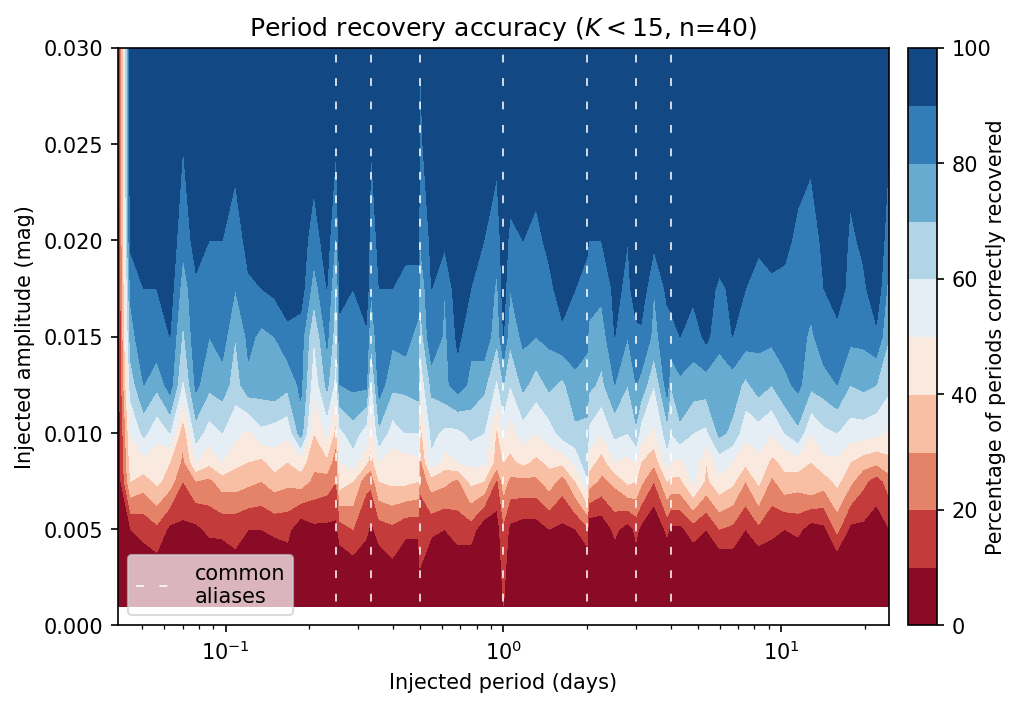

In [175]:
plt.style.use('default')

mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.top'] = False
mpl.rcParams['ytick.right'] = False


fig, ax = plt.subplots(1, figsize=(8,5), dpi=150)
plt.contourf(periods_denser, amplitudes_denser, 100*np.array(output_denser[0]).T, levels=100*np.linspace(0,1,11), cmap='RdBu')
plt.ylim(0,0.03)
plt.xlabel("Injected period (days)")
plt.ylabel("Injected amplitude (mag)")
plt.title(r"Period recovery accuracy ($K < 15$, n=40)")
plt.semilogx()
# plt.xlim(None,2.6)
cbar = plt.colorbar(pad=0.02)
cbar.set_label("Percentage of periods correctly recovered", labelpad=-2.5)

for per in extra_periods:
    plt.axvline(per, lw=0.75, ls='--', color='w', dashes=(5, 10))
    
plt.plot([0, 0], [0, 0], lw=0.75, ls='--', color='w', dashes=(5, 10), label='common\naliases')
plt.legend(loc='lower left', framealpha=0.7)
    
fig.savefig("period_recovery_grid.png")
fig.savefig("period_recovery_grid.pdf")

In [126]:
alias_scores = output_denser[3]
alias_scores = np.array(alias_scores)

np.max(alias_scores[2:,:])

0.55

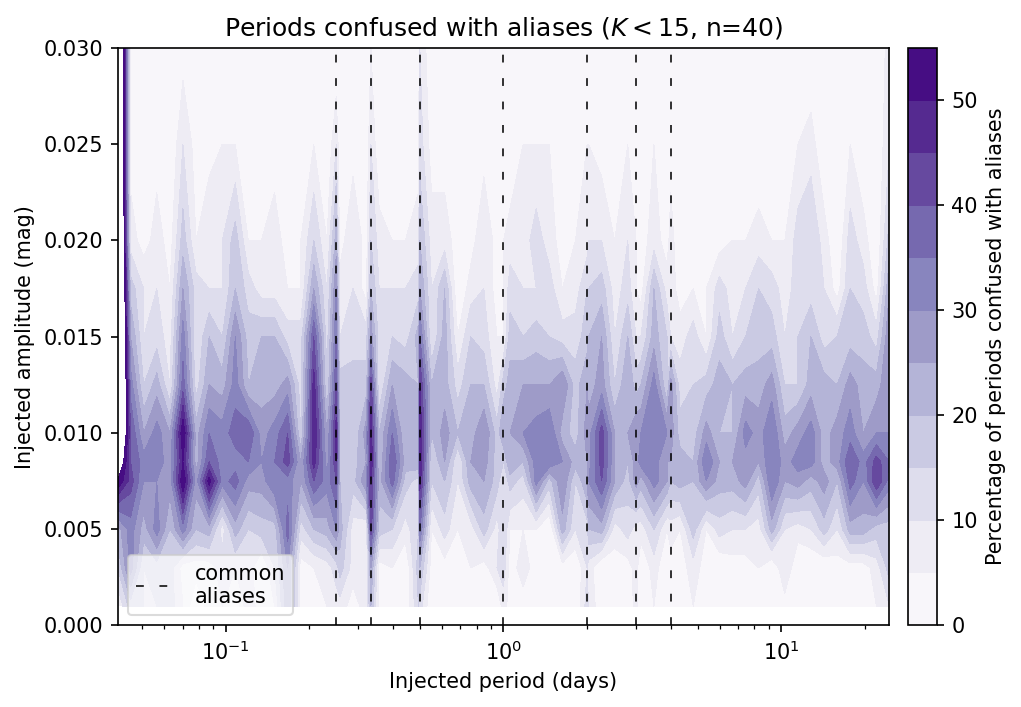

In [176]:
plt.style.use('default')

mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.top'] = False
mpl.rcParams['ytick.right'] = False

# this one is for aliases:
alias_scores = np.array(output_denser[3])
max_alias_score = np.max(alias_scores[2:,:])

fig, ax = plt.subplots(1, figsize=(8,5), dpi=150)
plt.contourf(periods_denser, amplitudes_denser, 100*np.array(output_denser[3]).T, levels=100*np.linspace(0,max_alias_score,12), cmap='Purples')
plt.ylim(0,None)
plt.xlabel("Injected period (days)")
plt.ylabel("Injected amplitude (mag)")
plt.title(r"Periods confused with aliases ($K < 15$, n=40)")
plt.semilogx()
# plt.xlim(None,2.6)
cbar = plt.colorbar(pad=0.02)
cbar.set_label("Percentage of periods confused with aliases")

for per in extra_periods:
    plt.axvline(per, lw=0.75, ls='--', color='k', dashes=(5, 10))
    
plt.plot([0, 0], [0, 0], lw=0.75, ls='--', color='k', dashes=(5, 10), label='common\naliases')
plt.legend(loc='lower left', framealpha=0.7)

fig.savefig("period_alias_grid.png")
fig.savefig("period_alias_grid.pdf")

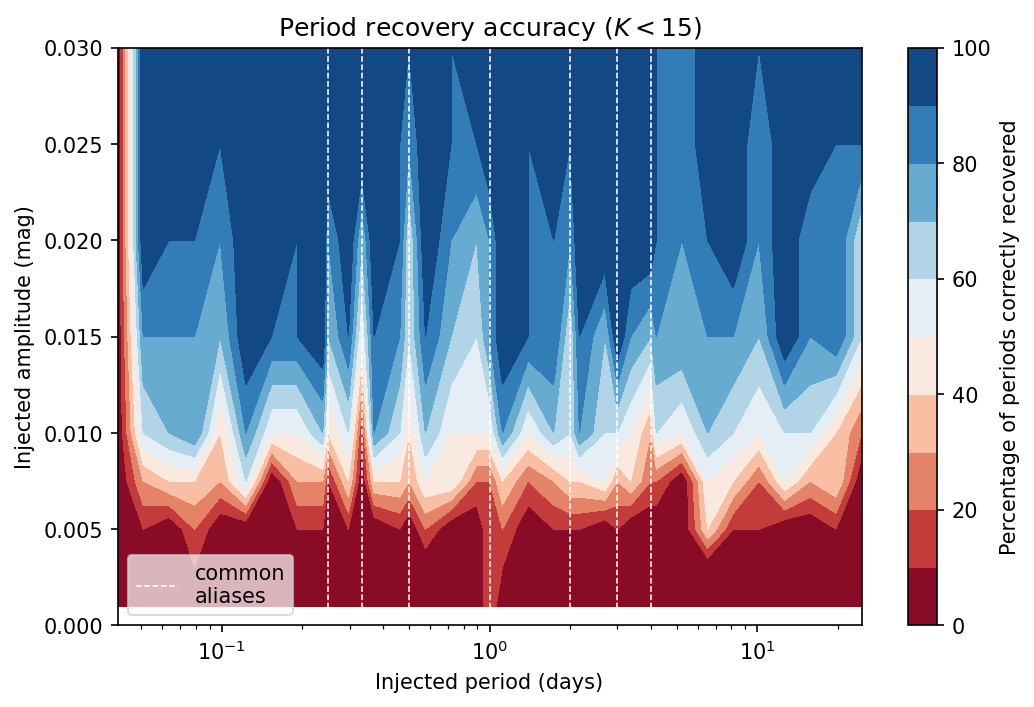

In [376]:
plt.style.use('default')


fig, ax = plt.subplots(1, figsize=(8,5), dpi=150)
plt.contourf(periods7_append_sorted, amplitudes7, 100*np.array(output7[0]).T, levels=100*np.linspace(0,1,11), cmap='RdBu')
plt.ylim(0,0.03)
plt.xlabel("Injected period (days)")
plt.ylabel("Injected amplitude (mag)")
plt.title(r"Period recovery accuracy ($K < 15$)")
plt.semilogx()
# plt.xlim(None,2.6)
cbar = plt.colorbar()
cbar.set_label("Percentage of periods correctly recovered")

for per in extra_periods:
    plt.axvline(per, lw=0.75, ls='--', color='w')
    
plt.plot([0, 0], [0, 0], lw=0.75, ls='--', color='w', label='common\naliases')
plt.legend(loc='lower left', framealpha=0.7)
    


In [461]:
plt.plot?

In [52]:
from wuvars.plotting.lightcurve import ic348_simple_lc_scatter_brokenaxes

n_nonvar = 0
for i, sid in enumerate(sids):
#     print(i, spread['variability']['Stetson_JHK'][sid])
    if 0 < spread['variability']['Stetson_JHK'][sid] <0.8:
        n_nonvar += 1
print(n_nonvar)
#     fig = ic348_simple_lc_scatter_brokenaxes(dat, sid)
#     fig.ax_j.set_title(f"IC348 {i}: {sid}")

29


In [51]:
len(output_denser[1][0][0])

40

In [54]:
def reassess_recovery_score(spread, sids, periods, amplitudes, previous_output):

    new_scores = []
    found_periods = previous_output[1]
    faps = previous_output[2]

    for i, period in enumerate(periods):

        _new_scores = []
        _found_periods = found_periods[i]
        _faps = faps[i]

        for j, amp in enumerate(amplitudes):

            __found_periods = _found_periods[j]
            __faps = _faps[j]
            correct = 0
            skip = 0

            for k, sid in enumerate(sids):

                fap = __faps[k]
                found_period = __found_periods[k]

                if 0 < spread['variability']['Stetson_JHK'][sid] < 0.8:
                    if np.abs(found_period - period) / period < 0.01:
                        correct += 1
    #                     print(f"A={amp:.2f} mag. Correct period: {found_period:.2f} v. {period:.2f}")
                    else:
    #                     print(f"A={amp:.2f} mag. Incorrect period: {found_period:.2f} v. {period:.2f}")
                        pass
                else:
                    skip +=1

                # pdb.set_trace()

#                 __found_periods.append(found_period)
#                 __faps.append(fap)

            new_score = correct / (len(sids) - skip)
            _new_scores.append(new_score)
#             _found_periods.append(__found_periods)
#             _faps.append(__faps)

        new_scores.append(_new_scores)
#         found_periods.append(_found_periods)
#         faps.append(_faps)

    return new_scores, found_periods, faps

In [56]:
output_denser_v2 = reassess_recovery_score(spread, sids, periods_denser, amplitudes_denser, output_denser)


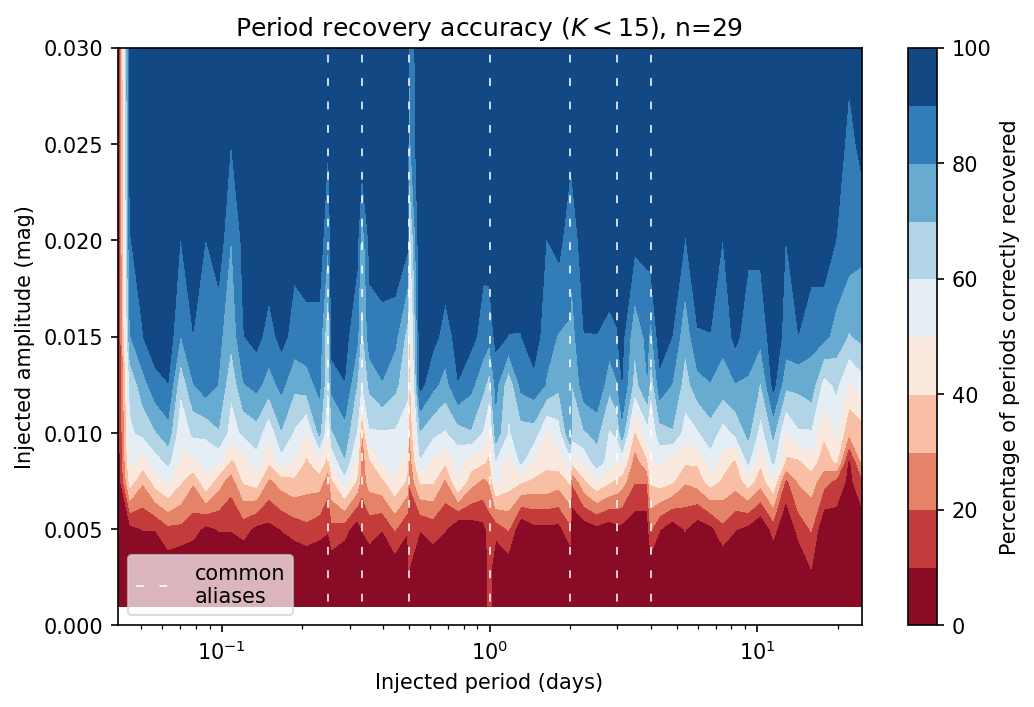

In [64]:
plt.style.use('default')

fig, ax = plt.subplots(1, figsize=(8,5), dpi=150)
plt.contourf(periods_denser, amplitudes_denser, 100*np.array(output_denser_v2[0]).T, levels=100*np.linspace(0,1,11), cmap='RdBu')
plt.ylim(0,0.03)
plt.xlabel("Injected period (days)")
plt.ylabel("Injected amplitude (mag)")
plt.title(r"Period recovery accuracy ($K < 15$), n=29")
plt.semilogx()
# plt.xlim(None,2.6)
cbar = plt.colorbar()
cbar.set_label("Percentage of periods correctly recovered")

for per in extra_periods:
    plt.axvline(per, lw=0.75, ls='--', color='w', dashes=(5, 10))
    
plt.plot([0, 0], [0, 0], lw=0.75, ls='--', color='w', dashes=(5, 10), label='common\naliases')
plt.legend(loc='lower left', framealpha=0.7)
    


[]

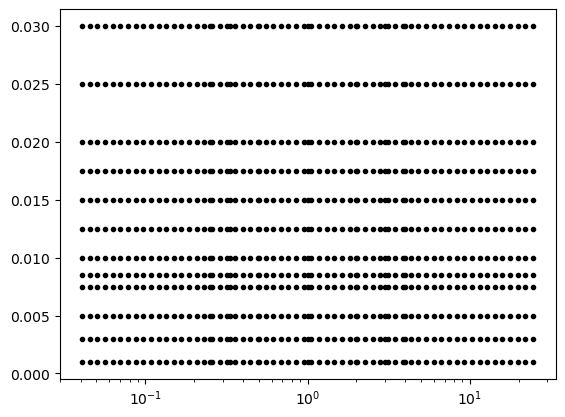

In [41]:
X_denser, Y_denser = np.meshgrid(periods_denser, amplitudes_denser)

plt.plot(X_denser, Y_denser, 'k.')
plt.semilogx()

In [1]:
from wuvars.analysis.alias_hunting import find_aliases



In [69]:
%run ../period_recovery.py

In [3]:
output_denser_alias = alias_score(spread, sids, periods_denser, amplitudes_denser, output_denser)


NameError: name 'spread' is not defined

In [18]:
periods_demo = (1/np.pi, np.pi)
amplitudes_demo = (0.001, 0.1)
sids_demo = all_sids[0:1]


In [102]:
startTime = datetime.now()
print(f"Starting at: {startTime}")

output_demo = recovery_score(dat, sids_demo, periods_demo, amplitudes_demo)

print(f"elapsed time: ", datetime.now() - startTime)


Starting at: 2021-08-22 21:50:03.672712
A=0.00 mag. Incorrect period: 0.25 v. 0.32
A=0.10 mag. Correct period: 0.32 v. 0.32
A=0.00 mag. Incorrect period: 0.25 v. 3.14
A=0.10 mag. Correct period: 3.14 v. 3.14
elapsed time:  0:00:02.077908


In [106]:
periods_demo2 = (1/np.pi, 1/2, 0.95, 1.05, 2, np.pi)
amplitudes_demo2 = (0.001, 0.01, 0.02, 0.05, 0.1)
sids_demo2 = all_sids[0:4]


In [109]:
startTime = datetime.now()
print(f"Starting at: {startTime}")

output_demo2 = recovery_score(dat, sids_demo2, periods_demo2, amplitudes_demo2)

print(f"elapsed time: ", datetime.now() - startTime)


Starting at: 2021-08-22 21:55:22.044422
A=0.00 mag. Incorrect period: 0.25 v. 0.32
A=0.00 mag. Incorrect period: 0.05 v. 0.32
A=0.00 mag. Incorrect period: 92.59 v. 0.32
A=0.00 mag. Incorrect period: 0.33 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Incorrect period: 0.13 v. 0.32
A=0.01 mag. Correct period: 0.32 v. 0.32
A=0.01 mag. Aliased period: 0.4675 v. 0.3183
A=0.02 mag. Correct period: 0.32 v. 0.32
A=0.02 mag. Correct period: 0.32 v. 0.32
A=0.02 mag. Correct period: 0.32 v. 0.32
A=0.02 mag. Correct period: 0.32 v. 0.32
A=0.05 mag. Correct period: 0.32 v. 0.32
A=0.05 mag. Correct period: 0.32 v. 0.32
A=0.05 mag. Correct period: 0.32 v. 0.32
A=0.05 mag. Correct period: 0.32 v. 0.32
A=0.10 mag. Correct period: 0.32 v. 0.32
A=0.10 mag. Correct period: 0.32 v. 0.32
A=0.10 mag. Correct period: 0.32 v. 0.32
A=0.10 mag. Correct period: 0.32 v. 0.32
A=0.00 mag. Aliased period: 0.2495 v. 0.5000
A=0.00 mag. Incorrect period: 0.26 v. 0.50
A=0.00 mag. Incorrect period: 0.13 v.

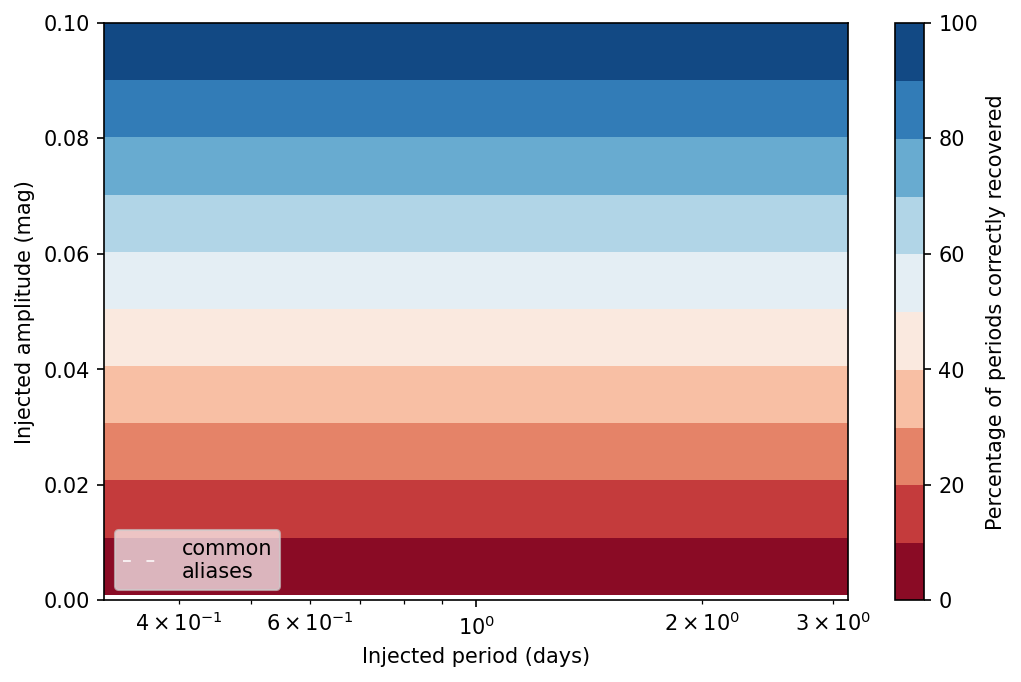

In [21]:
plt.style.use('default')

fig, ax = plt.subplots(1, figsize=(8,5), dpi=150)
plt.contourf(periods_demo, amplitudes_demo, 100*np.array(output_demo[0]).T, levels=100*np.linspace(0,1,11), cmap='RdBu')
plt.ylim(0,0.1)
plt.xlabel("Injected period (days)")
plt.ylabel("Injected amplitude (mag)")
# plt.title(r"Period recovery accuracy ($K < 15$), n=29")
plt.semilogx()
# plt.xlim(None,2.6)
cbar = plt.colorbar()
cbar.set_label("Percentage of periods correctly recovered")

# for per in extra_periods:
#     plt.axvline(per, lw=0.75, ls='--', color='w', dashes=(5, 10))
    
plt.plot([0, 0], [0, 0], lw=0.75, ls='--', color='w', dashes=(5, 10), label='common\naliases')
plt.legend(loc='lower left', framealpha=0.7)
    


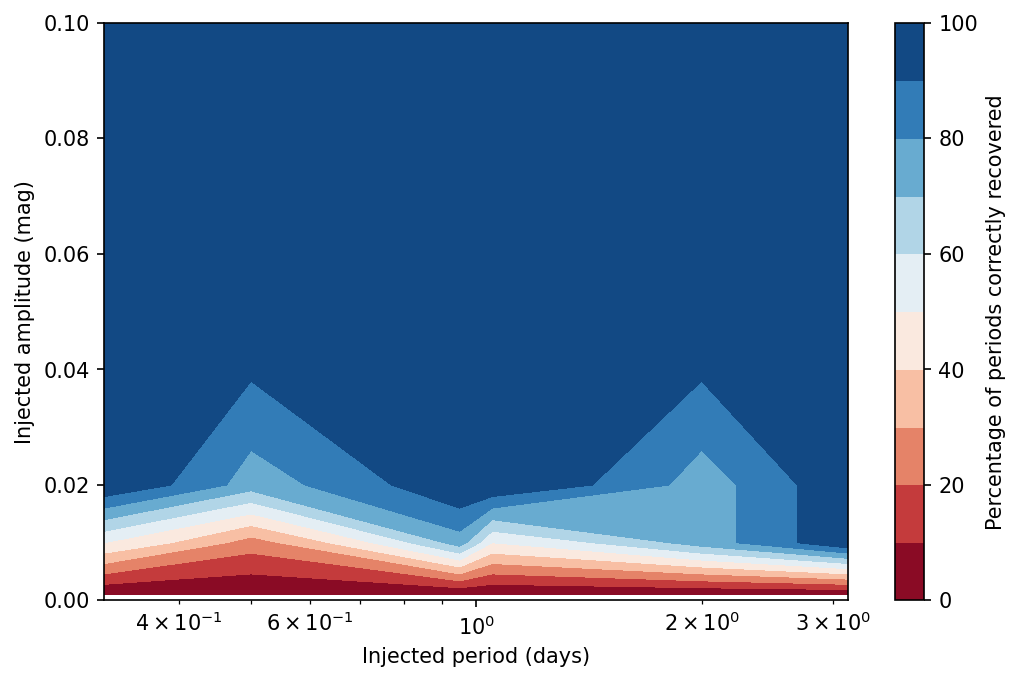

In [30]:
plt.style.use('default')

fig, ax = plt.subplots(1, figsize=(8,5), dpi=150)
plt.contourf(periods_demo2, amplitudes_demo2, 100*np.array(output_demo2[0]).T, levels=100*np.linspace(0,1,11), cmap='RdBu')
plt.ylim(0,0.1)
plt.xlabel("Injected period (days)")
plt.ylabel("Injected amplitude (mag)")
# plt.title(r"Period recovery accuracy ($K < 15$), n=29")
plt.semilogx()
# plt.xlim(None,2.6)
cbar = plt.colorbar()
cbar.set_label("Percentage of periods correctly recovered")

# for per in extra_periods:
#     plt.axvline(per, lw=0.75, ls='--', color='w', dashes=(5, 10))
    
plt.plot([0, 0], [0, 0], lw=0.75, ls='--', color='w', dashes=(5, 10), label='common\naliases')
# plt.legend(loc='lower left', framealpha=0.7)
    


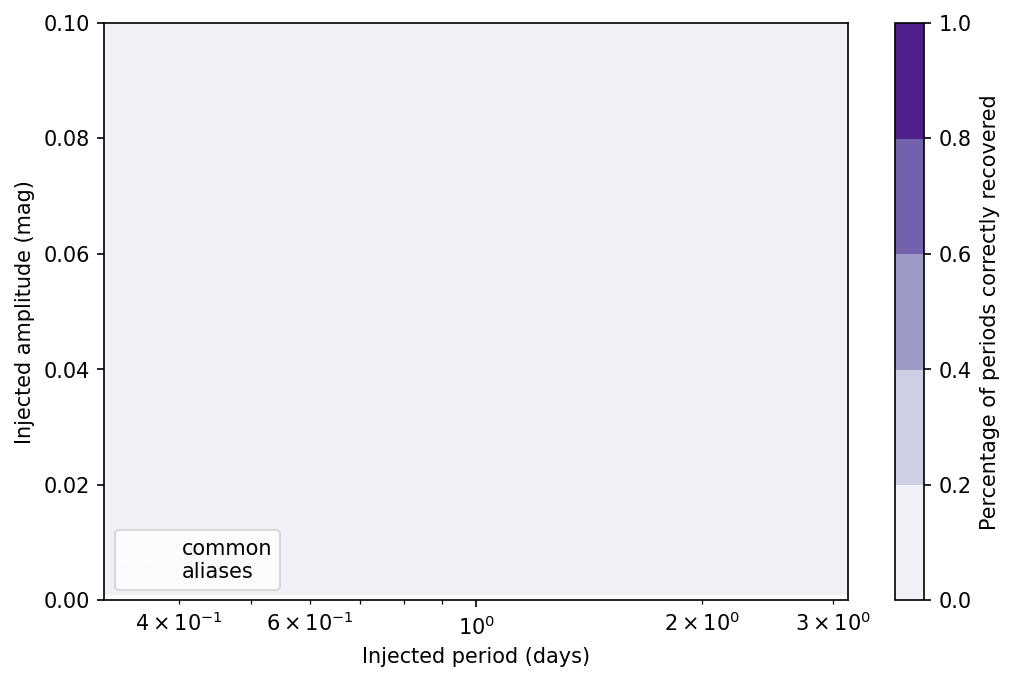

In [26]:
plt.style.use('default')

# this one is for aliases:
alias_scores = output_demo[3]
max_alias_score = np.max(alias_scores)

fig, ax = plt.subplots(1, figsize=(8,5), dpi=150)
plt.contourf(periods_demo, amplitudes_demo, 100*np.array(output_demo[3]).T, levels=100*np.linspace(0,max_alias_score+0.01,6), cmap='Purples')
plt.ylim(0,0.1)
plt.xlabel("Injected period (days)")
plt.ylabel("Injected amplitude (mag)")
# plt.title(r"Period recovery accuracy ($K < 15$), n=29")
plt.semilogx()
# plt.xlim(None,2.6)
cbar = plt.colorbar()
cbar.set_label("Percentage of periods correctly recovered")

# for per in extra_periods:
#     plt.axvline(per, lw=0.75, ls='--', color='w', dashes=(5, 10))
    
plt.plot([0, 0], [0, 0], lw=0.75, ls='--', color='w', dashes=(5, 10), label='common\naliases')
plt.legend(loc='lower left', framealpha=0.7)
    


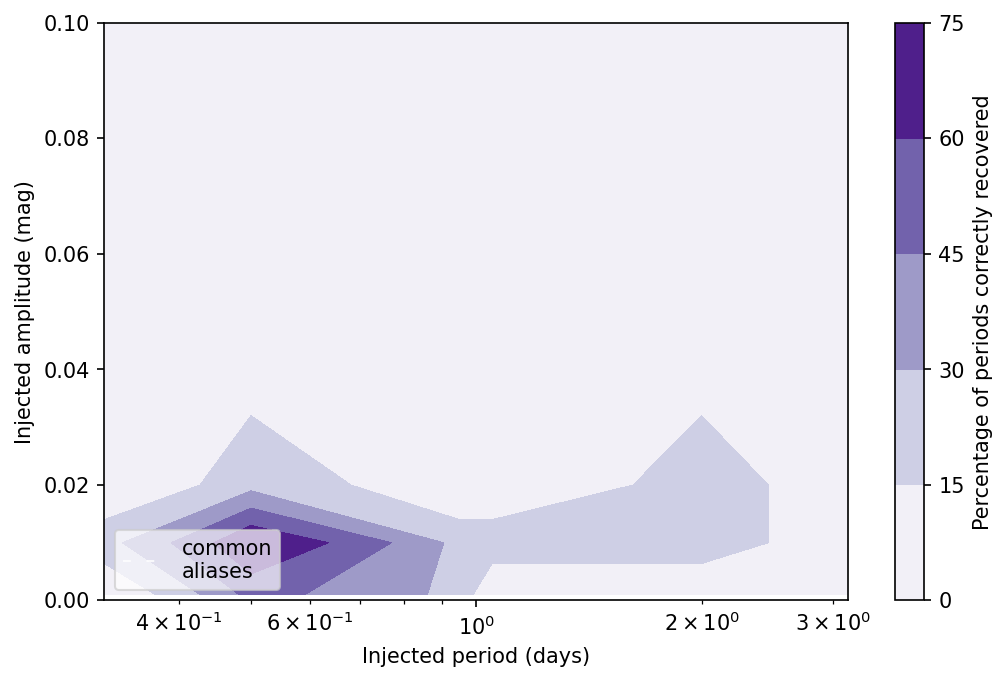

In [33]:
plt.style.use('default')

# this one is for aliases:
alias_scores = output_demo2[3]
max_alias_score = np.max(alias_scores)

fig, ax = plt.subplots(1, figsize=(8,5), dpi=150)
plt.contourf(periods_demo2, amplitudes_demo2, 100*np.array(output_demo2[3]).T, levels=100*np.linspace(0,max_alias_score,6), cmap='Purples')
plt.ylim(0,0.1)
plt.xlabel("Injected period (days)")
plt.ylabel("Injected amplitude (mag)")
# plt.title(r"Period recovery accuracy ($K < 15$), n=29")
plt.semilogx()
# plt.xlim(None,2.6)
cbar = plt.colorbar()
cbar.set_label("Percentage of periods correctly recovered")

# for per in extra_periods:
#     plt.axvline(per, lw=0.75, ls='--', color='w', dashes=(5, 10))
    
plt.plot([0, 0], [0, 0], lw=0.75, ls='--', color='w', dashes=(5, 10), label='common\naliases')
plt.legend(loc='lower left', framealpha=0.7)
    


In [53]:
# how to save
import pickle
pickle.pickle(output_demo)

AttributeError: module 'pickle' has no attribute 'pickle'

In [103]:
output_demo[2]

[[[0.0005899964245822877], [4.4256661863809853e-54]],
 [[0.0008474096550682671], [1.6381130361410137e-55]]]

In [60]:
fap = ls.false_alarm_probability(np.nanmax(power))


In [77]:
power

array([0.        , 0.        , 0.        , ..., 0.011707  , 0.00851593,
       0.00471958])

In [62]:
__faps

NameError: name '__faps' is not defined

In [86]:
ls._validate_frequency??

In [100]:
ls.power??

In [97]:
astropy.timeseries.lombscargle??

In [99]:
astropy.timeseries.implementations.lombscargle??

In [134]:
for i, output_item in enumerate(output_denser):
    np.save(f"output_denser_{i}_20210823.npy", np.array(output_item))

In [136]:
output_reconstructed = []

for i, output_item in enumerate(output_denser):
    a = np.load(f"output_denser_{i}_20210823.npy")
    output_reconstructed.append(a)

In [140]:
output_reconstructed[1] == np.array(output_denser[1])

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr